# Data Preprocessing

In [1]:
import pandas as pd
from statsmodels.stats.anova import anova_lm
from itertools import combinations
import numpy as np

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from scipy.stats import jarque_bera

from sklearn.linear_model import LinearRegression

#import durbin watson test
from statsmodels.stats.stattools import durbin_watson

#import kstest
from scipy.stats import kstest
from sklearn.preprocessing import PowerTransformer


In [2]:
df = pd.read_csv('../data/DEID_CSE_8A_Survey_and_Grade_Data_recode.csv')

In [3]:

df = df.drop(df.filter(regex='mid_').columns, axis=1)

#drop all columns starting with 'Neg_' or 'neg_'
df = df.drop(df.filter(regex='Neg_').columns, axis=1)

#get df of DEID,        'Final_copilotWorkspace/baseballAnalysis', 'Final_copilotWorkspace/spellCheck_copy1'
df_copilot = df[['DEID', 'Final_copilotWorkspace/baseballAnalysis', 'Final_copilotWorkspace/spellCheck_copy1']]

df_copilot

mastery_questions = [ 
    'My aim is to completely master the material presented in this class.',
    'I am striving to understand the content of this course as thoroughly as possible.',
    'My goal is to learn as much as possible.'
]

appearance_questions = [
    'One of my goals is to have other students in my class think I am good at my class work.',
    'One of my goals is to show others that I’m good at my class work.',
    'One of my goals is to show others that class work is easy for me.',
    'One of my goals is to look smart in comparison to other students in my class.',
    'I aim to look smart compared to others in my class.'
]

normative_questions = [
    'My aim is to perform well relative to other students.',
    'I am striving to do well compared to other students.',
    'My goal is to perform better than the other students.'
]

interest_questions = [
    'I think what we are learning in this class is interesting.',
    'I think I will be able to use what I learn in this course in other courses.',
    'I would recommend this class to others.',
    'I am enjoying this computer science class very much.',
    'I think the field of computer science is very interesting.',
    'This class has been a waste of my time.',
    'I’m glad I took this class.',
    'I think the course material in this class is useful for me to learn.',
    'I would like to take more computer science classes after this one.',
    'I am more likely to register for another computer science class because of my experience in this course.'
]

copilot_read_output = [
    #'mid_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Read the code]',
    'end_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Read the code]',
]

copilot_test_output = [
    #'mid_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Test the code]',        
    'end_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Test the code]',
]

copilot_helped_hindered = [
    #'mid_Please select the statement that best described your experience working with Copilot this term.',
    'end_Please select the statement that best described your experience working with Copilot this term.'
]
misc_percentage_and_confidence = [
    'end_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Feel you can recognize and understand the code Copilot gives you]', #done
    'end_How confident or unconfident are you that you are learning how to write programs yourself, when using GenAI tools?', #done
    'end_How confident or unconfident are you that you can: [Recognize and understand the code Copilot generates.]', #done
    'end_How confident or unconfident are you that you can: [Identify the types of coding problems that I should be able to complete without copilot]', #done 
    'end_How confident or unconfident are you that you can: [Do the tasks in CSE8A without Copilot.]', #done
    'end_How confident or unconfident are you that you have a fundamental understanding of programming concepts?'] #done



genai_helps_program = ['end_How helpful or unhelpful are GenAI tools in learning how to program?']
genai_helps_understand = ['end_How helpful or unhelpful are GenAI tools in learning problem solving skills?']

progintelligencequestions = ['end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You can learn new things, but you can’t really change your programming intelligence.]', 
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [To be honest, you can’t really change your programming intelligence.]', 
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [People have a certain amount of ability to learn programming, and they really can’t do much to change it.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You have a certain amount of programming intelligence, and you can’t really do much to change it.]', 
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Even if the work is hard in CSE 8A, I can learn it.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do almost all the work in CSE 8A if I don\'t give up.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can master the skills taught in my CSE 8A class this term.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Not everyone is well-suited for programming.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Programming comes naturally to some people but not others.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do even the hardest work in CSE 8A if I try.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can figure out how to do the most difficult work in my CSE 8A class.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Anyone has the ability to learn programming and be good at it.]',
                             ]


can_do_this_task_questions = [
    'Create a variable called “num” and assign the value 5 to it', 
    'Write a statement that prints “hello” if a variable “val” has a value greater than 7.',
    'Print the third letter in a string.',
    'Print the sum of all of the elements in a list that has 3 elements.',
    'Print every number from 1 to 100.',
    'Open and print the first line in a file.',
    'For a dictionary d = {“a”: 3, “b”: 4, “c”: 5}, update the value of b to 6.',
    'Imagine you’re given code that flipped an image left to right, change it to flip the image top to bottom.'
    ]


copilot_reading_and_testing_questions = copilot_read_output + copilot_test_output
columns = [
    col 
    for col in df.columns 
    if any(q in col for q in mastery_questions + normative_questions + appearance_questions)
]


columns += [
    col 
    for col in df.columns 
    if any(q in col for q in interest_questions) and (col.startswith('end_'))
]

columns += [
    col 
    for col in df.columns 
    if any(q in col for q in copilot_read_output + copilot_test_output)
]

columns += [
    col 
    for col in df.columns 
    if any(q in col for q in copilot_helped_hindered)
]

columns += [
    col
    for col in df.columns
    if any(q in col for q in progintelligencequestions)]

columns += [
    col
    for col in df.columns
    if any(q in col for q in genai_helps_program)
]

columns += [
    col
    for col in df.columns
    if any(q in col for q in genai_helps_understand)
]

columns += [
    col
    for col in df.columns
    if any(q in col for q in misc_percentage_and_confidence)
]

columns += [
    col 
    for col in df.columns 
    if any(q in col for q in can_do_this_task_questions) and (col.startswith('end_How confident or unconfident do you feel that you could write a program for the given task without Copilot?'))
]

columns += [
    'Final Letter Grade (as GPA)',
    'Project Grade Overall',
    'Homework Grade Overall',
    'Reading Quiz Grade Overall',
    'Lab Grade Overall',
    'Quiz Grade Overall',
    'Final Exam Score',
    'Score for Participation (Overall)', 
    
    ]


columns += [
    'pre_Before taking CSE 8A this quarter, did you have any prior knowledge in programming or computer science? (Note: We do not expect any prior CS experience before taking this course.)',
    'pre_What is your intended major?',
    'pre_On a scale of 1-5, how confident are you about your ability to do well in this course?',
    'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I feel like I belong in computing.]'
    ]


columns += [
    'Section (A or B)',
    'Final_copilot_question', 
    'Final_noncopilot_questions']

columns



['pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [One of my goals is to show others that I’m good at my class work.]',
 'pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [I am striving to understand the content of this course as thoroughly as possible.]',
 'pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My goal is to learn as much as possible.]',
 'pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [One of my goals is to have other students in my class think I am good at my class work.]',
 'pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My aim is to perform well relative to other students.]',
 'pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My aim is to completely master the material presented in thi

In [4]:


#df[columns[-3:]].head()
df["Final_copilot_question"] = df["Final_copilotWorkspace/spellCheck_copy1"].combine(df["Final_copilotWorkspace/baseballAnalysis"], lambda x, y: x if pd.notna(x) else y)

#get average of all columns containing "Final_" and exclude "Final_copilot_question"
df["Final_noncopilot_questions"] = df.filter(regex='Final_').drop(columns='Final_copilot_question').sum(axis=1) / (df.filter(regex='Final_').count(axis=1) - 1)

x = [column for column in df.columns if 'Final_' in column]
display(df[x].head())

df = df[columns].dropna()

df

,Final_Fill_in_answer_Verbatim2,Final_Fill_in_answer_Verbatim3,Final_Fill_in_answer_Verbatim4,Final_Fill_in_answer_Verbatim5,Final_Fill_in_answer_Verbatim7,Final_Final/Games_Testing,Final_Final/References,Final_Parsons/ChangeColorsInImage,Final_Parsons/Consecutive_repeats,Final_Section1_Soci_Q7,...,Final_debugging_code_modification,Final_part1_2013exam_3b_code_writing,Final_B_Part2_Q1,Final_B_Part2_Q2,Final_debugging_code_modification_02,Final_part2_getWhitePixelVals,Final_copilotWorkspace/baseballAnalysis,Final_copilotWorkspace/spellCheck_copy1,Final_copilot_question,Final_noncopilot_questions
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,60.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.000000,28.326117
1,100.0,100.0,100.0,100.0,0.0,100.0,0.0,100.0,100.0,50.0,...,NaN,NaN,100.0,100.0,100.0,100.0,NaN,85.714286,85.714286,85.491071
2,0.0,0.0,0.0,0.0,0.0,100.0,100.0,45.0,80.0,0.0,...,100.0,60.0,NaN,NaN,NaN,NaN,20.0,NaN,20.000000,67.936422
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000000
4,0.0,100.0,0.0,0.0,0.0,100.0,100.0,9.0,0.0,0.0,...,50.0,20.0,NaN,NaN,NaN,NaN,20.0,NaN,20.000000,52.770474


,pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [One of my goals is to show others that I’m good at my class work.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [I am striving to understand the content of this course as thoroughly as possible.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My goal is to learn as much as possible.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [One of my goals is to have other students in my class think I am good at my class work.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My aim is to perform well relative to other students.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My aim is to completely master the material presented in this class.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [One of my goals is to show others that class work is easy for me.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [One of my goals is to look smart in comparison to other students in my class.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My goal is to perform better than the other students.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [I aim to look smart compared to others in my class.],...,Quiz Grade Overall,Final Exam Score,Score for Participation (Overall),"pre_Before taking CSE 8A this quarter, did you have any prior knowledge in programming or computer science? (Note: We do not expect any prior CS experience before taking this course.)",pre_What is your intended major?,"pre_On a scale of 1-5, how confident are you about your ability to do well in this course?","end_Rate how much you agree with each of the following statements from ""Strongly disagree"" to ""Strongly agree"". [I feel like I belong in computing.]",Section (A or B),Final_copilot_question,Final_noncopilot_questions
0,2.0,4.0,4.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,...,64.396667,23.7240,100.0,Yes,MAS Data Science and Engineering,4.0,6.0,A,0.00000,28.326117
6,4.0,7.0,7.0,4.0,4.0,7.0,3.0,4.0,4.0,5.0,...,96.953333,75.5260,100.0,Yes,Economics,5.0,5.0,A,20.00000,83.437500
10,6.0,7.0,7.0,6.0,7.0,7.0,3.0,5.0,7.0,7.0,...,88.613333,52.5150,100.0,Yes,"Computer Science, Data Science with minor in math",4.0,6.0,A,20.00000,59.075039
11,4.0,6.0,5.0,3.0,4.0,4.0,2.0,2.0,3.0,3.0,...,88.126667,72.9950,100.0,Yes,computer science,2.0,5.0,B,90.47619,70.546131
12,6.0,7.0,7.0,7.0,7.0,7.0,4.0,4.0,7.0,4.0,...,87.910000,60.4285,100.0,No,Data Science,5.0,2.0,B,0.00000,69.114583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,91.430000,59.6665,100.0,Yes,Management Science,4.0,3.0,A,20.00000,65.205721
544,1.0,5.0,4.0,1.0,7.0,3.0,1.0,1.0,1.0,1.0,...,68.263333,56.6550,100.0,No,Psychology,4.0,1.0,A,20.00000,63.343750
549,5.0,6.0,7.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,...,91.933333,63.3675,100.0,No,International Studies - Economics,4.0,5.0,A,100.00000,57.947198
550,2.0,7.0,6.0,1.0,5.0,5.0,1.0,1.0,5.0,1.0,...,63.863333,44.9590,100.0,No,Business Psychology,4.0,5.0,A,60.00000,45.218750


In [5]:

df = df.rename(columns={'mid_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Read the code]': 'MidQ_Read_Code'})
df = df.rename(columns={'end_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Read the code]': 'EndQ_Read_Code'})
df = df.rename(columns={'mid_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Test the code]': 'MidQ_TestCode'})
df = df.rename(columns={'end_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Test the code]': 'EndQ_TestCode'})
df = df.rename(columns={'end_How confident or unconfident are you that you are learning how to write programs yourself, when using GenAI tools? \n\n1: Strongly unconfident\n2: Unconfident\n3: Slightly unconfident\n4: Slightly confident\n5: Confident\n6: Strongly confident': 'ConfidentIndependentProgramming'})
df = df.rename(columns={'end_How confident or unconfident are you that you can: [Do the tasks in CSE8A without Copilot.]': 'ConfidentWithoutCopilot'})
df = df.rename(columns={'end_How confident or unconfident are you that you can: [Recognize and understand the code Copilot generates.]': 'ConfidentRecognizeCopilotOutput'})
df = df.rename(columns={'end_How confident or unconfident are you that you can: [Identify the types of coding problems that I should be able to complete without copilot]': 'ConfidentIdentifyCodingProblems'})
df = df.rename(columns={'end_How confident or unconfident are you that you have a fundamental understanding of programming concepts? \n\n1: Strongly unconfident\n2: Unconfident\n3: Slightly unconfident\n4: Slightly confident\n5: Confident\n6: Strongly confident': 'ConfidentFundamental'})
df = df.rename(columns={'end_Please select the statement that best described your experience working with Copilot this term.': 'CopilotHelpedHindered'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You can learn new things, but you can’t really change your programming intelligence.]': 'ProgIntelligence1'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [To be honest, you can’t really change your programming intelligence.]': 'ProgIntelligence2'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [People have a certain amount of ability to learn programming, and they really can’t do much to change it.]': 'ProgIntelligence3'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You have a certain amount of programming intelligence, and you can’t really do much to change it.]': 'ProgIntelligence4'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Even if the work is hard in CSE 8A, I can learn it.]': 'ProgIntelligence5G'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do almost all the work in CSE 8A if I don\'t give up.]': 'ProgIntelligence6G'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can master the skills taught in my CSE 8A class this term.]': 'ProgIntelligence7G'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Not everyone is well-suited for programming.]': 'ProgIntelligence8'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Programming comes naturally to some people but not others.]': 'ProgIntelligence9'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do even the hardest work in CSE 8A if I try.]': 'ProgIntelligence10G'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can figure out how to do the most difficult work in my CSE 8A class.]': 'ProgIntelligence11G'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Anyone has the ability to learn programming and be good at it.]': 'ProgIntelligence12G'})
df = df.rename(columns={'end_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Feel you can recognize and understand the code Copilot gives you]': 'PercentageRecognizeCopilotOutput'})
df = df.rename(columns={'end_How helpful or unhelpful are GenAI tools in learning how to program?\n\n1: Strongly unhelpful\n2: Unhelpful\n3: Slightly unhelpful\n4: Slightly helpful\n5: Helpful\n6: Strongly helpful': 'GenAIHelpsProgramming'})
df = df.rename(columns={'end_How helpful or unhelpful are GenAI tools in learning problem solving skills?\n\n1: Strongly unhelpful\n2: Unhelpful\n3: Slightly unhelpful\n4: Slightly helpful\n5: Helpful\n6: Strongly helpful': 'GenAIHelpsProblemSolving'}) 
df = df.rename(columns={'Final Exam Score': 'Final_Exam_Score'})

copilot_read_output = [#'MidQ Read the code', 
                       'EndQ_Read_Code']
copilot_test_output = [#'MidQ Test the code', 
                       'EndQ_TestCode']
copilot_helped_hindered = ['CopilotHelpedHindered']
percentage_recognize_copilot_output = ['PercentageRecognizeCopilotOutput']
confident_programming_yourself = ['ConfidentIndependentProgramming']
confident_recognize_copilot_output = ['ConfidentRecognizeCopilotOutput']
confident_identify_coding_problems = ['ConfidentIdentifyCodingProblems']
confident_do_without_copilot = ['ConfidentWithoutCopilot']
confident_fundamental = ['ConfidentFundamental']
genai_helps_program = ['GenAIHelpsProgramming']
genai_helps_understand = ['GenAIHelpsProblemSolving']


progintelligencequestions = ['ProgIntelligence1', 'ProgIntelligence2', 'ProgIntelligence3', 'ProgIntelligence4', 'ProgIntelligence5G', 'ProgIntelligence6G', 'ProgIntelligence7G', 'ProgIntelligence8', 'ProgIntelligence9', 'ProgIntelligence10G', 'ProgIntelligence11G', 'ProgIntelligence12G']



In [6]:
df.columns = [col.split('[')[1].strip()[:-1] if '[' in col else col for col in df.columns ]
df.columns

Index(['One of my goals is to show others that I’m good at my class work.',
       'I am striving to understand the content of this course as thoroughly as possible.',
       'My goal is to learn as much as possible.',
       'One of my goals is to have other students in my class think I am good at my class work.',
       'My aim is to perform well relative to other students.',
       'My aim is to completely master the material presented in this class.',
       'One of my goals is to show others that class work is easy for me.',
       'One of my goals is to look smart in comparison to other students in my class.',
       'My goal is to perform better than the other students.',
       'I aim to look smart compared to others in my class.',
       'I am striving to do well compared to other students.',
       'I think what we are learning in this class is interesting.',
       'I think I will be able to use what I learn in this course in other courses.',
       'I would recommend this c

In [7]:
#describe stats for interest
df[interest_questions].describe()

,I think what we are learning in this class is interesting.,I think I will be able to use what I learn in this course in other courses.,I would recommend this class to others.,I am enjoying this computer science class very much.,I think the field of computer science is very interesting.,This class has been a waste of my time.,I’m glad I took this class.,I think the course material in this class is useful for me to learn.,I would like to take more computer science classes after this one.,I am more likely to register for another computer science class because of my experience in this course.
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,5.648438,5.519531,5.296875,5.074219,5.652344,2.195312,5.453125,5.695312,5.324219,5.082031
std,1.442165,1.635276,1.677343,1.698430,1.544197,1.664195,1.741576,1.476926,1.966474,1.965663
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,4.000000,4.000000,5.000000,1.000000,5.000000,5.000000,4.000000,4.000000
50%,6.000000,6.000000,6.000000,5.000000,6.000000,1.000000,6.000000,6.000000,6.000000,6.000000
75%,7.000000,7.000000,7.000000,7.000000,7.000000,3.000000,7.000000,7.000000,7.000000,7.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [8]:
df[can_do_this_task_questions].describe()

,Create a variable called “num” and assign the value 5 to it,Write a statement that prints “hello” if a variable “val” has a value greater than 7.,Print the third letter in a string.,Print the sum of all of the elements in a list that has 3 elements.,Print every number from 1 to 100.,Open and print the first line in a file.,"For a dictionary d = {“a”: 3, “b”: 4, “c”: 5}, update the value of b to 6.","Imagine you’re given code that flipped an image left to right, change it to flip the image top to bottom."
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,5.414062,5.238281,5.121094,5.121094,5.191406,4.914062,4.816406,3.933594
std,0.974396,1.063595,1.136293,1.153420,1.098343,1.092056,1.299127,1.543959
min,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000
25%,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,4.000000,3.000000
50%,6.000000,6.000000,5.000000,6.000000,6.000000,5.000000,5.000000,4.000000
75%,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000
max,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000


In [9]:
# final coluumns
[column for column in df.columns if 'Final' in column]

['Final Letter Grade (as GPA)',
 'Final_Exam_Score',
 'Final_copilot_question',
 'Final_noncopilot_questions']

In [10]:
# Process the prior knowledge column
df = df.rename(columns={'pre_Before taking CSE 8A this quarter, did you have any prior knowledge in programming or computer science? (Note: We do not expect any prior CS experience before taking this course.)': 'Prior_Knowledge'})
df = df.rename(columns={'pre_What is your intended major?': 'CSMajor'})
df = df.rename(columns={'pre_On a scale of 1-5, how confident are you about your ability to do well in this course?': 'SelfEfficacy'})
df = df.rename(columns={'I feel like I belong in computing.': 'Belonging'})
##TODO: add: 
#I see myself as a computing person.
#I feel like an outsider in the computing community. (NEG)
#I do not have much in common with the other students in my computing classes. (NEG)
#I feel welcomed in computing.
#Computing is a big part of who I am.--ASK IN MEETING: Include or not? check Sofia's current sense of belonging questions


df = df.rename(columns={'end_How confident or unconfident are you that you are learning how to write programs yourself, when using GenAI tools?': 'ConfidentIndependentProgramming'})

#flip responses of 'This class has been a waste of my time.' because it's negative, unlike all the others in its category. 

df['This class has been a waste of my time.'] = 7 - df['This class has been a waste of my time.']+ 1
df['ProgIntelligence5G'] = 5 - df['ProgIntelligence5G'] + 1
df['ProgIntelligence6G'] = 5 - df['ProgIntelligence6G'] + 1
df['ProgIntelligence7G'] = 5 - df['ProgIntelligence7G'] + 1
df['ProgIntelligence10G'] = 5 - df['ProgIntelligence10G'] + 1
df['ProgIntelligence11G'] = 5 - df['ProgIntelligence11G'] + 1
df['ProgIntelligence12G'] = 5 - df['ProgIntelligence12G'] + 1

df['Prior_Knowledge'] = df['Prior_Knowledge'].map({'Yes': 1, 'No': 0})

"""cs_major_substrings = [
    "computer science",
    "computer engineering",
    "data science",
    "cs",
    "cse"
] 
""" #I think having "cs" might cause an issue for words like "mathematics" that contain the substring "cs". I did " cs" for this reason 

cs_major_substrings = [' cs', '-cs', 'computer', 'math-cs', 'comp sci','mathematics computer science', 'mathematics-computer science', 'bioinformatics', 'data science'] 

df['CSMajor'] = df['CSMajor'].str.lower()
df['CSMajor'] = df['CSMajor'].map(lambda x: int(any(substring in x for substring in cs_major_substrings)))
df

,One of my goals is to show others that I’m good at my class work.,I am striving to understand the content of this course as thoroughly as possible.,My goal is to learn as much as possible.,One of my goals is to have other students in my class think I am good at my class work.,My aim is to perform well relative to other students.,My aim is to completely master the material presented in this class.,One of my goals is to show others that class work is easy for me.,One of my goals is to look smart in comparison to other students in my class.,My goal is to perform better than the other students.,I aim to look smart compared to others in my class.,...,Quiz Grade Overall,Final_Exam_Score,Score for Participation (Overall),Prior_Knowledge,CSMajor,SelfEfficacy,Belonging,Section (A or B),Final_copilot_question,Final_noncopilot_questions
0,2.0,4.0,4.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,...,64.396667,23.7240,100.0,1.0,1,4.0,6.0,A,0.00000,28.326117
6,4.0,7.0,7.0,4.0,4.0,7.0,3.0,4.0,4.0,5.0,...,96.953333,75.5260,100.0,1.0,0,5.0,5.0,A,20.00000,83.437500
10,6.0,7.0,7.0,6.0,7.0,7.0,3.0,5.0,7.0,7.0,...,88.613333,52.5150,100.0,1.0,1,4.0,6.0,A,20.00000,59.075039
11,4.0,6.0,5.0,3.0,4.0,4.0,2.0,2.0,3.0,3.0,...,88.126667,72.9950,100.0,1.0,1,2.0,5.0,B,90.47619,70.546131
12,6.0,7.0,7.0,7.0,7.0,7.0,4.0,4.0,7.0,4.0,...,87.910000,60.4285,100.0,0.0,1,5.0,2.0,B,0.00000,69.114583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,91.430000,59.6665,100.0,1.0,0,4.0,3.0,A,20.00000,65.205721
544,1.0,5.0,4.0,1.0,7.0,3.0,1.0,1.0,1.0,1.0,...,68.263333,56.6550,100.0,0.0,0,4.0,1.0,A,20.00000,63.343750
549,5.0,6.0,7.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,...,91.933333,63.3675,100.0,0.0,0,4.0,5.0,A,100.00000,57.947198
550,2.0,7.0,6.0,1.0,5.0,5.0,1.0,1.0,5.0,1.0,...,63.863333,44.9590,100.0,0.0,0,4.0,5.0,A,60.00000,45.218750


In [11]:
df['CSMajor'].value_counts()

CSMajor
0    139
1    117
Name: count, dtype: int64

## Descriptive Stats 

### Boxplots for outcomes and achievement goals 

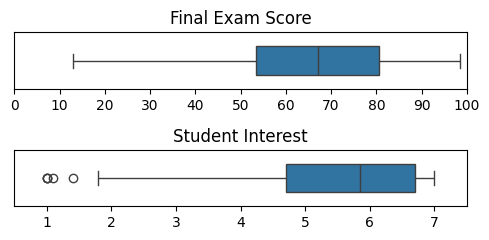

In [12]:

#create new col with average of all interest questions
df['Interest_mean'] = df[interest_questions].mean(axis=1)


import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5, 2.5))  # Reduced figure height for a compact layout

plt.subplot(2, 1, 1)
sns.boxplot(x='Final_Exam_Score', data=df, width=0.2)  # Thinner boxplot
plt.xlabel('')
plt.title('Final Exam Score')
plt.xlim(df['Final_Exam_Score'].min() - 1, df['Final_Exam_Score'].max() + 1)
plt.xticks(range(0, 101, 10))  # Set x-axis labels from 0 to 100

plt.ylim(-0.2, 0.2)  # Tighten y-axis limits to reduce height
plt.yticks([]) 

plt.subplot(2, 1, 2)
sns.boxplot(x='Interest_mean', data=df, width=0.2)  # Thinner boxplot
plt.xlabel('')
plt.title('Student Interest')
plt.xlim(0.5, 7.5)  # Set x-axis range from 1 to 7
plt.xticks(range(1, 8))  # Set x-axis labels from 1 to 7
plt.ylim(-0.2, 0.2)  # Tighten y-axis limits
plt.yticks([]) 
plt.subplots_adjust(hspace=0.7)  # Adjust space between plots
plt.tight_layout()

#save to file
plt.savefig('exam_and_interest_boxplots.pdf')


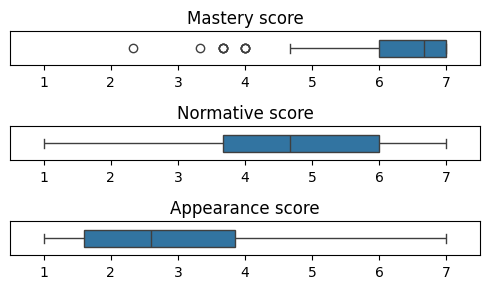

In [13]:


frame_visible = True # Set to False to hide box outlines

df['Mastery_score'] = df[mastery_questions].mean(axis=1)
df['Normative_score'] = df[normative_questions].mean(axis=1)
df['Appearance_score'] = df[appearance_questions].mean(axis=1)
df['CanDoThisTask'] = df[can_do_this_task_questions].mean(axis=1)
plt.figure(figsize=(5, 3))

# First boxplot
plt.subplot(3, 1, 1)
sns.boxplot(x='Mastery_score', data=df, width=0.2)
plt.xlabel('')
plt.title('Mastery score')
plt.xlim(0.5, 7.5)  # Set x-axis range from 1 to 7
plt.xticks(range(1, 8))  # Set x-axis labels from 1 to 7
plt.ylim(-0.2, 0.2)  # Tight y-axis for compact layout
plt.gca().spines['top'].set_visible(frame_visible)
plt.gca().spines['right'].set_visible(frame_visible)
plt.gca().spines['left'].set_visible(frame_visible)
plt.gca().spines['bottom'].set_visible(frame_visible)
plt.yticks([]) 

# Second boxplot
plt.subplot(3, 1, 2)
sns.boxplot(x='Normative_score', data=df, width=0.2)
plt.xlabel('')
plt.title('Normative score')
plt.xlim(0.5, 7.5)
plt.xticks(range(1, 8))
plt.ylim(-0.2, 0.2)
plt.gca().spines['top'].set_visible(frame_visible)
plt.gca().spines['right'].set_visible(frame_visible)
plt.gca().spines['left'].set_visible(frame_visible)
plt.gca().spines['bottom'].set_visible(frame_visible)
plt.yticks([]) 

# Third boxplot
plt.subplot(3, 1, 3)
sns.boxplot(x='Appearance_score', data=df, width=0.2)
plt.xlabel('')
plt.title('Appearance score')
plt.xlim(0.5, 7.5)
plt.xticks(range(1, 8))
plt.ylim(-0.2, 0.2)
plt.yticks([]) 
plt.gca().spines['top'].set_visible(frame_visible)
plt.gca().spines['right'].set_visible(frame_visible)
plt.gca().spines['left'].set_visible(frame_visible)
plt.gca().spines['bottom'].set_visible(frame_visible)

plt.subplots_adjust(hspace=0.7)  # Space between plots for readability
plt.tight_layout()

#save to file
#plt.savefig('mastery_normative_appearance_boxplots.pdf')


In [14]:
df[['Final_Exam_Score', 'Interest_mean']].describe()

,Final_Exam_Score,Interest_mean
count,256.000000,256.000000
mean,65.148363,5.455078
std,19.144878,1.441450
min,12.964000,1.000000
25%,53.351750,4.700000
50%,67.011000,5.850000
75%,80.580625,6.700000
max,98.572000,7.000000


In [15]:
#describe goal scores
df[['Mastery_score', 'Normative_score', 'Appearance_score']].describe()

,Mastery_score,Normative_score,Appearance_score
count,256.000000,256.000000,256.000000
mean,6.359375,4.630208,2.849219
std,0.841836,1.642430,1.479030
min,2.333333,1.000000,1.000000
25%,6.000000,3.666667,1.600000
50%,6.666667,4.666667,2.600000
75%,7.000000,6.000000,3.850000
max,7.000000,7.000000,7.000000


In [16]:
df['CanDoThisTask'].describe()

count    256.000000
mean       4.968750
std        0.935611
min        1.125000
25%        4.500000
50%        5.125000
75%        5.750000
max        6.000000
Name: CanDoThisTask, dtype: float64

### Scatterplots 

#### Interest 

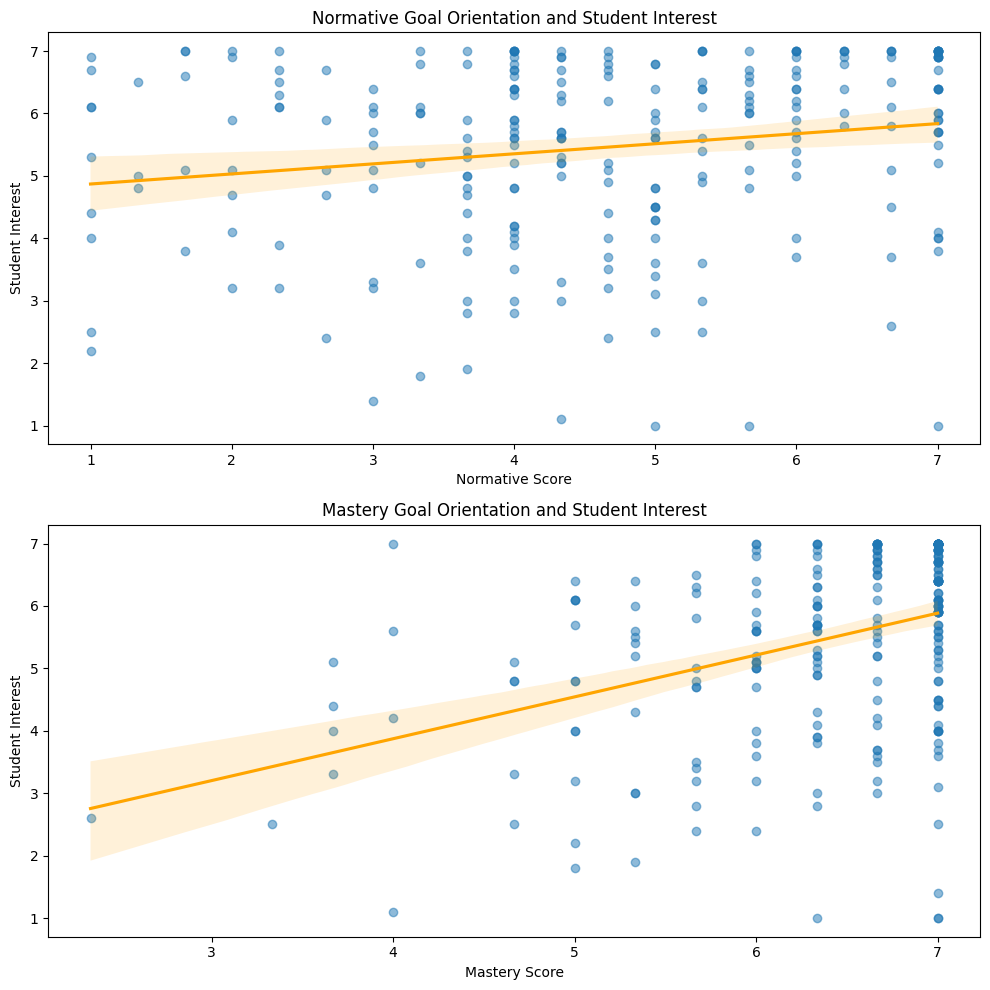

In [17]:


# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # 2 rows, 1 column

# First subplot
sns.regplot(x='Normative_score', y='Interest_mean', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'orange'}, ax=axes[0])  # Add regression line
axes[0].set_title('Normative Goal Orientation and Student Interest')
axes[0].set_xlabel('Normative Score')
axes[0].set_ylabel('Student Interest')

# Second subplot
sns.regplot(x='Mastery_score', y='Interest_mean', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'orange'}, ax=axes[1])  # Add regression line
axes[1].set_title('Mastery Goal Orientation and Student Interest')
axes[1].set_xlabel('Mastery Score')
axes[1].set_ylabel('Student Interest')

# Adjust layout
plt.tight_layout()

#plt.savefig('achievement_goals_interest_boxplots.pdf')

#### Exam Scores 

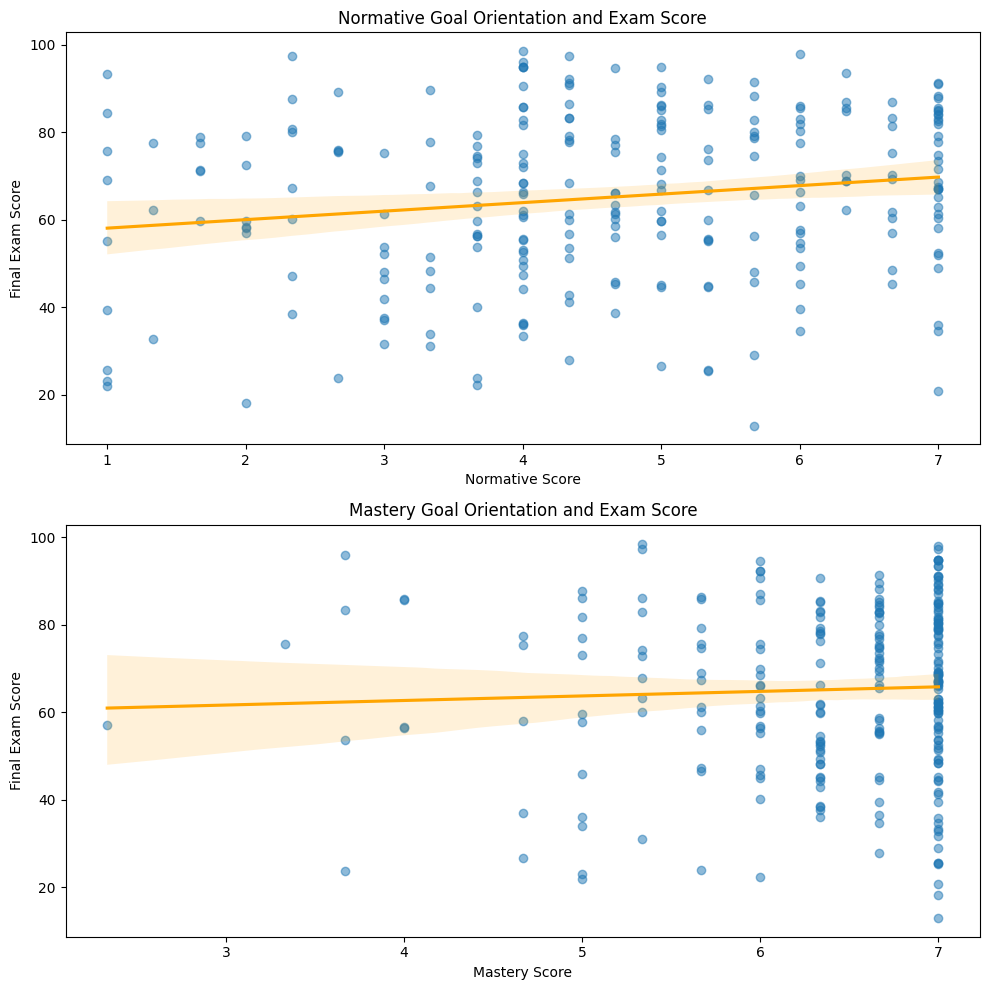

In [18]:
#scatterplot for normative and final exam score 

fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # 2 rows, 1 column

# First subplot
sns.regplot(x='Normative_score', y='Final_Exam_Score', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'orange'}, ax=axes[0])  # Add regression line
axes[0].set_title('Normative Goal Orientation and Exam Score')
axes[0].set_xlabel('Normative Score')
axes[0].set_ylabel('Final Exam Score')

# Second subplot
sns.regplot(x='Mastery_score', y='Final_Exam_Score', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'orange'}, ax=axes[1])  # Add regression line
axes[1].set_title('Mastery Goal Orientation and Exam Score')
axes[1].set_xlabel('Mastery Score')
axes[1].set_ylabel('Final Exam Score')

# Adjust layout
plt.tight_layout()

#plt.savefig('achievement_goals_exam_boxplots.pdf')



In [19]:
print(df.columns)

Index(['One of my goals is to show others that I’m good at my class work.',
       'I am striving to understand the content of this course as thoroughly as possible.',
       'My goal is to learn as much as possible.',
       'One of my goals is to have other students in my class think I am good at my class work.',
       'My aim is to perform well relative to other students.',
       'My aim is to completely master the material presented in this class.',
       'One of my goals is to show others that class work is easy for me.',
       'One of my goals is to look smart in comparison to other students in my class.',
       'My goal is to perform better than the other students.',
       'I aim to look smart compared to others in my class.',
       'I am striving to do well compared to other students.',
       'I think what we are learning in this class is interesting.',
       'I think I will be able to use what I learn in this course in other courses.',
       'I would recommend this c

# Initial Statistics

## Cronbach's alpha 

In [20]:
# def compute cronbach alpha for a given set of questions
import pingouin as pg

def cronbach_alpha(df, questions):
    q = df[questions]
    return pg.cronbach_alpha(q)[0]

for t, questions in [('Mastery', mastery_questions), ('Normative', normative_questions), ('Appearance', appearance_questions), ('Interest', interest_questions)]:
    print(f'{t}: {cronbach_alpha(df, questions):.2f}')



Mastery: 0.81
Normative: 0.85
Appearance: 0.92
Interest: 0.96


In [21]:
for t, questions in [('CanDoTask', can_do_this_task_questions)]:
    print(f'{t}: {cronbach_alpha(df, questions):.2f}')

CanDoTask: 0.91


In [22]:

for t, questions in [('Read copilot output', copilot_read_output), ('Test copilot output', copilot_test_output)]:
    if len(questions) > 1:
        print(f'{t}: {cronbach_alpha(df, questions):.2f}')

for t, questions in [('Perceptions of copilot', copilot_helped_hindered)]:
    if len(questions) > 1:
        print(f'{t}: {cronbach_alpha(df, questions):.2f}')

#run cronbach alpha for the programming intelligence questions
for t, questions in [('Programming Intelligence Belief/Growth Mindset', progintelligencequestions)]:
    if len(questions) > 1:
        print(f'{t}: {cronbach_alpha(df, questions):.2f}')



Programming Intelligence Belief/Growth Mindset: 0.88


## Descriptive Stats

In [23]:
df['Mastery'] = df[mastery_questions].mean(axis=1)
df['Normative'] = df[normative_questions].mean(axis=1)
df['Appearance'] = df[appearance_questions].mean(axis=1)
df['Interest'] = df[interest_questions].mean(axis=1)
df['ProgIntelligenceBelief'] = df[progintelligencequestions].mean(axis=1)


category_stats = pd.concat([
    df[category].describe()
    for category in ['Mastery', 'Normative', 'Appearance', 'Interest']
], axis=1)
category_stats

,Mastery,Normative,Appearance,Interest
count,256.000000,256.000000,256.000000,256.000000
mean,6.359375,4.630208,2.849219,5.455078
std,0.841836,1.642430,1.479030,1.441450
min,2.333333,1.000000,1.000000,1.000000
25%,6.000000,3.666667,1.600000,4.700000
50%,6.666667,4.666667,2.600000,5.850000
75%,7.000000,6.000000,3.850000,6.700000
max,7.000000,7.000000,7.000000,7.000000


In [24]:
df['ReadCopilotOutput'] = df[copilot_read_output].mean(axis=1)
df['TestCopilotOutput'] = df[copilot_test_output].mean(axis=1)
df['CopilotPerceptions'] = df[copilot_helped_hindered].mean(axis=1)



copilot_stats = pd.concat([
    df[category].describe()
    for category in ['ReadCopilotOutput', 'TestCopilotOutput', 'CopilotPerceptions']
], axis=1)
copilot_stats

,ReadCopilotOutput,TestCopilotOutput,CopilotPerceptions
count,256.000000,256.000000,256.000000
mean,74.492188,68.671875,0.351562
std,21.414123,23.693172,0.864007
min,10.000000,0.000000,-1.000000
25%,67.500000,50.000000,-1.000000
50%,80.000000,70.000000,1.000000
75%,90.000000,80.000000,1.000000
max,100.000000,100.000000,1.000000


## Correlations 

In [25]:
# compute correlations between all categories including final exam score
correlations = df[['Mastery', 'Normative', 'Appearance', 'Interest', 'Prior_Knowledge', 'Final_Exam_Score']].corr()
correlations

,Mastery,Normative,Appearance,Interest,Prior_Knowledge,Final_Exam_Score
Mastery,1.000000,0.264461,0.084006,0.391790,0.103877,0.045758
Normative,0.264461,1.000000,0.560058,0.183777,0.076034,0.166934
Appearance,0.084006,0.560058,1.000000,0.045850,-0.014163,0.046571
Interest,0.391790,0.183777,0.045850,1.000000,0.332707,0.312590
Prior_Knowledge,0.103877,0.076034,-0.014163,0.332707,1.000000,0.217649
Final_Exam_Score,0.045758,0.166934,0.046571,0.312590,0.217649,1.000000


In [26]:
correlations_copilot_hygiene = df[['ReadCopilotOutput', 'TestCopilotOutput', 'CopilotPerceptions', 'Mastery', 'Normative', 'Appearance', 'ProgIntelligenceBelief', 'Final_Exam_Score']].corr()
correlations_copilot_hygiene

,ReadCopilotOutput,TestCopilotOutput,CopilotPerceptions,Mastery,Normative,Appearance,ProgIntelligenceBelief,Final_Exam_Score
ReadCopilotOutput,1.000000,0.601546,0.175011,0.193619,0.110599,-0.032267,-0.260205,0.076286
TestCopilotOutput,0.601546,1.000000,0.199139,0.181313,0.129757,-0.013571,-0.297269,0.078546
CopilotPerceptions,0.175011,0.199139,1.000000,0.168880,0.104868,0.068036,-0.155151,0.122341
Mastery,0.193619,0.181313,0.168880,1.000000,0.264461,0.084006,-0.240868,0.045758
Normative,0.110599,0.129757,0.104868,0.264461,1.000000,0.560058,-0.065004,0.166934
Appearance,-0.032267,-0.013571,0.068036,0.084006,0.560058,1.000000,0.017032,0.046571
ProgIntelligenceBelief,-0.260205,-0.297269,-0.155151,-0.240868,-0.065004,0.017032,1.000000,-0.338189
Final_Exam_Score,0.076286,0.078546,0.122341,0.045758,0.166934,0.046571,-0.338189,1.000000


In [27]:
# do correlations and include significance

import scipy.stats as stats

def make_correlation_matrix(df, columns):
    corr = df[columns].corr()
    p_values = pd.DataFrame()
    for x in columns:
        p_values[x] = [stats.pearsonr(df[x], df[y])[1] for y in columns]
    p_values = p_values.set_index(columns)
    #p_values.columns = columns
    return corr, p_values

corr, p_values = make_correlation_matrix(df, ['Mastery', 'Normative', 'Appearance', 'Interest', 'ProgIntelligenceBelief', 'Final_Exam_Score'])

pd.options.display.float_format = '{:.10f}'.format
display(p_values)

,,,,,
Mastery,Normative,Appearance,Interest,ProgIntelligenceBelief,Final_Exam_Score
0.0000000000,0.0000180899,0.1802830088,0.0000000001,0.0000992211,0.4660456927
0.0000180899,0.0000000000,0.0000000000,0.0031652720,0.3001699167,0.0074356583
0.1802830088,0.0000000000,0.0000000000,0.4651525267,0.7862329765,0.4581496927
0.0000000001,0.0031652720,0.4651525267,0.0000000000,0.0000000000,0.0000003300
0.0000992211,0.3001699167,0.7862329765,0.0000000000,0.0000000000,0.0000000287
0.4660456927,0.0074356583,0.4581496927,0.0000003300,0.0000000287,0.0000000000


In [28]:
#correlations with copilot info
corr_copilot, p_values_copilot = make_correlation_matrix(df, ['ReadCopilotOutput', 'TestCopilotOutput','CopilotPerceptions', 'Mastery', 'Normative', 'Appearance', 'ProgIntelligenceBelief', 'Final_Exam_Score'])
display(p_values_copilot)

Empty DataFrame
Columns: []
Index: [(0.0, 1.3850532973570797e-26, 0.004982163943229231, 0.0018567086356620162, 0.0773368655633164, 0.6073354946174063, 2.489474084070542e-05, 0.22384464739073792), (1.3850532973570797e-26, 0.0, 0.0013611006648626967, 0.003603045811393335, 0.038010881615348616, 0.8289283909879852, 1.2792468235740428e-06, 0.21037997228720356), (0.004982163943229231, 0.0013611006648626967, 0.0, 0.006762213287795576, 0.09407173143146995, 0.2781417738943892, 0.01294294625687952, 0.05055619986217847), (0.0018567086356620162, 0.003603045811393335, 0.006762213287795576, 0.0, 1.8089900154169576e-05, 0.1802830088165465, 9.922113772595952e-05, 0.46604569269896445), (0.0773368655633164, 0.038010881615348616, 0.09407173143146995, 1.8089900154169576e-05, 0.0, 1.539303765959648e-22, 0.3001699167010438, 0.007435658317240033), (0.6073354946174063, 0.8289283909879852, 0.2781417738943892, 0.1802830088165465, 1.539303765959648e-22, 0.0, 0.7862329764731246, 0.4581496927279159), (2.489474084070542e-05, 1.2792468235740428e-06, 0.01294294625687952, 9.922113772595952e-05, 0.3001699167010438, 0.7862329764731246, 0.0, 2.8746527097551548e-08), (0.22384464739073792, 0.21037997228720356, 0.05055619986217847, 0.46604569269896445, 0.007435658317240033, 0.4581496927279159, 2.8746527097551548e-08, 0.0)]

# Regression Setup

In [29]:
#print df cols 
df.columns

Index(['One of my goals is to show others that I’m good at my class work.',
       'I am striving to understand the content of this course as thoroughly as possible.',
       'My goal is to learn as much as possible.',
       'One of my goals is to have other students in my class think I am good at my class work.',
       'My aim is to perform well relative to other students.',
       'My aim is to completely master the material presented in this class.',
       'One of my goals is to show others that class work is easy for me.',
       'One of my goals is to look smart in comparison to other students in my class.',
       'My goal is to perform better than the other students.',
       'I aim to look smart compared to others in my class.',
       'I am striving to do well compared to other students.',
       'I think what we are learning in this class is interesting.',
       'I think I will be able to use what I learn in this course in other courses.',
       'I would recommend this c

### Center Columns 

In [30]:
#center all columns that are not binary
centered_cols = []
for col in df.columns:
    if df[col].nunique() > 2:
        df[col] = df[col] - df[col].mean()
        centered_cols.append(col)


### Checking Assumptions 

Check assumptions of 
- constant variance
- normal residuals/errors: done 
- outliers: done 
- leverage, 
- influential cases, 
- VIF: done 
- Homoscedasticity: done 

#focus on:

- leverage: done 
- influential cases: Cook's 

#### KS Test fails so we perform Power Transformation. 

In [31]:
pt = PowerTransformer()

fit_transformed = pt.fit_transform(df[centered_cols])

df[centered_cols] = fit_transformed

#dfcopy = df.copy()

#### VIF function

In [32]:
#given equation of the form 'Q("Final Exam Score") ~ Mastery*Normative*Appearance*Prior_Knowledge' # CSMajor + SelfEfficacy + ProgIntelligenceBelief' and data, return the VIF for each variable in the equation
#calculate VIF for each variable in the regression equation without using VIF package; do from scratch using R^2 values from output of ols(eq, data).fit().summary()
def check_vif(regression_eq_string, data):
    # Extracting the independent variables from the regression equation
    #if 1 or fewer independent variables, return an empty dictionary
    if regression_eq_string.count('+') < 1:
        return {}

    full_model = ols(formula=regression_eq_string, data=data).fit()
    predictors = full_model.model.exog_names[1:]  # Skip the intercept

    vif_dict = {}
    
    # For each predictor, regress it on the other predictors and compute R^2
    for predictor in predictors:
        other_predictors = [p for p in predictors if p != predictor]
        # Create a regression equation where the current predictor is the dependent variable
        regression_eq = f'{predictor} ~ {" + ".join(other_predictors)}'
        
        partial_model = ols(formula=regression_eq, data=data).fit()
        
        r_squared = partial_model.rsquared
        
        # Calculate the VIF for the predictor
        vif = 1 / (1 - r_squared)
        vif_dict[predictor] = vif

    return vif_dict

#### Outliers function

-differ substantially from the main trend of the data; have large residuals
-Standardized residuals are the residuals divided by the standard
deviation; cause for concern are any whose absolute value is greater
than 3, more than 1% greater than 2.5, or more than 5% greater than 2
(rstandard, outlierTest)

In [33]:
# Create a sample dataset


def check_outliers(model, data):
    # Get residuals from the model
    residuals = model.resid
    
    # Calculate the standard deviation of residuals
    std_dev = np.std(residuals)
    
    # Standardize residuals
    standardized_residuals = residuals / std_dev
    
    # Find positional indices for outliers based on the conditions
    outliers_abs_gt_3 = np.where(np.abs(standardized_residuals) > 3)[0]
    outliers_abs_gt_2_5 = np.where(np.abs(standardized_residuals) > 2.5)[0]
    outliers_abs_gt_2 = np.where(np.abs(standardized_residuals) > 2)[0]
    
    # Find indices that meet the percentage-based criteria
    percent_abs_gt_2_5 = len(outliers_abs_gt_2_5) / len(standardized_residuals) * 100
    percent_abs_gt_2 = len(outliers_abs_gt_2) / len(standardized_residuals) * 100

    # Check if more than 1% of residuals are > 2.5 or more than 5% > 2
    if percent_abs_gt_2_5 > 1:
        flagged_outliers_2_5 = outliers_abs_gt_2_5
    else:
        flagged_outliers_2_5 = []

    if percent_abs_gt_2 > 5:
        flagged_outliers_2 = outliers_abs_gt_2
    else:
        flagged_outliers_2 = []

    #make a dictionary of the outliers
    outlier_dict = {
        'outliers_abs_gt_3': outliers_abs_gt_3,
        'outliers_abs_gt_2_5': flagged_outliers_2_5,
        'outliers_abs_gt_2': flagged_outliers_2
    }
    print(outlier_dict)
    
    # Combine all unique positional indices of outliers and ensure they're integers
    all_outlier_indices = np.unique(np.concatenate([outliers_abs_gt_3, flagged_outliers_2_5, flagged_outliers_2])).astype(int)

    # Map positional indices to the actual index labels in the DataFrame
    outlier_labels = data.index[all_outlier_indices]
    
    return outlier_labels.tolist()


#### Leverage function

In [34]:
def check_high_leverage_points(model, data):
    """
    Identifies high-leverage points in a regression model based on leverage scores.
    
    Parameters:
    - model: A fitted statsmodels regression model.
    - data: A pandas DataFrame containing the data (including the predictors).
    
    Returns:
    - List of index labels for high-leverage points, corresponding to DataFrame indices.
    """
    # Calculate leverage (hat values)
    leverage = model.get_influence().hat_matrix_diag
    
    # Define threshold values
    k = model.model.exog.shape[1] - 1  # Number of predictors (excluding intercept)
    n = data.shape[0]                  # Number of observations
    average_leverage = (k + 1) / n
    high_leverage_threshold_2x = 2 * average_leverage
    high_leverage_threshold_3x = 3 * average_leverage
    
    # Identify high-leverage points
    high_leverage_indices = np.where(
        (leverage > high_leverage_threshold_2x) | 
        (leverage > high_leverage_threshold_3x)
    )[0]  # Get positional indices of high leverage points
    
    # Map positional indices to the actual index labels in the DataFrame
    high_leverage_labels = data.index[high_leverage_indices]
    
    return high_leverage_labels.tolist()

# Example usage:
# Assuming `model` is a fitted statsmodels OLS model and `data` is your DataFrame
# high_leverage_points = check_high_leverage_points(model, data)
# print("High leverage points:", high_leverage_points)

# Dropping high leverage points
# data_cleaned = data.drop(index=high_leverage_points)


## Table Displays & Assumption checking

In [35]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Function to add significance markers based on p-value thresholds
def add_significance_markers(row):
    p_value = row['p-value']
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Function to apply bold formatting to significant predictors 
def highlight_significant(s):
    """
    Make all significant predictors bold and ensure that they maintain their three decimal places
    """
    p_values = s['p-value'].astype(float)
    if p_values < 0.05:
        return ['font-weight: bold'] * len(s)
    else:
        return [''] * len(s)

def style_df(model):
    # Add significance markers to the index column of the summary table
    summary_df = pd.DataFrame({
        'Coefficient': model.params,
        'Standard Error': model.bse,
        't-value': model.tvalues,
        'p-value': model.pvalues
    })
    summary_df.index = summary_df.index.to_series().apply(lambda x: x + add_significance_markers(summary_df.loc[x]))
    styled_summary_df = summary_df.style.format("{:.3f}").apply(highlight_significant, axis=1)
    return styled_summary_df


def display_model_info(equation, df, print_vif=False, rsq_only=False, rsqdict=None):
    print("Equation: ", equation)
    model = ols(equation, data=df).fit()
    styled_summary_df = style_df(model)
    #if rsqdict is not None, add the model's R^2 to the dictionary. Equation is the key, R^2 is the value
    if rsqdict is not None:
        rsqdict[equation] = model.rsquared_adj
    if rsq_only:
        print(f"Model adj. R^2: {model.rsquared_adj:.3f}")
        return
    display(styled_summary_df)

    print(f"Model adj. R^2: {model.rsquared_adj:.3f}, R^2: {model.rsquared:.3f}, N. obs: {model.nobs:.0f}, F-statistic: {model.fvalue:.3f}")


    ### Checking VIF ###
    if print_vif:
        print("\nVIF of each factor:")

    vif_values = check_vif(equation, df)
    high_VIF_factors = []
    for variable, vif in vif_values.items():
        if print_vif:
            print(f"{variable}: {vif:.2f}")
        # if vif > 10, add to a list of variables with high VIF
        if vif > 10:
            high_VIF_factors.append(variable)

    #print variables with high VIF
    if len(high_VIF_factors) > 0:
        print("\n^^^^^^^^^^^^^^^^Variables with high VIF:")
        print(high_VIF_factors)
    else:
        print("\nNo variables with high VIF")
    
    ### Durbin-Watson test for independent errors/autocorrelation ###
    durbinwatsonval = sm.stats.stattools.durbin_watson(model.resid)
    if (durbinwatsonval > 1) and (durbinwatsonval < 3):
        print("Durbin-Watson test for autocorrelation: Nothing significant")
    else:
        print("^^^^^^^^^^^^^^^^Durbin-Watson test for autocorrelation: Significant")

    ### kstest for normality of residuals/normally distributed errors###
    kstestval = stats.kstest(model.resid, 'norm', alternative='less')
    if kstestval[1] > 0.05:
        print("Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant")
    else: 
        print("^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation")
        print(kstestval)

    ### Checking for Homoscedasticity ###
    breuschpaganval = sms.diagnostic.het_breuschpagan(model.resid, model.model.exog)
    if breuschpaganval[1] > 0.05:
        print("Breusch-Pagan test for homoscedasticity: Nothing significant")
    else:
        print("^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant")
        print(breuschpaganval)
    
    ### Checking for outliers ###
    #test = model.outlier_test()
    #outliers = test[test['unadj_p'] < 0.05].index
    
    outliers = check_outliers(model, df)
    print('^^^^^^^^^^^^^^^^Outliers: ', list(outliers))

    #create instance of influence
    influence = model.get_influence()

    #leverage (hat values)
    #leverage = model.hat_matrix_diag

    #Cook's D values (and p-values) as tuple of arrays
    cooks_d = influence.cooks_distance

    #print("Cooks D values: ", cooks_d[0])
    #number of points with high cooks d values
    high_cooks_d = np.where(cooks_d[0] > 1)[0]

    print("High Cook's D values: ", high_cooks_d)
    print("Cooks D values: ", cooks_d[0][high_cooks_d])
    print("Cooks D p-values: ", cooks_d[1][high_cooks_d])
    
    ### Calculate leverage values ###
    highleverage = check_high_leverage_points(model,df)
    print('^^^^^^^^^^^^^^^^High leverage points: ', highleverage)
    
    #influential points 
    #influential_points = influence.get_influence()

    
    #if there are outliers, re-run the model without them


    if len(outliers) > 0:
        print("Re-running model without outliers")
        dfcopy = df.copy()
        df_no_outliers = dfcopy.drop(outliers)
        model_no_outliers = ols(equation, data=df_no_outliers).fit()
        styled_summary_df_no_outliers = style_df(model_no_outliers)
        display(styled_summary_df_no_outliers)
        print(f"Model adj. R^2: {model_no_outliers.rsquared_adj:.3f}, R^2: {model_no_outliers.rsquared:.3f}, N. obs: {model_no_outliers.nobs:.0f}, F-statistic: {model_no_outliers.fvalue:.3f}")
    
    
    #if there are high leverage points, re-run the model without them
    if len(highleverage) > 0:
        print("Re-running model without high leverage points")
        dfcopy = df.copy()
        df_no_highleverage = dfcopy.drop(highleverage)
        model_no_highleverage = ols(equation, data=df_no_highleverage).fit()
        styled_summary_df_no_highleverage = style_df(model_no_highleverage)
        display(styled_summary_df_no_highleverage)
        print(f"Model adj. R^2: {model_no_highleverage.rsquared_adj:.3f}, R^2: {model_no_highleverage.rsquared:.3f}, N. obs: {model_no_highleverage.nobs:.0f}, F-statistic: {model_no_highleverage.fvalue:.3f}")
    


    """
    #now try after removing both outliers and high leverage points
    if len(outliers) > 0 and len(highleverage) > 0:
        print("Re-running model without outliers and high leverage points")
        dfcopy = df.copy()
        #make list that is the union of outliers and high leverage points
        outliers_highleverage = list(set(outliers) | set(highleverage))
        df_no_outliers_highleverage = df_no_outliers.drop(outliers_highleverage)
        model_no_outliers_highleverage = ols(equation, data=df_no_outliers_highleverage).fit()
        styled_summary_df_no_outliers_highleverage = style_df(model_no_outliers_highleverage)
        display(styled_summary_df_no_outliers_highleverage)
        print(f"Model adj. R^2: {model_no_outliers_highleverage.rsquared_adj:.3f}, R^2: {model_no_outliers_highleverage.rsquared:.3f}, N. obs: {model_no_outliers_highleverage.nobs:.0f}, F-statistic: {model_no_outliers_highleverage.fvalue:.3f}")
    """

    return model


def display_anova(model1,model2): 
    print("Displaying ANOVA results:")
    print("model1: ", model1.model.formula)
    print("model2: ", model2.model.formula)
    anova_results = anova_lm(model1, model2)
    display(anova_results)

    # print apa inline format e.g., f(1, 100) = 1.23, p = 0.05
    print(f"F({anova_results.df_diff[1]}, {anova_results.df_resid[1]}) = {anova_results.F[1]:.2f}, p = {anova_results['Pr(>F)'][1]:.2f}")
    if anova_results['Pr(>F)'][1] < 0.05:
        print("NOTE: ANOVA The difference between models is significant.")

## Function for Stepwise Regression

In [36]:
def stepwise_selection(data, possible_predictors, dep_var, check_anova_before_adding=False, display_best_model=True):
    #dict to store the best regression model for each number of predictors. key is number of predictors, value is a tuple of the best model string equation and the model's adjusted R^2 value
    best_models = {}
    predictors = []
    best_model = None
    best_adjr2 = -1.0
    best_model_equation_string = None

    #while there are still possible predictors to consider
    while len(possible_predictors) > 0:
        best_predictor = None
        for predictor in possible_predictors:
            #create a new model with the current predictors and the possible predictor
            model_eq_str = f"{dep_var} ~ {' + '.join(predictors + [predictor])}"
            model = ols(model_eq_str, data).fit()
            if model.rsquared_adj > best_adjr2:
                
                if check_anova_before_adding and best_model is not None:
                    #check if adding the predictor significantly improves the model
                    anova_results = anova_lm(best_model, model)
                    if anova_results['Pr(>F)'][1] < 0.05:
                        print(f"Adding {predictor} significantly improves the model significantly. P val: {anova_results['Pr(>F)'][1]}")
                        print("models being compared: " + best_model.model.formula + " and " + model.model.formula)
                        best_predictor = predictor
                        best_model = model
                        best_adjr2 = model.rsquared_adj
                        best_models[len(predictors) + 1] = (model_eq_str, best_adjr2)
                if best_model is None: #if best model is None, then we are on the first iteration and we should add the predictor
                    best_predictor = predictor
                    best_model = model
                    best_adjr2 = model.rsquared_adj
                    best_models[len(predictors) + 1] = (model_eq_str, best_adjr2)
                elif not check_anova_before_adding:
                    best_predictor = predictor
                    best_model = model
                    best_adjr2 = model.rsquared_adj
                    best_models[len(predictors) + 1] = (model_eq_str, best_adjr2)

        if best_predictor is None:
            break
        
        #print("best equation: ", best_model_equation_string)
        #add the best predictor to the list of predictors
        predictors.append(best_predictor)
        best_model_equation_string = f"{dep_var} ~ {' + '.join(predictors)}"

        #remove the best predictor from the list of possible predictors
        possible_predictors.remove(best_predictor)
    
    #Add main effects from any interaction terms to the best model
    main_effects = set()
    for predictor in predictors:
        if ':' in predictor:  # If it's an interaction term
            # Split the interaction term and add each part as a main effect
            main_effects.update(predictor.split(':'))

    # Ensure all main effects are included in the final model
    for effect in main_effects:
        if effect not in predictors:
            predictors.append(effect)  # Add missing main effect

    # Update the final model equation string with all predictors
    best_model_equation_string = f"{dep_var} ~ {' + '.join(predictors)}"
    #print("Best model equation string: ", best_model_equation_string)
    best_model = ols(best_model_equation_string, data).fit()

    if display_best_model: 
        display_model_info(best_model_equation_string, data)

    return best_model, best_model_equation_string, best_models

In [37]:
def blockwise_selection(data, possible_blocks, base_model, check_anova_before_adding=False, display_best_model=True, display_all_models=False):
    # Dictionary to store the best model at each step. Key is number of blocks added, value is (equation, adj R^2)
    best_models = {}
    current_model_eq = base_model
    best_model = ols(current_model_eq, data).fit()
    best_adjr2 = best_model.rsquared_adj

    # Iterate over blocks to find the best sequence of additions
    for block in possible_blocks:
        new_model_eq = f"{current_model_eq} {block}"
        new_model = ols(new_model_eq, data).fit()
        if display_all_models:
            display_model_info(new_model_eq, data, rsq_only=False)
        if new_model.rsquared_adj > best_adjr2:
            if check_anova_before_adding:
                # Compare models using ANOVA to ensure significance
                anova_results = anova_lm(best_model, new_model)
                if anova_results['Pr(>F)'][1] < 0.05:
                    print(f"----------------------Adding block '{block}' improves the model significantly.")
                    current_model_eq = new_model_eq
                    best_model = new_model
                    best_adjr2 = new_model.rsquared_adj
                    best_models[len(best_models) + 1] = (current_model_eq, best_adjr2)
                    
            else:
                # If no ANOVA check, accept the block directly
                print(f"Adding block '{block}' without ANOVA check.")
                current_model_eq = new_model_eq
                best_model = new_model
                best_adjr2 = new_model.rsquared_adj
                best_models[len(best_models) + 1] = (current_model_eq, best_adjr2)

    if display_best_model:
        print("The best blockwise model is below: ")
        display_model_info(current_model_eq, data)

    return best_model, current_model_eq, best_models



# Achievement Goals Replications

In [38]:
achievement_goals_replication_base_vars = ['Mastery', 'Normative', 'Appearance', 'Prior_Knowledge'] 

# Generate all interaction terms (pairwise and higher-order)
interaction_terms = []

# Loop over interaction orders (from 2 to the total number of variables)
for r in range(2, len(achievement_goals_replication_base_vars) + 1):
    for combo in combinations(achievement_goals_replication_base_vars, r):
        interaction_terms.append(':'.join(combo))

achievement_goals_replication_vars = achievement_goals_replication_base_vars + interaction_terms

#blockwise var interactions 

priorexpblock = '+ Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge'
betweenachievementsblock = '+ Mastery:Appearance + Normative:Appearance + Mastery:Normative' 
threewayinteractionsblock = '+ Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge'

possible_blocks = [priorexpblock, betweenachievementsblock, threewayinteractionsblock]

display_nonsignificant_tables = True #for printing tables to add nonsignificant ones to the paper. Set to false when not needed so that notebook doesn't become too cumbersome. 

## Copilot Behaviors and Sentiments 

### GenAI Helps

Both had low adj R^2 overall. 

#### GenAI Helps Problem Solving

Base: Model adj. R^2: 0.060, R^2: 0.075, N. obs: 251, F-statistic: 5.002

Significant: Mastery**	0.306	0.103	2.970	0.003

No significant improvement from blockwise/stepwise

In [39]:
base_model_eq = 'GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)


Equation:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.035,0.087,-0.407,0.684
Mastery**,0.180,0.065,2.785,0.006
Normative,0.145,0.078,1.858,0.064
Appearance,0.027,0.075,0.362,0.718
Prior_Knowledge,0.078,0.123,0.632,0.528


Model adj. R^2: 0.063, R^2: 0.078, N. obs: 251, F-statistic: 5.224

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.039,0.087,-0.441,0.660
Mastery**,0.180,0.065,2.779,0.006
Normative*,0.157,0.080,1.976,0.049
Appearance,0.016,0.076,0.213,0.832
Prior_Knowledge,0.086,0.124,0.698,0.486


Model adj. R^2: 0.066, R^2: 0.081, N. obs: 249, F-statistic: 5.359


In [40]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'GenAIHelpsProblemSolving', check_anova_before_adding=True, display_best_model=True)

Adding Normative significantly improves the model significantly. P val: 0.007508243186155634
models being compared: GenAIHelpsProblemSolving ~ Mastery and GenAIHelpsProblemSolving ~ Mastery + Normative
Equation:  GenAIHelpsProblemSolving ~ Mastery + Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.000,0.060,-0.000,1.000
Mastery**,0.187,0.063,2.970,0.003
Normative**,0.170,0.063,2.695,0.008


Model adj. R^2: 0.076, R^2: 0.083, N. obs: 256, F-statistic: 11.477

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 225, 245, 274, 352, 356, 377, 438, 441, 446, 467, 478]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.007,0.061,-0.107,0.915
Mastery,0.132,0.068,1.932,0.054
Normative**,0.218,0.072,3.042,0.003


Model adj. R^2: 0.076, R^2: 0.083, N. obs: 244, F-statistic: 10.963


In [41]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.042,0.087,-0.485,0.628
Mastery**,0.257,0.089,2.892,0.004
Normative,-0.017,0.109,-0.153,0.878
Appearance,0.014,0.102,0.134,0.894
Prior_Knowledge,0.078,0.122,0.635,0.526
Mastery:Prior_Knowledge,-0.146,0.128,-1.138,0.256
Normative:Prior_Knowledge*,0.314,0.156,2.019,0.045
Appearance:Prior_Knowledge,0.020,0.149,0.131,0.896


Model adj. R^2: 0.077, R^2: 0.103, N. obs: 251, F-statistic: 4.000

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [105, 171, 281, 283, 347, 355, 438, 442, 454]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.043,0.088,-0.491,0.624
Mastery*,0.223,0.090,2.471,0.014
Normative,0.015,0.110,0.134,0.894
Appearance,0.005,0.103,0.049,0.961
Prior_Knowledge,0.094,0.123,0.761,0.447
Mastery:Prior_Knowledge,-0.116,0.130,-0.898,0.370
Normative:Prior_Knowledge*,0.412,0.165,2.494,0.013
Appearance:Prior_Knowledge,-0.089,0.158,-0.563,0.574


Model adj. R^2: 0.091, R^2: 0.117, N. obs: 242, F-statistic: 4.439
Equation:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.074,0.096,-0.776,0.438
Mastery,0.120,0.070,1.713,0.088
Normative*,0.216,0.087,2.489,0.013
Appearance,-0.008,0.078,-0.099,0.922
Prior_Knowledge,0.064,0.123,0.524,0.601
Mastery:Appearance,0.025,0.076,0.323,0.747
Normative:Appearance,0.128,0.070,1.843,0.067
Mastery:Normative,-0.096,0.077,-1.243,0.215


Model adj. R^2: 0.071, R^2: 0.097, N. obs: 251, F-statistic: 3.733

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 105, 116, 171, 193, 281, 283, 332, 355, 376, 438, 449, 454, 464, 467, 511, 533]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.090,0.099,-0.909,0.364
Mastery,0.122,0.073,1.661,0.098
Normative*,0.224,0.093,2.396,0.017
Appearance,-0.062,0.084,-0.745,0.457
Prior_Knowledge,0.051,0.128,0.402,0.688
Mastery:Appearance,0.033,0.081,0.408,0.684
Normative:Appearance,0.121,0.076,1.588,0.114
Mastery:Normative,-0.011,0.085,-0.134,0.893


Model adj. R^2: 0.064, R^2: 0.092, N. obs: 234, F-statistic: 3.271
Equation:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.037,0.090,-0.411,0.681
Mastery*,0.173,0.074,2.350,0.020
Normative,0.151,0.084,1.796,0.074
Appearance,0.005,0.079,0.068,0.946
Prior_Knowledge,-0.010,0.143,-0.070,0.944
Mastery:Normative:Appearance,0.006,0.064,0.089,0.929
Mastery:Normative:Prior_Knowledge,0.033,0.120,0.271,0.787
Mastery:Appearance:Prior_Knowledge,0.074,0.120,0.613,0.540
Normative:Appearance:Prior_Knowledge,0.132,0.100,1.326,0.186


Model adj. R^2: 0.063, R^2: 0.093, N. obs: 251, F-statistic: 3.096

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [100, 105, 116, 122, 127, 171, 193, 209, 234, 255, 281, 283, 332, 347, 355, 363, 376, 423, 449, 464, 467, 502, 511, 528]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.001,0.095,0.016,0.987
Mastery**,0.237,0.078,3.039,0.003
Normative,0.110,0.089,1.231,0.220
Appearance,-0.019,0.084,-0.229,0.819
Prior_Knowledge,-0.038,0.153,-0.246,0.806
Mastery:Normative:Appearance,-0.037,0.073,-0.505,0.614
Mastery:Normative:Prior_Knowledge,0.143,0.140,1.020,0.309
Mastery:Appearance:Prior_Knowledge,0.010,0.142,0.068,0.946
Normative:Appearance:Prior_Knowledge,0.094,0.116,0.808,0.420


Model adj. R^2: 0.058, R^2: 0.092, N. obs: 227, F-statistic: 2.753
The best blockwise model is below: 
Equation:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.035,0.087,-0.407,0.684
Mastery**,0.180,0.065,2.785,0.006
Normative,0.145,0.078,1.858,0.064
Appearance,0.027,0.075,0.362,0.718
Prior_Knowledge,0.078,0.123,0.632,0.528


Model adj. R^2: 0.063, R^2: 0.078, N. obs: 251, F-statistic: 5.224

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.039,0.087,-0.441,0.660
Mastery**,0.180,0.065,2.779,0.006
Normative*,0.157,0.080,1.976,0.049
Appearance,0.016,0.076,0.213,0.832
Prior_Knowledge,0.086,0.124,0.698,0.486


Model adj. R^2: 0.066, R^2: 0.081, N. obs: 249, F-statistic: 5.359
Displaying ANOVA results:
model1:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,231.258,0.000,NaN,NaN,NaN
1,246.000,231.258,-0.000,-0.000,NaN,NaN


F(-0.0, 246.0) = nan, p = nan


#### GenAI Helps Programming 
Base Model adj. R^2: 0.034, R^2: 0.050, N. obs: 251, F-statistic: 3.229

No significant factors 

Adding blockwise prior knowledge interactions improved model significantly. 
GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Model adj. R^2: 0.055, R^2: 0.082, N. obs: 251, F-statistic: 3.098

Normative:Prior_Knowledge**	0.338	0.123	2.759	0.006

In [42]:
base_model_eq = 'GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)


Equation:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.074,0.088,-0.841,0.401
Mastery,0.078,0.065,1.205,0.229
Normative,0.145,0.079,1.837,0.067
Appearance,0.076,0.076,0.999,0.319
Prior_Knowledge,0.141,0.124,1.135,0.257


Model adj. R^2: 0.045, R^2: 0.060, N. obs: 251, F-statistic: 3.953

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.087,0.088,-0.986,0.325
Mastery,0.076,0.065,1.169,0.244
Normative,0.133,0.080,1.664,0.097
Appearance,0.091,0.077,1.187,0.237
Prior_Knowledge,0.147,0.124,1.180,0.239


Model adj. R^2: 0.045, R^2: 0.061, N. obs: 249, F-statistic: 3.939


In [43]:
_, best_stepwise_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'GenAIHelpsProgramming', check_anova_before_adding=True, display_best_model=True)

Adding Normative:Prior_Knowledge significantly improves the model significantly. P val: 0.0029563923987041708
models being compared: GenAIHelpsProgramming ~ Appearance and GenAIHelpsProgramming ~ Normative:Prior_Knowledge
Equation:  GenAIHelpsProgramming ~ Normative:Prior_Knowledge + Normative + Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.084,0.087,-0.965,0.335
Normative:Prior_Knowledge*,0.309,0.122,2.524,0.012
Normative,0.053,0.087,0.612,0.541
Prior_Knowledge,0.139,0.123,1.137,0.257


Model adj. R^2: 0.065, R^2: 0.076, N. obs: 251, F-statistic: 6.759

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.09686190801172262, pvalue=0.008393543789337762, statistic_location=0.1585730442111252, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 172, 193, 204, 225, 245, 274, 332, 347, 376, 438, 442, 464, 467, 511]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.119,0.091,-1.300,0.195
Normative:Prior_Knowledge,0.242,0.133,1.819,0.070
Normative,0.098,0.098,0.996,0.320
Prior_Knowledge,0.188,0.128,1.473,0.142


Model adj. R^2: 0.062, R^2: 0.074, N. obs: 236, F-statistic: 6.209


In [44]:
print("stepwise anova: ")

display_anova(ols(base_model_eq, df).fit(), ols(best_stepwise_model_eq , df).fit())

stepwise anova: 
Displaying ANOVA results:
model1:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  GenAIHelpsProgramming ~ Normative:Prior_Knowledge + Normative + Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,235.187,0.000,NaN,NaN,NaN
1,247.000,231.314,-1.000,3.873,-4.136,NaN


F(-1.0, 247.0) = -4.14, p = nan


In [45]:
_, best_blockwise_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_blockwise_model_eq, df).fit())

Equation:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.088,0.087,-1.005,0.316
Mastery,0.102,0.090,1.138,0.256
Normative,-0.057,0.110,-0.514,0.608
Appearance,0.136,0.103,1.328,0.185
Prior_Knowledge,0.139,0.123,1.126,0.261
Mastery:Prior_Knowledge,-0.038,0.129,-0.291,0.771
Normative:Prior_Knowledge*,0.402,0.157,2.567,0.011
Appearance:Prior_Knowledge,-0.135,0.150,-0.899,0.370


Model adj. R^2: 0.062, R^2: 0.088, N. obs: 251, F-statistic: 3.359

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [105, 171, 281, 283, 347, 355, 438, 442, 454]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.105,0.090,-1.171,0.243
Mastery,0.094,0.092,1.017,0.310
Normative,-0.050,0.112,-0.444,0.657
Appearance,0.149,0.105,1.419,0.157
Prior_Knowledge,0.159,0.126,1.262,0.208
Mastery:Prior_Knowledge,-0.035,0.132,-0.261,0.794
Normative:Prior_Knowledge**,0.446,0.169,2.645,0.009
Appearance:Prior_Knowledge,-0.188,0.161,-1.170,0.243


Model adj. R^2: 0.067, R^2: 0.094, N. obs: 242, F-statistic: 3.482
Equation:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.100,0.097,-1.028,0.305
Mastery,0.106,0.071,1.484,0.139
Normative,0.100,0.088,1.137,0.257
Appearance,0.077,0.079,0.971,0.332
Prior_Knowledge,0.154,0.125,1.235,0.218
Mastery:Appearance,0.042,0.077,0.550,0.583
Normative:Appearance,-0.013,0.070,-0.186,0.852
Mastery:Normative,0.082,0.078,1.055,0.293


Model adj. R^2: 0.044, R^2: 0.070, N. obs: 251, F-statistic: 2.632

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 105, 116, 171, 193, 281, 283, 332, 355, 376, 438, 449, 454, 464, 467, 511, 533]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.138,0.101,-1.367,0.173
Mastery,0.109,0.075,1.453,0.148
Normative,0.111,0.095,1.160,0.247
Appearance,0.064,0.085,0.754,0.452
Prior_Knowledge,0.179,0.130,1.378,0.170
Mastery:Appearance,0.053,0.083,0.642,0.522
Normative:Appearance,-0.025,0.078,-0.318,0.750
Mastery:Normative,0.101,0.087,1.168,0.244


Model adj. R^2: 0.050, R^2: 0.078, N. obs: 234, F-statistic: 2.748
Equation:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.059,0.090,-0.651,0.515
Mastery,0.137,0.074,1.856,0.065
Normative,0.078,0.084,0.925,0.356
Appearance,0.113,0.079,1.438,0.152
Prior_Knowledge,0.098,0.143,0.683,0.495
Mastery:Normative:Appearance,-0.055,0.064,-0.854,0.394
Mastery:Normative:Prior_Knowledge,0.200,0.121,1.653,0.100
Mastery:Appearance:Prior_Knowledge,0.017,0.121,0.138,0.890
Normative:Appearance:Prior_Knowledge,-0.025,0.100,-0.249,0.804


Model adj. R^2: 0.056, R^2: 0.086, N. obs: 251, F-statistic: 2.839

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [100, 105, 116, 122, 127, 171, 193, 209, 234, 255, 281, 283, 332, 347, 355, 363, 376, 423, 449, 464, 467, 502, 511, 528]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.072,0.095,-0.757,0.450
Mastery*,0.174,0.079,2.218,0.028
Normative,0.050,0.090,0.553,0.581
Appearance,0.097,0.085,1.140,0.256
Prior_Knowledge,0.154,0.154,0.998,0.319
Mastery:Normative:Appearance,-0.042,0.073,-0.579,0.563
Mastery:Normative:Prior_Knowledge,0.272,0.141,1.931,0.055
Mastery:Appearance:Prior_Knowledge,0.004,0.143,0.028,0.978
Normative:Appearance:Prior_Knowledge,-0.114,0.117,-0.975,0.331


Model adj. R^2: 0.063, R^2: 0.096, N. obs: 227, F-statistic: 2.887
The best blockwise model is below: 
Equation:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.074,0.088,-0.841,0.401
Mastery,0.078,0.065,1.205,0.229
Normative,0.145,0.079,1.837,0.067
Appearance,0.076,0.076,0.999,0.319
Prior_Knowledge,0.141,0.124,1.135,0.257


Model adj. R^2: 0.045, R^2: 0.060, N. obs: 251, F-statistic: 3.953

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.087,0.088,-0.986,0.325
Mastery,0.076,0.065,1.169,0.244
Normative,0.133,0.080,1.664,0.097
Appearance,0.091,0.077,1.187,0.237
Prior_Knowledge,0.147,0.124,1.180,0.239


Model adj. R^2: 0.045, R^2: 0.061, N. obs: 249, F-statistic: 3.939
Displaying ANOVA results:
model1:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,235.187,0.000,NaN,NaN,NaN
1,246.000,235.187,-0.000,-0.000,NaN,NaN


F(-0.0, 246.0) = nan, p = nan


In [46]:
#anova between best blockwise and best stepwise 

display_anova(ols(best_stepwise_model_eq, df).fit(), ols(best_blockwise_model_eq, df).fit())

Displaying ANOVA results:
model1:  GenAIHelpsProgramming ~ Normative:Prior_Knowledge + Normative + Prior_Knowledge
model2:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,247.000,231.314,0.000,NaN,NaN,NaN
1,246.000,235.187,1.000,-3.873,-4.051,1.000


F(1.0, 246.0) = -4.05, p = 1.00


### Independent Coding Ability & Fundamentals 
All had decent adj r^2 of 0.13-0.16.

Mastery, normative, prior knowledge persistently significant 


#### Confidence in Fundamental Understanding of Programming
How confident or unconfident are you that you have a fundamental understanding of programming concepts?

Base Model adj. R^2: 0.160, R^2: 0.173, N. obs: 251, F-statistic: 12.897

Sig: Mastery, normative, prior knowledge

None of stepwise/blockwise improved the model significantly. 

In [47]:
base_model_eq = 'ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)


Equation:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.246,0.082,-2.982,0.003
Mastery*,0.139,0.061,2.269,0.024
Normative***,0.270,0.074,3.638,0.000
Appearance,-0.051,0.071,-0.711,0.478
Prior_Knowledge***,0.494,0.117,4.228,0.000


Model adj. R^2: 0.163, R^2: 0.176, N. obs: 251, F-statistic: 13.177

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([  9, 133, 206, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 274, 438, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.261,0.081,-3.209,0.002
Mastery*,0.128,0.061,2.101,0.037
Normative***,0.294,0.073,4.007,0.000
Appearance,-0.048,0.070,-0.686,0.493
Prior_Knowledge***,0.530,0.115,4.611,0.000


Model adj. R^2: 0.185, R^2: 0.199, N. obs: 247, F-statistic: 14.985
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.254,0.083,-3.063,0.002
Mastery*,0.137,0.061,2.240,0.026
Normative***,0.259,0.075,3.439,0.001
Appearance,-0.038,0.072,-0.521,0.603
Prior_Knowledge***,0.495,0.117,4.229,0.000


Model adj. R^2: 0.158, R^2: 0.172, N. obs: 249, F-statistic: 12.629


In [48]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'ConfidentFundamental', check_anova_before_adding=True, display_best_model=True)

Adding Prior_Knowledge significantly improves the model significantly. P val: 0.0010544060019498293
models being compared: ConfidentFundamental ~ Appearance and ConfidentFundamental ~ Prior_Knowledge
Adding Mastery:Normative:Prior_Knowledge significantly improves the model significantly. P val: 0.04527274091427038
models being compared: ConfidentFundamental ~ Prior_Knowledge and ConfidentFundamental ~ Prior_Knowledge + Mastery:Normative:Prior_Knowledge


Adding Mastery:Normative:Appearance significantly improves the model significantly. P val: 0.024536048186452795
models being compared: ConfidentFundamental ~ Prior_Knowledge + Mastery:Normative:Prior_Knowledge and ConfidentFundamental ~ Prior_Knowledge + Mastery:Normative:Prior_Knowledge + Mastery:Normative:Appearance
Equation:  ConfidentFundamental ~ Prior_Knowledge + Mastery:Normative:Prior_Knowledge + Mastery:Normative:Appearance + Normative + Mastery + Appearance


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.253,0.085,-2.984,0.003
Prior_Knowledge***,0.475,0.119,3.989,0.000
Mastery:Normative:Prior_Knowledge,0.099,0.088,1.123,0.263
Mastery:Normative:Appearance,0.018,0.058,0.315,0.753
Normative**,0.244,0.078,3.119,0.002
Mastery*,0.140,0.070,2.008,0.046
Appearance,-0.049,0.074,-0.668,0.505


Model adj. R^2: 0.161, R^2: 0.181, N. obs: 251, F-statistic: 8.973

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [0, 17, 100, 105, 116, 127, 171, 193, 281, 287, 332, 347, 355, 376, 438, 449, 454, 464, 467, 511]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.234,0.090,-2.605,0.010
Prior_Knowledge**,0.407,0.125,3.258,0.001
Mastery:Normative:Prior_Knowledge,0.113,0.101,1.115,0.266
Mastery:Normative:Appearance,0.032,0.068,0.473,0.637
Normative**,0.223,0.085,2.621,0.009
Mastery,0.124,0.073,1.703,0.090
Appearance,-0.056,0.078,-0.714,0.476


Model adj. R^2: 0.122, R^2: 0.145, N. obs: 231, F-statistic: 6.349


In [49]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.247,0.083,-2.989,0.003
Mastery**,0.232,0.085,2.730,0.007
Normative,0.179,0.104,1.714,0.088
Appearance,-0.023,0.097,-0.236,0.814
Prior_Knowledge***,0.496,0.117,4.248,0.000
Mastery:Prior_Knowledge,-0.191,0.123,-1.557,0.121
Normative:Prior_Knowledge,0.181,0.149,1.218,0.224
Appearance:Prior_Knowledge,-0.067,0.143,-0.473,0.636


Model adj. R^2: 0.163, R^2: 0.187, N. obs: 251, F-statistic: 7.970

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [105, 171, 281, 283, 347, 355, 438, 442, 454]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.231,0.085,-2.732,0.007
Mastery*,0.224,0.087,2.575,0.011
Normative,0.185,0.106,1.747,0.082
Appearance,-0.037,0.099,-0.374,0.709
Prior_Knowledge***,0.466,0.119,3.912,0.000
Mastery:Prior_Knowledge,-0.196,0.125,-1.567,0.118
Normative:Prior_Knowledge,0.156,0.160,0.977,0.330
Appearance:Prior_Knowledge,-0.027,0.152,-0.178,0.859


Model adj. R^2: 0.144, R^2: 0.168, N. obs: 242, F-statistic: 6.773
Equation:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.285,0.091,-3.113,0.002
Mastery,0.108,0.067,1.623,0.106
Normative***,0.319,0.083,3.851,0.000
Appearance,-0.079,0.074,-1.063,0.289
Prior_Knowledge***,0.480,0.117,4.095,0.000
Mastery:Appearance,-0.084,0.073,-1.153,0.250
Normative:Appearance,0.087,0.066,1.311,0.191
Mastery:Normative,0.007,0.073,0.099,0.921


Model adj. R^2: 0.161, R^2: 0.185, N. obs: 251, F-statistic: 7.862

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 105, 116, 171, 193, 281, 283, 332, 355, 376, 438, 449, 454, 464, 467, 511, 533]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.304,0.095,-3.195,0.002
Mastery,0.089,0.071,1.266,0.207
Normative**,0.288,0.090,3.203,0.002
Appearance,-0.072,0.080,-0.889,0.375
Prior_Knowledge***,0.442,0.123,3.605,0.000
Mastery:Appearance,-0.053,0.078,-0.685,0.494
Normative:Appearance,0.122,0.073,1.664,0.097
Mastery:Normative,0.038,0.082,0.460,0.646


Model adj. R^2: 0.132, R^2: 0.158, N. obs: 234, F-statistic: 6.076
Equation:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.252,0.085,-2.953,0.003
Mastery*,0.140,0.070,2.000,0.047
Normative**,0.246,0.080,3.073,0.002
Appearance,-0.052,0.075,-0.690,0.491
Prior_Knowledge***,0.455,0.136,3.348,0.001
Mastery:Normative:Appearance,0.016,0.061,0.256,0.798
Mastery:Normative:Prior_Knowledge,0.115,0.115,1.006,0.315
Mastery:Appearance:Prior_Knowledge,-0.028,0.115,-0.241,0.810
Normative:Appearance:Prior_Knowledge,0.027,0.095,0.289,0.773


Model adj. R^2: 0.154, R^2: 0.181, N. obs: 251, F-statistic: 6.691

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [100, 105, 116, 122, 127, 171, 193, 209, 234, 255, 281, 283, 332, 347, 355, 363, 376, 423, 449, 464, 467, 502, 511, 528]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.211,0.090,-2.344,0.020
Mastery*,0.163,0.074,2.210,0.028
Normative*,0.191,0.084,2.263,0.025
Appearance,-0.049,0.080,-0.609,0.543
Prior_Knowledge*,0.362,0.145,2.498,0.013
Mastery:Normative:Appearance,0.020,0.069,0.296,0.767
Mastery:Normative:Prior_Knowledge,0.183,0.133,1.377,0.170
Mastery:Appearance:Prior_Knowledge,-0.052,0.135,-0.387,0.699
Normative:Appearance:Prior_Knowledge,0.012,0.110,0.111,0.911


Model adj. R^2: 0.117, R^2: 0.148, N. obs: 227, F-statistic: 4.731
The best blockwise model is below: 
Equation:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.246,0.082,-2.982,0.003
Mastery*,0.139,0.061,2.269,0.024
Normative***,0.270,0.074,3.638,0.000
Appearance,-0.051,0.071,-0.711,0.478
Prior_Knowledge***,0.494,0.117,4.228,0.000


Model adj. R^2: 0.163, R^2: 0.176, N. obs: 251, F-statistic: 13.177

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([  9, 133, 206, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 274, 438, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.261,0.081,-3.209,0.002
Mastery*,0.128,0.061,2.101,0.037
Normative***,0.294,0.073,4.007,0.000
Appearance,-0.048,0.070,-0.686,0.493
Prior_Knowledge***,0.530,0.115,4.611,0.000


Model adj. R^2: 0.185, R^2: 0.199, N. obs: 247, F-statistic: 14.985
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.254,0.083,-3.063,0.002
Mastery*,0.137,0.061,2.240,0.026
Normative***,0.259,0.075,3.439,0.001
Appearance,-0.038,0.072,-0.521,0.603
Prior_Knowledge***,0.495,0.117,4.229,0.000


Model adj. R^2: 0.158, R^2: 0.172, N. obs: 249, F-statistic: 12.629
Displaying ANOVA results:
model1:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,207.823,0.000,NaN,NaN,NaN
1,246.000,207.823,-0.000,-0.000,NaN,NaN


F(-0.0, 246.0) = nan, p = nan


#### Confident Without Copilot 
How confident or unconfident are you that you can: [Do the tasks in CSE8A without Copilot.]

Base Model adj. R^2: 0.153, R^2: 0.167, N. obs: 251, F-statistic: 12.315

Sig: Mastery, normative, prior knowledge

None of stepwise/blockwise improved the model significantly. 

In [50]:
base_model_eq = 'ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)


Equation:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.264,0.083,-3.176,0.002
Mastery**,0.165,0.062,2.676,0.008
Normative**,0.203,0.075,2.708,0.007
Appearance,-0.066,0.072,-0.913,0.362
Prior_Knowledge***,0.533,0.118,4.518,0.000


Model adj. R^2: 0.148, R^2: 0.161, N. obs: 251, F-statistic: 11.844

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.270,0.084,-3.222,0.001
Mastery**,0.164,0.062,2.649,0.009
Normative*,0.190,0.076,2.497,0.013
Appearance,-0.051,0.073,-0.704,0.482
Prior_Knowledge***,0.531,0.118,4.486,0.000


Model adj. R^2: 0.141, R^2: 0.155, N. obs: 249, F-statistic: 11.209


In [51]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'ConfidentWithoutCopilot', check_anova_before_adding=True, display_best_model=True)

Equation:  ConfidentWithoutCopilot ~ Appearance


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.000,0.063,-0.000,1.000
Appearance,0.069,0.063,1.101,0.272


Model adj. R^2: 0.001, R^2: 0.005, N. obs: 256, F-statistic: 1.213

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.10296363930114649, pvalue=0.004066651013296852, statistic_location=0.8216779332689861, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [47, 65, 92, 100, 113, 116, 134, 464, 500]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.015,0.063,-0.236,0.814
Appearance,0.041,0.067,0.616,0.538


Model adj. R^2: -0.003, R^2: 0.002, N. obs: 247, F-statistic: 0.380


In [52]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.261,0.084,-3.128,0.002
Mastery**,0.255,0.086,2.969,0.003
Normative,0.175,0.106,1.661,0.098
Appearance,-0.039,0.098,-0.393,0.694
Prior_Knowledge***,0.536,0.118,4.542,0.000
Mastery:Prior_Knowledge,-0.190,0.124,-1.530,0.127
Normative:Prior_Knowledge,0.057,0.150,0.383,0.702
Appearance:Prior_Knowledge,-0.064,0.144,-0.447,0.655


Model adj. R^2: 0.146, R^2: 0.170, N. obs: 251, F-statistic: 7.109



No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [105, 171, 281, 283, 347, 355, 438, 442, 454]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.236,0.085,-2.764,0.006
Mastery**,0.230,0.088,2.626,0.009
Normative,0.199,0.107,1.860,0.064
Appearance,-0.069,0.100,-0.693,0.489
Prior_Knowledge***,0.494,0.120,4.110,0.000
Mastery:Prior_Knowledge,-0.182,0.126,-1.441,0.151
Normative:Prior_Knowledge,0.017,0.161,0.108,0.914
Appearance:Prior_Knowledge,-0.008,0.153,-0.054,0.957


Model adj. R^2: 0.124, R^2: 0.149, N. obs: 242, F-statistic: 5.862
Equation:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.318,0.092,-3.436,0.001
Mastery*,0.155,0.068,2.295,0.023
Normative*,0.212,0.084,2.538,0.012
Appearance,-0.090,0.075,-1.195,0.233
Prior_Knowledge***,0.532,0.119,4.489,0.000
Mastery:Appearance,-0.009,0.073,-0.121,0.904
Normative:Appearance,0.071,0.067,1.060,0.290
Mastery:Normative,0.048,0.074,0.644,0.520


Model adj. R^2: 0.144, R^2: 0.168, N. obs: 251, F-statistic: 7.018

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 105, 116, 171, 193, 281, 283, 332, 355, 376, 438, 449, 454, 464, 467, 511, 533]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.316,0.094,-3.366,0.001
Mastery,0.136,0.070,1.947,0.053
Normative,0.159,0.089,1.791,0.075
Appearance,-0.055,0.079,-0.694,0.488
Prior_Knowledge***,0.508,0.121,4.189,0.000
Mastery:Appearance,0.042,0.077,0.545,0.587
Normative:Appearance,0.089,0.073,1.233,0.219
Mastery:Normative,0.076,0.081,0.941,0.348


Model adj. R^2: 0.135, R^2: 0.161, N. obs: 234, F-statistic: 6.181
Equation:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.244,0.086,-2.853,0.005
Mastery**,0.207,0.070,2.935,0.004
Normative*,0.184,0.080,2.296,0.023
Appearance,-0.051,0.075,-0.682,0.496
Prior_Knowledge***,0.477,0.136,3.504,0.001
Mastery:Normative:Appearance,-0.062,0.061,-1.010,0.313
Mastery:Normative:Prior_Knowledge,0.030,0.115,0.263,0.793
Mastery:Appearance:Prior_Knowledge,0.135,0.115,1.175,0.241
Normative:Appearance:Prior_Knowledge,0.053,0.095,0.558,0.577


Model adj. R^2: 0.151, R^2: 0.178, N. obs: 251, F-statistic: 6.567

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [100, 105, 116, 122, 127, 171, 193, 209, 234, 255, 281, 283, 332, 347, 355, 363, 376, 423, 449, 464, 467, 502, 511, 528]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.213,0.090,-2.378,0.018
Mastery**,0.208,0.074,2.810,0.005
Normative,0.128,0.084,1.522,0.129
Appearance,-0.017,0.080,-0.208,0.835
Prior_Knowledge**,0.419,0.145,2.892,0.004
Mastery:Normative:Appearance,-0.023,0.069,-0.331,0.741
Mastery:Normative:Prior_Knowledge,0.087,0.132,0.653,0.514
Mastery:Appearance:Prior_Knowledge,0.131,0.135,0.971,0.333
Normative:Appearance:Prior_Knowledge,0.018,0.110,0.161,0.872


Model adj. R^2: 0.126, R^2: 0.157, N. obs: 227, F-statistic: 5.063
The best blockwise model is below: 
Equation:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.264,0.083,-3.176,0.002
Mastery**,0.165,0.062,2.676,0.008
Normative**,0.203,0.075,2.708,0.007
Appearance,-0.066,0.072,-0.913,0.362
Prior_Knowledge***,0.533,0.118,4.518,0.000


Model adj. R^2: 0.148, R^2: 0.161, N. obs: 251, F-statistic: 11.844

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.270,0.084,-3.222,0.001
Mastery**,0.164,0.062,2.649,0.009
Normative*,0.190,0.076,2.497,0.013
Appearance,-0.051,0.073,-0.704,0.482
Prior_Knowledge***,0.531,0.118,4.486,0.000


Model adj. R^2: 0.141, R^2: 0.155, N. obs: 249, F-statistic: 11.209
Displaying ANOVA results:
model1:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,212.090,0.000,NaN,NaN,NaN
1,246.000,212.090,-0.000,-0.000,NaN,NaN


F(-0.0, 246.0) = nan, p = nan


#### Confident You're Learning To Code Yourself 
How confident or unconfident are you that you are learning how to write programs yourself, when using GenAI tools?

Base Model adj. R^2: 0.132, R^2: 0.146, N. obs: 251, F-statistic: 10.512

Very highly sig: Mastery,
Highly sig: Normative**, 
Sig: Prior Knowledge

None of stepwise/blockwise improved the model significantly. 


In [53]:
base_model_eq = 'ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)



Equation:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.111,0.082,-1.352,0.177
Mastery***,0.263,0.061,4.329,0.000
Normative***,0.273,0.074,3.716,0.000
Appearance,-0.100,0.070,-1.413,0.159
Prior_Knowledge*,0.237,0.116,2.048,0.042


Model adj. R^2: 0.173, R^2: 0.186, N. obs: 251, F-statistic: 14.040

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant
(9.588386169369727, 0.047962450236681595, 2.4426569213441027, 0.04733266730687283)
{'outliers_abs_gt_3': array([ 9, 13]), 'outliers_abs_gt_2_5': array([  9,  13, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 31, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.075,0.079,-0.947,0.345
Mastery***,0.270,0.059,4.586,0.000
Normative***,0.291,0.071,4.089,0.000
Appearance,-0.096,0.068,-1.408,0.160
Prior_Knowledge*,0.222,0.112,1.976,0.049


Model adj. R^2: 0.194, R^2: 0.207, N. obs: 248, F-statistic: 15.891
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.116,0.082,-1.406,0.161
Mastery***,0.262,0.061,4.299,0.000
Normative***,0.266,0.075,3.554,0.000
Appearance,-0.091,0.072,-1.265,0.207
Prior_Knowledge*,0.238,0.116,2.046,0.042


Model adj. R^2: 0.167, R^2: 0.180, N. obs: 249, F-statistic: 13.412


In [54]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'ConfidentIndependentProgramming', check_anova_before_adding=True, display_best_model=True)

Adding Mastery:Prior_Knowledge significantly improves the model significantly. P val: 0.013198383719950689
models being compared: ConfidentIndependentProgramming ~ Mastery:Normative and ConfidentIndependentProgramming ~ Mastery:Prior_Knowledge


Equation:  ConfidentIndependentProgramming ~ Mastery:Prior_Knowledge + Mastery + Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.123,0.084,-1.475,0.142
Mastery:Prior_Knowledge,-0.126,0.118,-1.068,0.287
Mastery***,0.395,0.081,4.850,0.000
Prior_Knowledge*,0.273,0.118,2.311,0.022


Model adj. R^2: 0.131, R^2: 0.142, N. obs: 251, F-statistic: 13.572

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant
(8.05057617589367, 0.044977931433574064, 2.72826649012813, 0.04462020511427409)
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([  9,  13, 230, 231]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 31, 492, 494]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [0, 23, 127, 177, 355, 423, 441, 464, 477, 479, 499, 533]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.096,0.082,-1.161,0.247
Mastery:Prior_Knowledge,-0.107,0.116,-0.920,0.359
Mastery***,0.396,0.080,4.928,0.000
Prior_Knowledge*,0.265,0.116,2.286,0.023


Model adj. R^2: 0.141, R^2: 0.152, N. obs: 247, F-statistic: 14.491
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.163,0.087,-1.876,0.062
Mastery:Prior_Knowledge,-0.145,0.124,-1.177,0.240
Mastery***,0.410,0.085,4.821,0.000
Prior_Knowledge**,0.319,0.122,2.619,0.009


Model adj. R^2: 0.140, R^2: 0.150, N. obs: 239, F-statistic: 13.874


In [55]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.112,0.082,-1.371,0.172
Mastery***,0.348,0.084,4.132,0.000
Normative,0.178,0.103,1.719,0.087
Appearance,-0.083,0.097,-0.857,0.392
Prior_Knowledge*,0.239,0.116,2.064,0.040
Mastery:Prior_Knowledge,-0.173,0.122,-1.420,0.157
Normative:Prior_Knowledge,0.188,0.147,1.277,0.203
Appearance:Prior_Knowledge,-0.044,0.141,-0.312,0.755


Model adj. R^2: 0.173, R^2: 0.196, N. obs: 251, F-statistic: 8.452

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([9]), 'outliers_abs_gt_2_5': array([  9,  13, 195, 230, 231]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 31, 411, 492, 494]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [105, 171, 281, 283, 347, 355, 438, 442, 454]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.076,0.081,-0.944,0.346
Mastery***,0.339,0.083,4.098,0.000
Normative*,0.202,0.102,1.978,0.049
Appearance,-0.070,0.095,-0.738,0.461
Prior_Knowledge,0.222,0.113,1.964,0.051
Mastery:Prior_Knowledge,-0.143,0.119,-1.206,0.229
Normative:Prior_Knowledge,0.168,0.144,1.164,0.245
Appearance:Prior_Knowledge,-0.053,0.138,-0.382,0.702


Model adj. R^2: 0.188, R^2: 0.211, N. obs: 246, F-statistic: 9.077
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.099,0.083,-1.188,0.236
Mastery***,0.305,0.086,3.561,0.000
Normative*,0.219,0.104,2.094,0.037
Appearance,-0.101,0.097,-1.035,0.302
Prior_Knowledge,0.217,0.117,1.852,0.065
Mastery:Prior_Knowledge,-0.140,0.123,-1.137,0.257
Normative:Prior_Knowledge,0.152,0.157,0.966,0.335
Appearance:Prior_Knowledge,-0.024,0.150,-0.164,0.870


Model adj. R^2: 0.157, R^2: 0.181, N. obs: 242, F-statistic: 7.392
Equation:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.162,0.091,-1.786,0.075
Mastery***,0.244,0.066,3.683,0.000
Normative***,0.304,0.082,3.703,0.000
Appearance,-0.128,0.074,-1.742,0.083
Prior_Knowledge,0.229,0.116,1.966,0.050
Mastery:Appearance,-0.076,0.072,-1.054,0.293
Normative:Appearance,0.082,0.066,1.252,0.212
Mastery:Normative,0.049,0.073,0.666,0.506


Model adj. R^2: 0.170, R^2: 0.193, N. obs: 251, F-statistic: 8.309

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([13]), 'outliers_abs_gt_2_5': array([  9,  13, 195, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 31, 411, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 105, 116, 171, 193, 281, 283, 332, 355, 376, 438, 449, 454, 464, 467, 511, 533]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.125,0.088,-1.414,0.159
Mastery***,0.258,0.064,4.011,0.000
Normative***,0.310,0.080,3.902,0.000
Appearance,-0.120,0.071,-1.677,0.095
Prior_Knowledge,0.208,0.113,1.847,0.066
Mastery:Appearance,-0.099,0.070,-1.407,0.161
Normative:Appearance,0.073,0.063,1.156,0.249
Mastery:Normative,0.082,0.071,1.165,0.245


Model adj. R^2: 0.191, R^2: 0.214, N. obs: 247, F-statistic: 9.272
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.181,0.094,-1.929,0.055
Mastery***,0.240,0.070,3.445,0.001
Normative**,0.284,0.089,3.205,0.002
Appearance,-0.121,0.079,-1.525,0.129
Prior_Knowledge*,0.239,0.121,1.973,0.050
Mastery:Appearance,-0.045,0.077,-0.578,0.564
Normative:Appearance,0.063,0.072,0.867,0.387
Mastery:Normative,0.063,0.081,0.776,0.438


Model adj. R^2: 0.152, R^2: 0.177, N. obs: 234, F-statistic: 6.952
Equation:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.108,0.084,-1.276,0.203
Mastery***,0.277,0.069,3.986,0.000
Normative**,0.249,0.079,3.155,0.002
Appearance,-0.098,0.074,-1.318,0.189
Prior_Knowledge,0.143,0.134,1.069,0.286
Mastery:Normative:Appearance,-0.012,0.060,-0.196,0.845
Mastery:Normative:Prior_Knowledge,0.167,0.113,1.474,0.142
Mastery:Appearance:Prior_Knowledge,-0.119,0.113,-1.053,0.293
Normative:Appearance:Prior_Knowledge,0.091,0.094,0.973,0.332


Model adj. R^2: 0.169, R^2: 0.195, N. obs: 251, F-statistic: 7.346

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([ 9, 13]), 'outliers_abs_gt_2_5': array([  9,  13, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 31, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [100, 105, 116, 122, 127, 171, 193, 209, 234, 255, 281, 283, 332, 347, 355, 363, 376, 423, 449, 464, 467, 502, 511, 528]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.073,0.082,-0.893,0.373
Mastery***,0.284,0.068,4.210,0.000
Normative***,0.265,0.076,3.468,0.001
Appearance,-0.093,0.072,-1.293,0.197
Prior_Knowledge,0.137,0.130,1.058,0.291
Mastery:Normative:Appearance,-0.011,0.058,-0.186,0.853
Mastery:Normative:Prior_Knowledge,0.163,0.109,1.490,0.138
Mastery:Appearance:Prior_Knowledge,-0.109,0.109,-1.003,0.317
Normative:Appearance:Prior_Knowledge,0.078,0.091,0.862,0.389


Model adj. R^2: 0.190, R^2: 0.216, N. obs: 248, F-statistic: 8.251
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.103,0.090,-1.149,0.252
Mastery***,0.283,0.074,3.829,0.000
Normative**,0.229,0.084,2.720,0.007
Appearance,-0.137,0.080,-1.723,0.086
Prior_Knowledge,0.126,0.145,0.871,0.385
Mastery:Normative:Appearance,0.011,0.069,0.156,0.876
Mastery:Normative:Prior_Knowledge,0.251,0.132,1.899,0.059
Mastery:Appearance:Prior_Knowledge,-0.140,0.135,-1.043,0.298
Normative:Appearance:Prior_Knowledge,0.049,0.110,0.446,0.656


Model adj. R^2: 0.155, R^2: 0.185, N. obs: 227, F-statistic: 6.184
The best blockwise model is below: 
Equation:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.111,0.082,-1.352,0.177
Mastery***,0.263,0.061,4.329,0.000
Normative***,0.273,0.074,3.716,0.000
Appearance,-0.100,0.070,-1.413,0.159
Prior_Knowledge*,0.237,0.116,2.048,0.042


Model adj. R^2: 0.173, R^2: 0.186, N. obs: 251, F-statistic: 14.040

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant
(9.588386169369727, 0.047962450236681595, 2.4426569213441027, 0.04733266730687283)
{'outliers_abs_gt_3': array([ 9, 13]), 'outliers_abs_gt_2_5': array([  9,  13, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 31, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.075,0.079,-0.947,0.345
Mastery***,0.270,0.059,4.586,0.000
Normative***,0.291,0.071,4.089,0.000
Appearance,-0.096,0.068,-1.408,0.160
Prior_Knowledge*,0.222,0.112,1.976,0.049


Model adj. R^2: 0.194, R^2: 0.207, N. obs: 248, F-statistic: 15.891
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.116,0.082,-1.406,0.161
Mastery***,0.262,0.061,4.299,0.000
Normative***,0.266,0.075,3.554,0.000
Appearance,-0.091,0.072,-1.265,0.207
Prior_Knowledge*,0.238,0.116,2.046,0.042


Model adj. R^2: 0.167, R^2: 0.180, N. obs: 249, F-statistic: 13.412
Displaying ANOVA results:
model1:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,204.271,0.000,NaN,NaN,NaN
1,246.000,204.271,-0.000,-0.000,NaN,NaN


F(-0.0, 246.0) = nan, p = nan


#### Confident In Identifying Non-Copilot Problems 
How confident or unconfident are you that you can: [Identify the types of coding problems that I should be able to complete without copilot]

Very Highly Sig: Mastery, Prior Knowledge

Somewhat high R^2

Base model: Model adj. R^2: 0.166, R^2: 0.179, N. obs: 251, F-statistic: 13.407
Mastery, normative, prior knowledge are significant. 

No significant improvement from block or stepwise 


In [56]:
base_model_eq = 'ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)


Equation:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.269,0.083,-3.237,0.001
Mastery*,0.151,0.062,2.443,0.015
Normative**,0.197,0.075,2.638,0.009
Appearance,0.004,0.072,0.060,0.952
Prior_Knowledge***,0.551,0.118,4.681,0.000


Model adj. R^2: 0.155, R^2: 0.169, N. obs: 251, F-statistic: 12.506

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.279,0.083,-3.357,0.001
Mastery*,0.148,0.062,2.411,0.017
Normative*,0.182,0.076,2.409,0.017
Appearance,0.022,0.073,0.301,0.764
Prior_Knowledge***,0.553,0.118,4.697,0.000


Model adj. R^2: 0.152, R^2: 0.166, N. obs: 249, F-statistic: 12.120


In [57]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'ConfidentIdentifyCodingProblems', check_anova_before_adding=True, display_best_model=True)

Equation:  ConfidentIdentifyCodingProblems ~ Mastery:Normative + Normative + Mastery


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.003,0.063,-0.048,0.961
Mastery:Normative,0.010,0.065,0.156,0.876
Normative**,0.211,0.067,3.135,0.002
Mastery**,0.172,0.065,2.644,0.009


Model adj. R^2: 0.086, R^2: 0.096, N. obs: 256, F-statistic: 8.961

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [0, 17, 116, 127, 193, 231, 274, 287, 334, 352, 356, 377, 441, 446, 452, 467, 478, 517]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.008,0.068,-0.115,0.909
Mastery:Normative,0.001,0.092,0.012,0.990
Normative**,0.263,0.085,3.077,0.002
Mastery,0.121,0.072,1.689,0.092


Model adj. R^2: 0.080, R^2: 0.092, N. obs: 238, F-statistic: 7.883


In [58]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.265,0.083,-3.177,0.002
Mastery**,0.235,0.086,2.750,0.006
Normative,0.191,0.105,1.816,0.071
Appearance,0.039,0.098,0.398,0.691
Prior_Knowledge***,0.554,0.118,4.710,0.000
Mastery:Prior_Knowledge,-0.182,0.124,-1.476,0.141
Normative:Prior_Knowledge,0.017,0.150,0.110,0.912
Appearance:Prior_Knowledge,-0.080,0.144,-0.559,0.576


Model adj. R^2: 0.155, R^2: 0.178, N. obs: 251, F-statistic: 7.541

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([  9,  69,  90, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 167, 204, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [105, 171, 281, 283, 347, 355, 438, 442, 454]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.296,0.081,-3.670,0.000
Mastery**,0.223,0.084,2.668,0.008
Normative*,0.203,0.102,1.979,0.049
Appearance,0.080,0.095,0.847,0.398
Prior_Knowledge***,0.603,0.114,5.307,0.000
Mastery:Prior_Knowledge,-0.152,0.120,-1.268,0.206
Normative:Prior_Knowledge,0.008,0.145,0.056,0.955
Appearance:Prior_Knowledge,-0.118,0.138,-0.855,0.393


Model adj. R^2: 0.187, R^2: 0.210, N. obs: 247, F-statistic: 9.101
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.262,0.086,-3.058,0.002
Mastery*,0.220,0.088,2.495,0.013
Normative,0.205,0.107,1.907,0.058
Appearance,0.032,0.100,0.317,0.751
Prior_Knowledge***,0.536,0.121,4.450,0.000
Mastery:Prior_Knowledge,-0.180,0.127,-1.419,0.157
Normative:Prior_Knowledge,-0.024,0.161,-0.146,0.884
Appearance:Prior_Knowledge,-0.039,0.154,-0.256,0.799


Model adj. R^2: 0.140, R^2: 0.165, N. obs: 242, F-statistic: 6.592
Equation:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.303,0.092,-3.283,0.001
Mastery*,0.139,0.068,2.056,0.041
Normative*,0.211,0.084,2.524,0.012
Appearance,-0.013,0.075,-0.180,0.858
Prior_Knowledge***,0.548,0.119,4.624,0.000
Mastery:Appearance,-0.014,0.073,-0.194,0.847
Normative:Appearance,0.054,0.067,0.803,0.423
Mastery:Normative,0.022,0.074,0.300,0.764


Model adj. R^2: 0.148, R^2: 0.172, N. obs: 251, F-statistic: 7.196

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 105, 116, 171, 193, 281, 283, 332, 355, 376, 438, 449, 454, 464, 467, 511, 533]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.310,0.096,-3.240,0.001
Mastery,0.115,0.071,1.616,0.107
Normative,0.171,0.090,1.896,0.059
Appearance,0.030,0.081,0.375,0.708
Prior_Knowledge***,0.542,0.123,4.394,0.000
Mastery:Appearance,0.018,0.079,0.230,0.819
Normative:Appearance,0.082,0.074,1.108,0.269
Mastery:Normative,0.024,0.082,0.295,0.768


Model adj. R^2: 0.136, R^2: 0.162, N. obs: 234, F-statistic: 6.233
Equation:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.241,0.086,-2.816,0.005
Mastery**,0.196,0.071,2.787,0.006
Normative*,0.191,0.080,2.377,0.018
Appearance,0.023,0.075,0.309,0.758
Prior_Knowledge***,0.504,0.136,3.696,0.000
Mastery:Normative:Appearance,-0.081,0.061,-1.331,0.184
Mastery:Normative:Prior_Knowledge,-0.012,0.115,-0.100,0.920
Mastery:Appearance:Prior_Knowledge,0.092,0.115,0.796,0.427
Normative:Appearance:Prior_Knowledge,0.048,0.095,0.506,0.613


Model adj. R^2: 0.152, R^2: 0.179, N. obs: 251, F-statistic: 6.609

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([ 9, 69, 90]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 167, 204]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [100, 105, 116, 122, 127, 171, 193, 209, 234, 255, 281, 283, 332, 347, 355, 363, 376, 423, 449, 464, 467, 502, 511, 528]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.277,0.083,-3.342,0.001
Mastery**,0.215,0.068,3.165,0.002
Normative*,0.198,0.078,2.545,0.012
Appearance,0.045,0.072,0.618,0.537
Prior_Knowledge***,0.567,0.131,4.314,0.000
Mastery:Normative:Appearance,-0.092,0.059,-1.571,0.117
Mastery:Normative:Prior_Knowledge,-0.018,0.111,-0.159,0.874
Mastery:Appearance:Prior_Knowledge,0.102,0.110,0.922,0.357
Normative:Appearance:Prior_Knowledge,0.037,0.092,0.399,0.690


Model adj. R^2: 0.193, R^2: 0.219, N. obs: 248, F-statistic: 8.389
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.202,0.091,-2.215,0.028
Mastery**,0.207,0.075,2.768,0.006
Normative,0.124,0.085,1.454,0.147
Appearance,0.081,0.081,1.000,0.319
Prior_Knowledge**,0.439,0.147,2.991,0.003
Mastery:Normative:Appearance,-0.087,0.070,-1.239,0.217
Mastery:Normative:Prior_Knowledge,0.049,0.134,0.367,0.714
Mastery:Appearance:Prior_Knowledge,0.061,0.136,0.447,0.655
Normative:Appearance:Prior_Knowledge,0.072,0.111,0.644,0.520


Model adj. R^2: 0.131, R^2: 0.162, N. obs: 227, F-statistic: 5.262
The best blockwise model is below: 
Equation:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.269,0.083,-3.237,0.001
Mastery*,0.151,0.062,2.443,0.015
Normative**,0.197,0.075,2.638,0.009
Appearance,0.004,0.072,0.060,0.952
Prior_Knowledge***,0.551,0.118,4.681,0.000


Model adj. R^2: 0.155, R^2: 0.169, N. obs: 251, F-statistic: 12.506

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.279,0.083,-3.357,0.001
Mastery*,0.148,0.062,2.411,0.017
Normative*,0.182,0.076,2.409,0.017
Appearance,0.022,0.073,0.301,0.764
Prior_Knowledge***,0.553,0.118,4.697,0.000


Model adj. R^2: 0.152, R^2: 0.166, N. obs: 249, F-statistic: 12.120
Displaying ANOVA results:
model1:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,210.810,0.000,NaN,NaN,NaN
1,246.000,210.810,-0.000,-0.000,NaN,NaN


F(-0.0, 246.0) = nan, p = nan


### Understanding Copilot Output

decent r^2


#### Confident In Recognizing & Understanding Copilot Output 

How confident are you that you can recognize and understand copilot output? Somewhat high R^2

Base model: Model adj. R^2: 0.137, R^2: 0.150, N. obs: 251, F-statistic: 10.882

Significant: Mastery, normative, prior knowledge are 

No significant improvement from block or stepwise 


In [59]:
base_model_eq = 'ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)

Equation:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.228,0.084,-2.710,0.007
Mastery**,0.171,0.062,2.743,0.007
Normative**,0.211,0.076,2.797,0.006
Appearance,-0.115,0.072,-1.582,0.115
Prior_Knowledge***,0.465,0.119,3.904,0.000


Model adj. R^2: 0.132, R^2: 0.146, N. obs: 251, F-statistic: 10.488

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([9]), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.227,0.082,-2.754,0.006
Mastery**,0.182,0.061,2.966,0.003
Normative**,0.214,0.074,2.882,0.004
Appearance,-0.113,0.071,-1.589,0.113
Prior_Knowledge***,0.487,0.117,4.165,0.000


Model adj. R^2: 0.147, R^2: 0.161, N. obs: 250, F-statistic: 11.743
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.233,0.085,-2.751,0.006
Mastery**,0.170,0.063,2.717,0.007
Normative**,0.203,0.077,2.638,0.009
Appearance,-0.105,0.074,-1.420,0.157
Prior_Knowledge***,0.465,0.120,3.886,0.000


Model adj. R^2: 0.126, R^2: 0.140, N. obs: 249, F-statistic: 9.926


In [60]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'ConfidentRecognizeCopilotOutput', check_anova_before_adding=True, display_best_model=True)

Equation:  ConfidentRecognizeCopilotOutput ~ Mastery:Appearance + Mastery + Appearance


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.002,0.061,-0.037,0.970
Mastery:Appearance,0.034,0.061,0.561,0.575
Mastery***,0.253,0.061,4.148,0.000
Appearance,-0.008,0.061,-0.123,0.902


Model adj. R^2: 0.054, R^2: 0.065, N. obs: 256, F-statistic: 5.837

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.08476939083538637, pvalue=0.023790680027809295, statistic_location=1.2661448769156551, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [27, 47, 69, 92, 100, 116, 177, 193, 334, 356, 425, 444, 452, 464, 467, 492, 500, 512, 517, 543, 544]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.040,0.062,0.639,0.523
Mastery:Appearance*,0.156,0.078,2.010,0.046
Mastery***,0.230,0.066,3.498,0.001
Appearance,-0.016,0.070,-0.229,0.819


Model adj. R^2: 0.052, R^2: 0.065, N. obs: 235, F-statistic: 5.321


In [61]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.223,0.084,-2.657,0.008
Mastery***,0.292,0.086,3.382,0.001
Normative,0.164,0.106,1.547,0.123
Appearance,-0.142,0.099,-1.437,0.152
Prior_Knowledge***,0.469,0.119,3.947,0.000
Mastery:Prior_Knowledge*,-0.247,0.125,-1.983,0.048
Normative:Prior_Knowledge,0.088,0.151,0.582,0.561
Appearance:Prior_Knowledge,0.048,0.145,0.335,0.738


Model adj. R^2: 0.137, R^2: 0.161, N. obs: 251, F-statistic: 6.659



No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([9]), 'outliers_abs_gt_2_5': array([  9, 145, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 296, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [105, 171, 281, 283, 347, 355, 438, 442, 454]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.216,0.082,-2.646,0.009
Mastery**,0.278,0.085,3.287,0.001
Normative,0.159,0.103,1.546,0.123
Appearance,-0.131,0.096,-1.356,0.176
Prior_Knowledge***,0.501,0.116,4.337,0.000
Mastery:Prior_Knowledge,-0.212,0.122,-1.744,0.082
Normative:Prior_Knowledge,0.103,0.146,0.701,0.484
Appearance:Prior_Knowledge,0.049,0.141,0.346,0.730


Model adj. R^2: 0.151, R^2: 0.175, N. obs: 248, F-statistic: 7.259
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.200,0.086,-2.312,0.022
Mastery**,0.292,0.089,3.294,0.001
Normative,0.162,0.108,1.493,0.137
Appearance,-0.163,0.101,-1.611,0.109
Prior_Knowledge***,0.444,0.122,3.652,0.000
Mastery:Prior_Knowledge*,-0.252,0.128,-1.972,0.050
Normative:Prior_Knowledge,0.106,0.163,0.653,0.514
Appearance:Prior_Knowledge,0.059,0.155,0.379,0.705


Model adj. R^2: 0.128, R^2: 0.153, N. obs: 242, F-statistic: 6.037
Equation:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.191,0.093,-2.041,0.042
Mastery*,0.166,0.068,2.426,0.016
Normative*,0.213,0.085,2.516,0.013
Appearance,-0.100,0.076,-1.323,0.187
Prior_Knowledge***,0.466,0.120,3.888,0.000
Mastery:Appearance,0.062,0.074,0.831,0.407
Normative:Appearance,-0.032,0.068,-0.468,0.640
Mastery:Normative,-0.081,0.075,-1.073,0.284


Model adj. R^2: 0.126, R^2: 0.151, N. obs: 251, F-statistic: 6.156

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([9]), 'outliers_abs_gt_2_5': array([  9, 145, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 296, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 105, 116, 171, 193, 281, 283, 332, 355, 376, 438, 449, 454, 464, 467, 511, 533]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.175,0.091,-1.931,0.055
Mastery**,0.173,0.066,2.610,0.010
Normative*,0.209,0.082,2.546,0.012
Appearance,-0.084,0.074,-1.147,0.252
Prior_Knowledge***,0.500,0.117,4.293,0.000
Mastery:Appearance,0.056,0.072,0.777,0.438
Normative:Appearance,-0.047,0.066,-0.712,0.477
Mastery:Normative,-0.073,0.073,-0.996,0.320


Model adj. R^2: 0.143, R^2: 0.167, N. obs: 248, F-statistic: 6.883
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.188,0.097,-1.936,0.054
Mastery*,0.182,0.072,2.526,0.012
Normative,0.166,0.092,1.810,0.072
Appearance,-0.096,0.082,-1.169,0.244
Prior_Knowledge***,0.438,0.125,3.496,0.001
Mastery:Appearance,0.091,0.080,1.138,0.256
Normative:Appearance,-0.014,0.075,-0.186,0.853
Mastery:Normative,-0.061,0.083,-0.729,0.467


Model adj. R^2: 0.107, R^2: 0.134, N. obs: 234, F-statistic: 4.979
Equation:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.220,0.087,-2.524,0.012
Mastery**,0.194,0.072,2.709,0.007
Normative*,0.192,0.082,2.360,0.019
Appearance,-0.104,0.076,-1.365,0.173
Prior_Knowledge**,0.442,0.138,3.190,0.002
Mastery:Normative:Appearance,-0.026,0.062,-0.424,0.672
Mastery:Normative:Prior_Knowledge,0.042,0.117,0.363,0.717
Mastery:Appearance:Prior_Knowledge,0.069,0.117,0.591,0.555
Normative:Appearance:Prior_Knowledge,0.010,0.097,0.106,0.916


Model adj. R^2: 0.123, R^2: 0.151, N. obs: 251, F-statistic: 5.392

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([9]), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [100, 105, 116, 122, 127, 171, 193, 209, 234, 255, 281, 283, 332, 347, 355, 363, 376, 423, 449, 464, 467, 502, 511, 528]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.218,0.085,-2.553,0.011
Mastery**,0.209,0.070,2.976,0.003
Normative*,0.190,0.080,2.382,0.018
Appearance,-0.099,0.075,-1.317,0.189
Prior_Knowledge***,0.470,0.136,3.463,0.001
Mastery:Normative:Appearance,-0.030,0.061,-0.501,0.617
Mastery:Normative:Prior_Knowledge,0.046,0.115,0.403,0.687
Mastery:Appearance:Prior_Knowledge,0.078,0.114,0.679,0.498
Normative:Appearance:Prior_Knowledge,-0.003,0.095,-0.036,0.971


Model adj. R^2: 0.140, R^2: 0.168, N. obs: 250, F-statistic: 6.078
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.176,0.092,-1.914,0.057
Mastery**,0.223,0.076,2.947,0.004
Normative,0.142,0.086,1.645,0.101
Appearance,-0.089,0.081,-1.090,0.277
Prior_Knowledge*,0.374,0.148,2.529,0.012
Mastery:Normative:Appearance,-0.001,0.070,-0.008,0.993
Mastery:Normative:Prior_Knowledge,0.131,0.135,0.969,0.334
Mastery:Appearance:Prior_Knowledge,0.080,0.138,0.577,0.564
Normative:Appearance:Prior_Knowledge,0.013,0.112,0.119,0.905


Model adj. R^2: 0.119, R^2: 0.150, N. obs: 227, F-statistic: 4.823
The best blockwise model is below: 
Equation:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.228,0.084,-2.710,0.007
Mastery**,0.171,0.062,2.743,0.007
Normative**,0.211,0.076,2.797,0.006
Appearance,-0.115,0.072,-1.582,0.115
Prior_Knowledge***,0.465,0.119,3.904,0.000


Model adj. R^2: 0.132, R^2: 0.146, N. obs: 251, F-statistic: 10.488

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([9]), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.227,0.082,-2.754,0.006
Mastery**,0.182,0.061,2.966,0.003
Normative**,0.214,0.074,2.882,0.004
Appearance,-0.113,0.071,-1.589,0.113
Prior_Knowledge***,0.487,0.117,4.165,0.000


Model adj. R^2: 0.147, R^2: 0.161, N. obs: 250, F-statistic: 11.743
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.233,0.085,-2.751,0.006
Mastery**,0.170,0.063,2.717,0.007
Normative**,0.203,0.077,2.638,0.009
Appearance,-0.105,0.074,-1.420,0.157
Prior_Knowledge***,0.465,0.120,3.886,0.000


Model adj. R^2: 0.126, R^2: 0.140, N. obs: 249, F-statistic: 9.926
Displaying ANOVA results:
model1:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,216.021,0.000,NaN,NaN,NaN
1,246.000,216.021,-0.000,-0.000,NaN,NaN


F(-0.0, 246.0) = nan, p = nan


#### Percentage Recognize copilot output 

How often do you recognize copilot output? 

Base model mastery and prior knowledge is significant. Model adj. R^2: 0.094, R^2: 0.108, N. obs: 251, F-statistic: 7.460

significant: mastery, PK 

no significant improvements from block or stepwise 

In [62]:
base_model_eq = 'PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)





Equation:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.110,0.086,-1.274,0.204
Mastery***,0.215,0.064,3.361,0.001
Normative,0.130,0.078,1.673,0.096
Appearance,-0.068,0.074,-0.915,0.361
Prior_Knowledge,0.237,0.122,1.939,0.054


Model adj. R^2: 0.078, R^2: 0.093, N. obs: 251, F-statistic: 6.298

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([ 12,  69,  95, 173]), 'outliers_abs_gt_2': array([  1,   9,  11,  12,  15,  50,  69,  84,  95, 143, 173, 230, 231])}
^^^^^^^^^^^^^^^^Outliers:  [6, 22, 26, 27, 42, 116, 167, 191, 214, 287, 364, 492, 494]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.103,0.079,-1.307,0.193
Mastery***,0.288,0.060,4.836,0.000
Normative,0.120,0.071,1.687,0.093
Appearance,-0.084,0.068,-1.232,0.219
Prior_Knowledge*,0.222,0.112,1.976,0.049


Model adj. R^2: 0.139, R^2: 0.154, N. obs: 238, F-statistic: 10.571
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.108,0.087,-1.237,0.217
Mastery***,0.216,0.064,3.352,0.001
Normative,0.128,0.079,1.620,0.107
Appearance,-0.067,0.076,-0.881,0.379
Prior_Knowledge,0.234,0.123,1.902,0.058


Model adj. R^2: 0.076, R^2: 0.091, N. obs: 249, F-statistic: 6.082


In [63]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'PercentageRecognizeCopilotOutput', check_anova_before_adding=True, display_best_model=True)


Equation:  PercentageRecognizeCopilotOutput ~ Normative:Appearance + Normative + Appearance


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.047,0.071,-0.668,0.505
Normative:Appearance,0.085,0.063,1.349,0.179
Normative**,0.241,0.076,3.187,0.002
Appearance,-0.113,0.076,-1.487,0.138


Model adj. R^2: 0.031, R^2: 0.042, N. obs: 256, F-statistic: 3.674

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([ 95, 143, 234]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [214, 287, 500]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 47, 92, 100, 113, 134, 171, 193, 204, 281, 283, 334, 356, 377, 441, 450, 460, 464, 478, 500, 517]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.031,0.069,-0.450,0.653
Normative:Appearance,0.111,0.061,1.806,0.072
Normative***,0.275,0.073,3.753,0.000
Appearance,-0.106,0.073,-1.445,0.150


Model adj. R^2: 0.050, R^2: 0.061, N. obs: 253, F-statistic: 5.417
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.041,0.075,-0.545,0.586
Normative:Appearance,0.057,0.085,0.672,0.502
Normative***,0.291,0.083,3.507,0.001
Appearance,-0.068,0.083,-0.818,0.414


Model adj. R^2: 0.047, R^2: 0.060, N. obs: 235, F-statistic: 4.873


In [64]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.104,0.087,-1.194,0.233
Mastery*,0.179,0.089,2.010,0.046
Normative*,0.241,0.110,2.203,0.029
Appearance,-0.117,0.102,-1.148,0.252
Prior_Knowledge,0.237,0.123,1.937,0.054
Mastery:Prior_Knowledge,0.072,0.129,0.561,0.576
Normative:Prior_Knowledge,-0.224,0.156,-1.440,0.151
Appearance:Prior_Knowledge,0.110,0.150,0.732,0.465


Model adj. R^2: 0.075, R^2: 0.101, N. obs: 251, F-statistic: 3.886

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([ 12,  95, 173, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [27, 214, 364, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [105, 171, 281, 283, 347, 355, 438, 442, 454]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.085,0.085,-0.994,0.321
Mastery*,0.209,0.088,2.377,0.018
Normative*,0.254,0.107,2.371,0.019
Appearance,-0.126,0.100,-1.259,0.209
Prior_Knowledge,0.191,0.121,1.587,0.114
Mastery:Prior_Knowledge,0.077,0.128,0.604,0.546
Normative:Prior_Knowledge,-0.230,0.153,-1.503,0.134
Appearance:Prior_Knowledge,0.088,0.148,0.594,0.553


Model adj. R^2: 0.092, R^2: 0.118, N. obs: 247, F-statistic: 4.581
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.098,0.090,-1.097,0.274
Mastery*,0.196,0.092,2.128,0.034
Normative*,0.226,0.112,2.012,0.045
Appearance,-0.119,0.105,-1.134,0.258
Prior_Knowledge,0.222,0.126,1.760,0.080
Mastery:Prior_Knowledge,0.047,0.133,0.358,0.721
Normative:Prior_Knowledge,-0.230,0.169,-1.364,0.174
Appearance:Prior_Knowledge,0.134,0.161,0.831,0.407


Model adj. R^2: 0.068, R^2: 0.095, N. obs: 242, F-statistic: 3.508
Equation:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.108,0.096,-1.129,0.260
Mastery**,0.185,0.070,2.636,0.009
Normative*,0.177,0.087,2.043,0.042
Appearance,-0.080,0.078,-1.026,0.306
Prior_Knowledge,0.224,0.123,1.824,0.069
Mastery:Appearance,-0.045,0.076,-0.590,0.556
Normative:Appearance,0.044,0.069,0.634,0.526
Mastery:Normative,-0.058,0.077,-0.757,0.450


Model adj. R^2: 0.074, R^2: 0.100, N. obs: 251, F-statistic: 3.842

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([ 69,  95, 143, 173]), 'outliers_abs_gt_2': array([  1,   9,  11,  12,  15,  31,  50,  69,  84,  95, 143, 159, 173,
       230, 231, 233])}
^^^^^^^^^^^^^^^^Outliers:  [6, 22, 26, 27, 42, 72, 116, 167, 191, 214, 287, 332, 364, 492, 494, 499]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 105, 116, 171, 193, 281, 283, 332, 355, 376, 438, 449, 454, 464, 467, 511, 533]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.094,0.089,-1.062,0.290
Mastery***,0.285,0.068,4.222,0.000
Normative,0.099,0.083,1.201,0.231
Appearance,-0.060,0.072,-0.829,0.408
Prior_Knowledge*,0.252,0.113,2.218,0.028
Mastery:Appearance,0.042,0.072,0.591,0.555
Normative:Appearance,-0.029,0.065,-0.438,0.662
Mastery:Normative,-0.047,0.072,-0.652,0.515


Model adj. R^2: 0.127, R^2: 0.153, N. obs: 235, F-statistic: 5.872
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.101,0.100,-1.010,0.313
Mastery**,0.197,0.074,2.648,0.009
Normative,0.132,0.095,1.393,0.165
Appearance,-0.100,0.085,-1.175,0.241
Prior_Knowledge,0.187,0.129,1.448,0.149
Mastery:Appearance,-0.025,0.082,-0.298,0.766
Normative:Appearance,0.033,0.077,0.422,0.674
Mastery:Normative,-0.013,0.086,-0.155,0.877


Model adj. R^2: 0.049, R^2: 0.078, N. obs: 234, F-statistic: 2.717
Equation:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.092,0.089,-1.035,0.302
Mastery**,0.232,0.073,3.156,0.002
Normative,0.146,0.084,1.752,0.081
Appearance,-0.067,0.078,-0.852,0.395
Prior_Knowledge,0.162,0.142,1.138,0.256
Mastery:Normative:Appearance,-0.050,0.063,-0.783,0.435
Mastery:Normative:Prior_Knowledge,0.014,0.120,0.118,0.906
Mastery:Appearance:Prior_Knowledge,-0.114,0.120,-0.952,0.342
Normative:Appearance:Prior_Knowledge,0.105,0.099,1.059,0.291


Model adj. R^2: 0.071, R^2: 0.101, N. obs: 251, F-statistic: 3.405

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([ 69,  95, 173]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [167, 214, 364]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [100, 105, 116, 122, 127, 171, 193, 209, 234, 255, 281, 283, 332, 347, 355, 363, 376, 423, 449, 464, 467, 502, 511, 528]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.084,0.088,-0.960,0.338
Mastery***,0.269,0.073,3.684,0.000
Normative,0.128,0.083,1.557,0.121
Appearance,-0.047,0.077,-0.604,0.546
Prior_Knowledge,0.140,0.141,0.993,0.322
Mastery:Normative:Appearance,-0.066,0.062,-1.056,0.292
Mastery:Normative:Prior_Knowledge,0.033,0.120,0.271,0.786
Mastery:Appearance:Prior_Knowledge,-0.132,0.121,-1.092,0.276
Normative:Appearance:Prior_Knowledge,0.114,0.098,1.160,0.247


Model adj. R^2: 0.087, R^2: 0.117, N. obs: 248, F-statistic: 3.953
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.042,0.095,-0.441,0.660
Mastery**,0.255,0.078,3.267,0.001
Normative,0.092,0.089,1.033,0.303
Appearance,-0.107,0.084,-1.267,0.206
Prior_Knowledge,0.106,0.153,0.696,0.487
Mastery:Normative:Appearance,-0.088,0.073,-1.205,0.229
Mastery:Normative:Prior_Knowledge,0.066,0.140,0.470,0.639
Mastery:Appearance:Prior_Knowledge,-0.089,0.142,-0.625,0.533
Normative:Appearance:Prior_Knowledge,0.107,0.116,0.918,0.359


Model adj. R^2: 0.055, R^2: 0.088, N. obs: 227, F-statistic: 2.630
The best blockwise model is below: 
Equation:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.110,0.086,-1.274,0.204
Mastery***,0.215,0.064,3.361,0.001
Normative,0.130,0.078,1.673,0.096
Appearance,-0.068,0.074,-0.915,0.361
Prior_Knowledge,0.237,0.122,1.939,0.054


Model adj. R^2: 0.078, R^2: 0.093, N. obs: 251, F-statistic: 6.298

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([ 12,  69,  95, 173]), 'outliers_abs_gt_2': array([  1,   9,  11,  12,  15,  50,  69,  84,  95, 143, 173, 230, 231])}
^^^^^^^^^^^^^^^^Outliers:  [6, 22, 26, 27, 42, 116, 167, 191, 214, 287, 364, 492, 494]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.103,0.079,-1.307,0.193
Mastery***,0.288,0.060,4.836,0.000
Normative,0.120,0.071,1.687,0.093
Appearance,-0.084,0.068,-1.232,0.219
Prior_Knowledge*,0.222,0.112,1.976,0.049


Model adj. R^2: 0.139, R^2: 0.154, N. obs: 238, F-statistic: 10.571
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.108,0.087,-1.237,0.217
Mastery***,0.216,0.064,3.352,0.001
Normative,0.128,0.079,1.620,0.107
Appearance,-0.067,0.076,-0.881,0.379
Prior_Knowledge,0.234,0.123,1.902,0.058


Model adj. R^2: 0.076, R^2: 0.091, N. obs: 249, F-statistic: 6.082
Displaying ANOVA results:
model1:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,227.881,0.000,NaN,NaN,NaN
1,246.000,227.881,-0.000,-0.000,NaN,NaN


F(-0.0, 246.0) = nan, p = nan


### Reading & Testing Copilot Output

Not very high r2


#### Test Code 
How often do you test the code copilot outputs?

Base model mastery is significant. Model adj. R^2: 0.032, R^2: 0.048, N. obs: 251, F-statistic: 3.076

Sig: Mastery

--- --- --- --- --- 


Threeway block 

Mastery:Normative:Prior_Knowledge*	5.727	2.557	2.239	0.026
Mastery:Appearance:Prior_Knowledge**	-8.885	3.080	-2.885	0.004 

are significant, Mastery is Not significant 

In [65]:
base_model_eq = 'EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)

Equation:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.011,0.090,-0.127,0.899
Mastery,0.101,0.067,1.522,0.129
Normative*,0.165,0.081,2.052,0.041
Appearance,-0.120,0.077,-1.549,0.123
Prior_Knowledge,0.021,0.127,0.166,0.868


Model adj. R^2: 0.022, R^2: 0.038, N. obs: 251, F-statistic: 2.411

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.016,0.090,-0.179,0.858
Mastery,0.100,0.067,1.499,0.135
Normative,0.152,0.082,1.854,0.065
Appearance,-0.105,0.079,-1.336,0.183
Prior_Knowledge,0.019,0.127,0.147,0.883


Model adj. R^2: 0.017, R^2: 0.033, N. obs: 249, F-statistic: 2.070


In [66]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'EndQ_TestCode', check_anova_before_adding=True, display_best_model=True)

Equation:  EndQ_TestCode ~ Appearance:Prior_Knowledge + Prior_Knowledge + Appearance


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.032,0.091,-0.350,0.726
Appearance:Prior_Knowledge,-0.112,0.128,-0.874,0.383
Prior_Knowledge,0.065,0.128,0.509,0.611
Appearance,0.036,0.090,0.403,0.687


Model adj. R^2: -0.008, R^2: 0.004, N. obs: 251, F-statistic: 0.368

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.10374276327819298, pvalue=0.004167851001462623, statistic_location=1.408279450912508, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [47, 65, 92, 100, 113, 116, 134, 455, 492, 502]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.034,0.093,-0.366,0.715
Appearance:Prior_Knowledge,-0.113,0.136,-0.829,0.408
Prior_Knowledge,0.046,0.131,0.350,0.727
Appearance,-0.005,0.095,-0.051,0.960


Model adj. R^2: -0.006, R^2: 0.007, N. obs: 241, F-statistic: 0.540


In [67]:
# Run the blockwise selection
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.009,0.090,-0.097,0.923
Mastery,0.135,0.093,1.459,0.146
Normative,0.184,0.114,1.616,0.107
Appearance,-0.077,0.106,-0.722,0.471
Prior_Knowledge,0.023,0.127,0.183,0.855
Mastery:Prior_Knowledge,-0.078,0.134,-0.587,0.558
Normative:Prior_Knowledge,-0.030,0.162,-0.186,0.853
Appearance:Prior_Knowledge,-0.094,0.155,-0.602,0.548


Model adj. R^2: 0.015, R^2: 0.043, N. obs: 251, F-statistic: 1.558



No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [105, 171, 281, 283, 347, 355, 438, 442, 454]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.000,0.091,0.000,1.000
Mastery,0.122,0.094,1.301,0.195
Normative,0.195,0.115,1.703,0.090
Appearance,-0.077,0.107,-0.721,0.471
Prior_Knowledge,0.015,0.129,0.117,0.907
Mastery:Prior_Knowledge,-0.045,0.135,-0.336,0.737
Normative:Prior_Knowledge,-0.159,0.172,-0.922,0.357
Appearance:Prior_Knowledge,0.006,0.164,0.038,0.969


Model adj. R^2: 0.005, R^2: 0.034, N. obs: 242, F-statistic: 1.182
Equation:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.039,0.100,-0.392,0.695
Mastery,0.087,0.073,1.199,0.232
Normative*,0.191,0.090,2.121,0.035
Appearance,-0.137,0.081,-1.699,0.091
Prior_Knowledge,0.013,0.128,0.103,0.918
Mastery:Appearance,-0.069,0.079,-0.867,0.387
Normative:Appearance,0.051,0.072,0.700,0.485
Mastery:Normative,0.026,0.080,0.328,0.743


Model adj. R^2: 0.014, R^2: 0.041, N. obs: 251, F-statistic: 1.503

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 105, 116, 171, 193, 281, 283, 332, 355, 376, 438, 449, 454, 464, 467, 511, 533]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.028,0.103,-0.270,0.788
Mastery,0.098,0.076,1.282,0.201
Normative,0.111,0.097,1.140,0.256
Appearance,-0.130,0.087,-1.490,0.138
Prior_Knowledge,-0.037,0.133,-0.281,0.779
Mastery:Appearance,-0.018,0.084,-0.217,0.829
Normative:Appearance,0.063,0.079,0.791,0.430
Mastery:Normative,0.045,0.088,0.515,0.607


Model adj. R^2: -0.001, R^2: 0.030, N. obs: 234, F-statistic: 0.983
Equation:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.022,0.092,-0.242,0.809
Mastery,0.079,0.075,1.044,0.297
Normative,0.167,0.086,1.943,0.053
Appearance,-0.137,0.080,-1.703,0.090
Prior_Knowledge,-0.082,0.146,-0.566,0.572
Mastery:Normative:Appearance,0.032,0.065,0.485,0.628
Mastery:Normative:Prior_Knowledge,0.179,0.123,1.454,0.147
Mastery:Appearance:Prior_Knowledge**,-0.330,0.123,-2.684,0.008
Normative:Appearance:Prior_Knowledge,0.127,0.102,1.244,0.215


Model adj. R^2: 0.037, R^2: 0.068, N. obs: 251, F-statistic: 2.201

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [100, 105, 116, 122, 127, 171, 193, 209, 234, 255, 281, 283, 332, 347, 355, 363, 376, 423, 449, 464, 467, 502, 511, 528]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.036,0.098,0.366,0.715
Mastery,0.096,0.081,1.191,0.235
Normative,0.120,0.092,1.301,0.194
Appearance,-0.147,0.087,-1.696,0.091
Prior_Knowledge,-0.131,0.158,-0.828,0.409
Mastery:Normative:Appearance,0.001,0.075,0.013,0.990
Mastery:Normative:Prior_Knowledge,0.107,0.144,0.741,0.460
Mastery:Appearance:Prior_Knowledge,-0.237,0.147,-1.616,0.108
Normative:Appearance:Prior_Knowledge,0.110,0.120,0.919,0.359


Model adj. R^2: 0.005, R^2: 0.040, N. obs: 227, F-statistic: 1.144
The best blockwise model is below: 
Equation:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.011,0.090,-0.127,0.899
Mastery,0.101,0.067,1.522,0.129
Normative*,0.165,0.081,2.052,0.041
Appearance,-0.120,0.077,-1.549,0.123
Prior_Knowledge,0.021,0.127,0.166,0.868


Model adj. R^2: 0.022, R^2: 0.038, N. obs: 251, F-statistic: 2.411

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.016,0.090,-0.179,0.858
Mastery,0.100,0.067,1.499,0.135
Normative,0.152,0.082,1.854,0.065
Appearance,-0.105,0.079,-1.336,0.183
Prior_Knowledge,0.019,0.127,0.147,0.883


Model adj. R^2: 0.017, R^2: 0.033, N. obs: 249, F-statistic: 2.070
Displaying ANOVA results:
model1:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,245.330,0.000,NaN,NaN,NaN
1,246.000,245.330,-0.000,-0.000,NaN,NaN


F(-0.0, 246.0) = nan, p = nan


#### Read Code 
How often do you read the code copilot outputs?

Base Model adj. R^2: 0.043, R^2: 0.058, N. obs: 251, F-statistic: 3.781

Mastery is significant 

No interesting blockwise/stepwisevariations


In [68]:
base_model_eq = 'EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)

#print average value of EndQ_Read_Code, and average value of all the factors 
print("Average value of EndQ_Read_Code: ", df['EndQ_Read_Code'].mean())
print("Average value of each factor in a table: ")
df[['Mastery', 'Normative', 'Appearance', 'Prior_Knowledge']].mean()



Equation:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.069,0.089,-0.776,0.438
Mastery,0.099,0.066,1.496,0.136
Normative,0.135,0.080,1.674,0.095
Appearance,-0.099,0.077,-1.286,0.200
Prior_Knowledge,0.129,0.127,1.016,0.311


Model adj. R^2: 0.020, R^2: 0.036, N. obs: 251, F-statistic: 2.265

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.09627553530189092, pvalue=0.008889717937053005, statistic_location=1.2650447019853233, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.066,0.090,-0.731,0.465
Mastery,0.100,0.067,1.503,0.134
Normative,0.141,0.082,1.718,0.087
Appearance,-0.106,0.079,-1.348,0.179
Prior_Knowledge,0.128,0.127,1.007,0.315


Model adj. R^2: 0.020, R^2: 0.036, N. obs: 249, F-statistic: 2.289
Average value of EndQ_Read_Code:  2.7755575615628914e-17
Average value of each factor in a table: 


Mastery            0.000
Normative         -0.000
Appearance         0.000
Prior_Knowledge    0.502
dtype: float64

In [69]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'EndQ_Read_Code', check_anova_before_adding=True, display_best_model=True)

Equation:  EndQ_Read_Code ~ Mastery:Appearance:Prior_Knowledge + Mastery + Prior_Knowledge + Appearance


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.078,0.090,-0.870,0.385
Mastery:Appearance:Prior_Knowledge,-0.005,0.093,-0.051,0.959
Mastery*,0.133,0.064,2.091,0.038
Prior_Knowledge,0.146,0.127,1.151,0.251
Appearance,-0.025,0.064,-0.386,0.700


Model adj. R^2: 0.009, R^2: 0.025, N. obs: 251, F-statistic: 1.548

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.1072957303534452, pvalue=0.0028492602742450214, statistic_location=1.2598615918755798, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [27, 60, 65, 83, 100, 116, 122, 158, 179, 181, 209, 234, 281, 332, 376, 377, 423, 449, 467, 502, 528]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.062,0.091,-0.677,0.499
Mastery:Appearance:Prior_Knowledge,0.137,0.113,1.215,0.226
Mastery*,0.168,0.067,2.499,0.013
Prior_Knowledge,0.134,0.133,1.014,0.312
Appearance,-0.061,0.069,-0.884,0.377


Model adj. R^2: 0.024, R^2: 0.041, N. obs: 230, F-statistic: 2.403


In [70]:
# Run the blockwise selection
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.061,0.090,-0.675,0.500
Mastery,0.092,0.092,0.994,0.321
Normative*,0.249,0.113,2.197,0.029
Appearance,-0.171,0.106,-1.621,0.106
Prior_Knowledge,0.130,0.127,1.023,0.307
Mastery:Prior_Knowledge,0.014,0.133,0.105,0.916
Normative:Prior_Knowledge,-0.234,0.161,-1.450,0.148
Appearance:Prior_Knowledge,0.157,0.155,1.011,0.313


Model adj. R^2: 0.017, R^2: 0.044, N. obs: 251, F-statistic: 1.614

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.10184362968687499, pvalue=0.005080605419566329, statistic_location=1.320251724572861, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [105, 171, 281, 283, 347, 355, 438, 442, 454]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.051,0.093,-0.554,0.580
Mastery,0.091,0.095,0.959,0.338
Normative*,0.251,0.116,2.161,0.032
Appearance,-0.173,0.108,-1.600,0.111
Prior_Knowledge,0.115,0.130,0.882,0.379
Mastery:Prior_Knowledge,0.014,0.137,0.099,0.921
Normative:Prior_Knowledge,-0.267,0.174,-1.532,0.127
Appearance:Prior_Knowledge,0.186,0.166,1.117,0.265


Model adj. R^2: 0.014, R^2: 0.043, N. obs: 242, F-statistic: 1.490
Equation:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.106,0.099,-1.066,0.288
Mastery,0.116,0.073,1.598,0.111
Normative,0.106,0.090,1.175,0.241
Appearance,-0.106,0.081,-1.318,0.189
Prior_Knowledge,0.138,0.127,1.081,0.281
Mastery:Appearance,0.022,0.079,0.285,0.776
Normative:Appearance,0.013,0.072,0.183,0.855
Mastery:Normative,0.078,0.080,0.980,0.328


Model adj. R^2: 0.016, R^2: 0.043, N. obs: 251, F-statistic: 1.573

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.08540680367778453, pvalue=0.024197749432431945, statistic_location=1.3414203866423295, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 105, 116, 171, 193, 281, 283, 332, 355, 376, 438, 449, 454, 464, 467, 511, 533]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.091,0.104,-0.882,0.379
Mastery,0.133,0.077,1.738,0.083
Normative,0.055,0.098,0.558,0.577
Appearance,-0.119,0.088,-1.355,0.177
Prior_Knowledge,0.092,0.133,0.692,0.490
Mastery:Appearance,0.051,0.085,0.603,0.547
Normative:Appearance,0.012,0.080,0.152,0.880
Mastery:Normative,0.135,0.089,1.518,0.130


Model adj. R^2: 0.020, R^2: 0.050, N. obs: 234, F-statistic: 1.689
Equation:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.026,0.092,-0.279,0.781
Mastery*,0.167,0.076,2.207,0.028
Normative,0.131,0.086,1.520,0.130
Appearance,-0.071,0.081,-0.885,0.377
Prior_Knowledge,0.003,0.146,0.022,0.982
Mastery:Normative:Appearance*,-0.130,0.065,-1.988,0.048
Mastery:Normative:Prior_Knowledge,0.066,0.123,0.539,0.591
Mastery:Appearance:Prior_Knowledge,-0.092,0.123,-0.749,0.454
Normative:Appearance:Prior_Knowledge,0.137,0.102,1.342,0.181


Model adj. R^2: 0.025, R^2: 0.056, N. obs: 251, F-statistic: 1.809

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.08068547343979826, pvalue=0.03601538113822347, statistic_location=1.2895849895343177, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [100, 105, 116, 122, 127, 171, 193, 209, 234, 255, 281, 283, 332, 347, 355, 363, 376, 423, 449, 464, 467, 502, 511, 528]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.046,0.099,0.469,0.640
Mastery*,0.189,0.081,2.329,0.021
Normative,0.106,0.093,1.147,0.253
Appearance,-0.094,0.087,-1.077,0.283
Prior_Knowledge,-0.015,0.159,-0.093,0.926
Mastery:Normative:Appearance*,-0.176,0.076,-2.325,0.021
Mastery:Normative:Prior_Knowledge,0.042,0.145,0.292,0.771
Mastery:Appearance:Prior_Knowledge,-0.008,0.148,-0.056,0.956
Normative:Appearance:Prior_Knowledge,0.099,0.121,0.824,0.411


Model adj. R^2: 0.023, R^2: 0.057, N. obs: 227, F-statistic: 1.651
The best blockwise model is below: 
Equation:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.069,0.089,-0.776,0.438
Mastery,0.099,0.066,1.496,0.136
Normative,0.135,0.080,1.674,0.095
Appearance,-0.099,0.077,-1.286,0.200
Prior_Knowledge,0.129,0.127,1.016,0.311


Model adj. R^2: 0.020, R^2: 0.036, N. obs: 251, F-statistic: 2.265

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.09627553530189092, pvalue=0.008889717937053005, statistic_location=1.2650447019853233, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.066,0.090,-0.731,0.465
Mastery,0.100,0.067,1.503,0.134
Normative,0.141,0.082,1.718,0.087
Appearance,-0.106,0.079,-1.348,0.179
Prior_Knowledge,0.128,0.127,1.007,0.315


Model adj. R^2: 0.020, R^2: 0.036, N. obs: 249, F-statistic: 2.289
Displaying ANOVA results:
model1:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,244.303,0.000,NaN,NaN,NaN
1,246.000,244.303,-0.000,-0.000,NaN,NaN


F(-0.0, 246.0) = nan, p = nan


## Exam Scores

In [71]:
#dataframe of students whose mastery goals are higher than appearance goals and higher than normative goals
df[(df['Mastery'] > df['Appearance']) & (df['Mastery'] > df['Normative'])]

#same for appearance goals

df[(df['Appearance'] > df['Mastery']) & (df['Appearance'] > df['Normative'])]

#same for normative goals

df[(df['Normative'] > df['Mastery']) & (df['Normative'] > df['Appearance'])]


,One of my goals is to show others that I’m good at my class work.,I am striving to understand the content of this course as thoroughly as possible.,My goal is to learn as much as possible.,One of my goals is to have other students in my class think I am good at my class work.,My aim is to perform well relative to other students.,My aim is to completely master the material presented in this class.,One of my goals is to show others that class work is easy for me.,One of my goals is to look smart in comparison to other students in my class.,My goal is to perform better than the other students.,I aim to look smart compared to others in my class.,...,Appearance_score,CanDoThisTask,Mastery,Normative,Appearance,Interest,ProgIntelligenceBelief,ReadCopilotOutput,TestCopilotOutput,CopilotPerceptions
10,1.310,0.676,0.630,1.494,1.282,0.990,0.748,1.381,1.509,1.940,...,1.530,1.165,1.025,1.555,1.530,1.370,-0.725,1.508,0.388,-0.865
12,1.310,0.676,0.630,1.858,1.282,0.990,1.187,1.030,1.509,0.828,...,1.357,-1.706,1.025,1.555,1.357,-1.105,1.218,-1.698,-1.466,0.790
18,0.335,-1.291,-1.467,0.132,0.497,-0.423,0.748,1.381,0.973,0.330,...,0.666,1.417,-0.903,0.831,0.666,-0.179,0.128,0.053,0.388,0.790
26,0.335,0.676,0.630,1.098,1.282,-1.100,0.748,0.580,0.973,0.330,...,0.666,0.285,-0.511,1.309,0.666,0.732,1.139,1.508,0.388,0.790
31,0.836,0.676,0.630,-0.537,1.282,0.990,0.748,0.580,1.509,0.828,...,0.550,1.165,1.025,1.555,0.550,0.088,-1.436,1.508,0.388,-1.421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,-1.432,0.676,0.630,0.132,1.282,-0.423,-1.059,1.030,1.509,-1.181,...,-0.495,0.699,0.109,1.555,-0.495,0.977,1.218,0.053,-0.846,0.790
536,1.310,0.676,0.630,1.494,1.282,0.990,1.523,1.381,1.509,1.242,...,1.530,0.925,1.025,1.555,1.530,0.616,0.337,0.053,0.388,0.790
540,-0.210,0.676,-1.732,-1.321,-0.676,-1.807,0.063,-1.115,-0.585,-1.181,...,-0.874,-1.767,-1.522,-0.821,-0.874,-1.873,1.372,-0.456,-0.132,-1.421
544,-1.432,-1.637,-1.812,-1.321,1.282,-1.807,-1.059,-1.115,-1.577,-1.181,...,-1.495,0.485,-1.834,-0.258,-1.495,-2.067,0.976,0.053,-1.762,0.790


Mastery
1.025     107
0.109      40
-0.511     35
-0.903     24
-1.171     13
-1.522     12
-1.369     10
-1.646      5
-1.908      4
-1.834      4
-2.126      1
-1.973      1
Name: count, dtype: int64

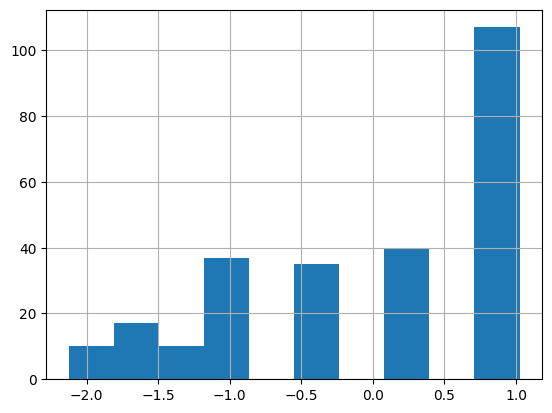

In [72]:



#histogram of exam scores for mastery students
df['Mastery'].hist()

#print bucketed exam scores for mastery students
df['Mastery'].value_counts()


<Axes: >

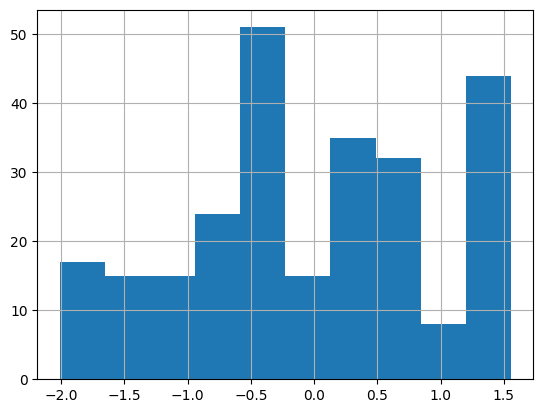

In [73]:
df['Normative'].hist()

<Axes: >

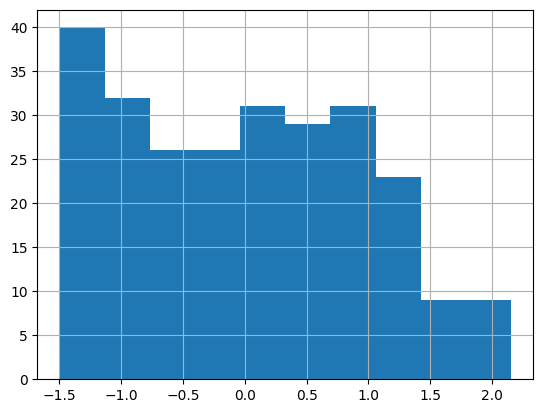

In [74]:
df['Appearance'].hist()

### Total Final Exam Score (Copilot & Noncopilot together)

Base Model for Total Final Exam Score (Copilot & Noncopilot together)

In [75]:
base_model_eq = 'Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)

Equation:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.189,0.087,-2.170,0.031
Mastery,-0.021,0.065,-0.327,0.744
Normative*,0.190,0.078,2.426,0.016
Appearance,-0.076,0.075,-1.018,0.310
Prior_Knowledge**,0.402,0.123,3.262,0.001


Model adj. R^2: 0.055, R^2: 0.070, N. obs: 251, F-statistic: 4.662

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.187,0.088,-2.132,0.034
Mastery,-0.021,0.065,-0.326,0.744
Normative*,0.182,0.080,2.283,0.023
Appearance,-0.069,0.077,-0.901,0.368
Prior_Knowledge**,0.396,0.124,3.196,0.002


Model adj. R^2: 0.051, R^2: 0.066, N. obs: 249, F-statistic: 4.315


Best Stepwise Model for Total Final Exam Score (Copilot & Noncopilot together)

In [76]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'Final_Exam_Score', check_anova_before_adding=True, display_best_model=True)

#Dict of best models for each number of predictors. Keys are number of predictors, value is a tuple of the best model string equation and the model's adjusted R^2 value
#achievement_goals_dict_best_models

Equation:  Final_Exam_Score ~ Normative:Appearance:Prior_Knowledge + Normative + Prior_Knowledge + Appearance


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.189,0.087,-2.173,0.031
Normative:Appearance:Prior_Knowledge,-0.068,0.092,-0.746,0.456
Normative*,0.174,0.075,2.306,0.022
Prior_Knowledge**,0.442,0.135,3.269,0.001
Appearance,-0.063,0.076,-0.829,0.408


Model adj. R^2: 0.057, R^2: 0.072, N. obs: 251, F-statistic: 4.783

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [10, 100, 113, 116, 158, 171, 179, 281, 283, 332, 347, 355, 376, 467, 524]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.193,0.087,-2.216,0.028
Normative:Appearance:Prior_Knowledge,-0.137,0.113,-1.211,0.227
Normative**,0.224,0.078,2.875,0.004
Prior_Knowledge***,0.524,0.139,3.762,0.000
Appearance,-0.079,0.078,-1.011,0.313


Model adj. R^2: 0.082, R^2: 0.098, N. obs: 236, F-statistic: 6.280


### Blockwise testing for Total Final Exam Scores

In [77]:

# Run the blockwise selection
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.187,0.088,-2.135,0.034
Mastery,-0.054,0.090,-0.599,0.550
Normative*,0.234,0.111,2.109,0.036
Appearance,-0.110,0.103,-1.064,0.288
Prior_Knowledge**,0.401,0.124,3.238,0.001
Mastery:Prior_Knowledge,0.069,0.130,0.532,0.595
Normative:Prior_Knowledge,-0.090,0.158,-0.570,0.569
Appearance:Prior_Knowledge,0.075,0.151,0.494,0.622


Model adj. R^2: 0.046, R^2: 0.072, N. obs: 251, F-statistic: 2.711

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [105, 171, 281, 283, 347, 355, 438, 442, 454]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.197,0.089,-2.209,0.028
Mastery,-0.076,0.092,-0.824,0.411
Normative*,0.253,0.112,2.263,0.025
Appearance,-0.100,0.104,-0.960,0.338
Prior_Knowledge***,0.432,0.126,3.438,0.001
Mastery:Prior_Knowledge,0.103,0.132,0.782,0.435
Normative:Prior_Knowledge,-0.047,0.168,-0.278,0.781
Appearance:Prior_Knowledge,0.003,0.160,0.021,0.983


Model adj. R^2: 0.059, R^2: 0.086, N. obs: 242, F-statistic: 3.160
Equation:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.196,0.097,-2.020,0.044
Mastery,-0.043,0.071,-0.601,0.549
Normative*,0.219,0.088,2.494,0.013
Appearance,-0.087,0.079,-1.104,0.271
Prior_Knowledge**,0.396,0.124,3.182,0.002
Mastery:Appearance,-0.009,0.077,-0.114,0.910
Normative:Appearance,0.039,0.070,0.556,0.579
Mastery:Normative,-0.038,0.078,-0.485,0.628


Model adj. R^2: 0.046, R^2: 0.073, N. obs: 251, F-statistic: 2.722

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 105, 116, 171, 193, 281, 283, 332, 355, 376, 438, 449, 454, 464, 467, 511, 533]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.155,0.100,-1.554,0.122
Mastery,0.001,0.074,0.009,0.993
Normative*,0.240,0.094,2.549,0.011
Appearance,-0.078,0.084,-0.928,0.354
Prior_Knowledge***,0.430,0.129,3.339,0.001
Mastery:Appearance,-0.010,0.082,-0.123,0.902
Normative:Appearance,-0.041,0.077,-0.538,0.591
Mastery:Normative,-0.036,0.086,-0.417,0.677


Model adj. R^2: 0.060, R^2: 0.088, N. obs: 234, F-statistic: 3.132
Equation:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.189,0.089,-2.127,0.034
Mastery,-0.046,0.073,-0.632,0.528
Normative**,0.246,0.083,2.961,0.003
Appearance,-0.085,0.078,-1.094,0.275
Prior_Knowledge***,0.549,0.141,3.888,0.000
Mastery:Normative:Appearance,0.009,0.063,0.138,0.890
Mastery:Normative:Prior_Knowledge**,-0.335,0.119,-2.812,0.005
Mastery:Appearance:Prior_Knowledge,0.231,0.119,1.941,0.053
Normative:Appearance:Prior_Knowledge,-0.121,0.099,-1.222,0.223


Model adj. R^2: 0.074, R^2: 0.103, N. obs: 251, F-statistic: 3.481

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [100, 105, 116, 122, 127, 171, 193, 209, 234, 255, 281, 283, 332, 347, 355, 363, 376, 423, 449, 464, 467, 502, 511, 528]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.197,0.094,-2.094,0.037
Mastery,-0.029,0.077,-0.376,0.707
Normative**,0.234,0.088,2.650,0.009
Appearance,-0.068,0.083,-0.818,0.414
Prior_Knowledge***,0.576,0.151,3.805,0.000
Mastery:Normative:Appearance,0.061,0.072,0.852,0.395
Mastery:Normative:Prior_Knowledge,-0.245,0.138,-1.767,0.079
Mastery:Appearance:Prior_Knowledge,0.170,0.141,1.205,0.230
Normative:Appearance:Prior_Knowledge,-0.210,0.115,-1.827,0.069


Model adj. R^2: 0.069, R^2: 0.102, N. obs: 227, F-statistic: 3.087
The best blockwise model is below: 
Equation:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.189,0.087,-2.170,0.031
Mastery,-0.021,0.065,-0.327,0.744
Normative*,0.190,0.078,2.426,0.016
Appearance,-0.076,0.075,-1.018,0.310
Prior_Knowledge**,0.402,0.123,3.262,0.001


Model adj. R^2: 0.055, R^2: 0.070, N. obs: 251, F-statistic: 4.662

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.187,0.088,-2.132,0.034
Mastery,-0.021,0.065,-0.326,0.744
Normative*,0.182,0.080,2.283,0.023
Appearance,-0.069,0.077,-0.901,0.368
Prior_Knowledge**,0.396,0.124,3.196,0.002


Model adj. R^2: 0.051, R^2: 0.066, N. obs: 249, F-statistic: 4.315
Displaying ANOVA results:
model1:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,231.665,0.000,NaN,NaN,NaN
1,246.000,231.665,-0.000,-0.000,NaN,NaN


F(-0.0, 246.0) = nan, p = nan


### Copilot Final Exam Question 

Base Model for Copilot Final Exam Question

In [78]:
"""
base_model_eq = 'Final_copilot_question ~ Mastery+Normative+Appearance+Prior_Knowledge'
base_model = display_model_info(base_model_eq, df)
"""

"\nbase_model_eq = 'Final_copilot_question ~ Mastery+Normative+Appearance+Prior_Knowledge'\nbase_model = display_model_info(base_model_eq, df)\n"

Best Stepwise Model for Copilot Final Exam Question

In [79]:
"""
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars, 'Final_copilot_question', display_best_model=True)
"""

"\n_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars, 'Final_copilot_question', display_best_model=True)\n"

### Blockwise testing for Copilot Question Scores

In [80]:
"""
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())
"""

'\n_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True)\n\ndisplay_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())\n'

### Non-Copilot Final Exam Question 

Base Model for Non-Copilot Final Exam Question

In [81]:
base_model_eq = 'Final_noncopilot_questions ~ Mastery+Normative+Appearance+Prior_Knowledge'
base_model = display_model_info(base_model_eq, df)


Equation:  Final_noncopilot_questions ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.235,0.086,-2.736,0.007
Mastery,-0.037,0.064,-0.574,0.566
Normative*,0.185,0.077,2.401,0.017
Appearance,-0.063,0.074,-0.847,0.398
Prior_Knowledge***,0.500,0.122,4.108,0.000


Model adj. R^2: 0.078, R^2: 0.092, N. obs: 251, F-statistic: 6.263

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([  9,  72, 113]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 171, 238]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.250,0.083,-3.015,0.003
Mastery,-0.012,0.062,-0.194,0.846
Normative**,0.219,0.075,2.914,0.004
Appearance,-0.091,0.072,-1.269,0.206
Prior_Knowledge***,0.551,0.118,4.688,0.000


Model adj. R^2: 0.108, R^2: 0.123, N. obs: 248, F-statistic: 8.494
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.231,0.086,-2.674,0.008
Mastery,-0.036,0.064,-0.567,0.571
Normative*,0.180,0.079,2.287,0.023
Appearance,-0.058,0.075,-0.769,0.443
Prior_Knowledge***,0.494,0.122,4.033,0.000


Model adj. R^2: 0.073, R^2: 0.088, N. obs: 249, F-statistic: 5.904


Best Stepwise Model for Non-Copilot Final Exam Question

In [82]:
#_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'Final_noncopilot_questions', check_anova_before_adding=True, display_best_model=True)

### Blockwise testing for Non-Copilot Scores

In [83]:

_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())


----------------------Adding block '+ Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge' improves the model significantly.
The best blockwise model is below: 
Equation:  Final_noncopilot_questions ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.234,0.087,-2.686,0.008
Mastery,-0.066,0.072,-0.914,0.362
Normative**,0.253,0.082,3.095,0.002
Appearance,-0.077,0.077,-1.002,0.317
Prior_Knowledge***,0.650,0.139,4.690,0.000
Mastery:Normative:Appearance,0.008,0.062,0.123,0.902
Mastery:Normative:Prior_Knowledge**,-0.383,0.117,-3.270,0.001
Mastery:Appearance:Prior_Knowledge*,0.276,0.117,2.358,0.019
Normative:Appearance:Prior_Knowledge,-0.110,0.097,-1.139,0.256


Model adj. R^2: 0.105, R^2: 0.134, N. obs: 251, F-statistic: 4.668

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [100, 105, 116, 122, 127, 171, 193, 209, 234, 255, 281, 283, 332, 347, 355, 363, 376, 423, 449, 464, 467, 502, 511, 528]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.237,0.092,-2.563,0.011
Mastery,-0.055,0.076,-0.726,0.469
Normative**,0.241,0.087,2.780,0.006
Appearance,-0.053,0.082,-0.651,0.516
Prior_Knowledge***,0.673,0.149,4.518,0.000
Mastery:Normative:Appearance,0.060,0.071,0.849,0.397
Mastery:Normative:Prior_Knowledge*,-0.299,0.136,-2.192,0.029
Mastery:Appearance:Prior_Knowledge,0.216,0.139,1.556,0.121
Normative:Appearance:Prior_Knowledge,-0.174,0.113,-1.539,0.125


Model adj. R^2: 0.097, R^2: 0.129, N. obs: 227, F-statistic: 4.027
Displaying ANOVA results:
model1:  Final_noncopilot_questions ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  Final_noncopilot_questions ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,225.502,0.000,NaN,NaN,NaN
1,242.000,215.252,4.000,10.249,2.881,0.023


F(4.0, 242.0) = 2.88, p = 0.02
NOTE: ANOVA The difference between models is significant.


## Interest

Base Model for Interest

In [84]:
base_interest_eq = 'Interest ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_interest_eq, df)

Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.282,0.079,-3.584,0.000
Mastery***,0.335,0.058,5.728,0.000
Normative,0.099,0.071,1.402,0.162
Appearance,-0.019,0.068,-0.284,0.777
Prior_Knowledge***,0.573,0.111,5.138,0.000


Model adj. R^2: 0.229, R^2: 0.241, N. obs: 251, F-statistic: 19.569

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([9]), 'outliers_abs_gt_2_5': array([  9, 208, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 441, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [281, 355]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.290,0.078,-3.724,0.000
Mastery***,0.336,0.058,5.791,0.000
Normative,0.111,0.070,1.590,0.113
Appearance,-0.016,0.067,-0.238,0.812
Prior_Knowledge***,0.601,0.110,5.470,0.000


Model adj. R^2: 0.246, R^2: 0.258, N. obs: 248, F-statistic: 21.178
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.293,0.079,-3.726,0.000
Mastery***,0.333,0.058,5.727,0.000
Normative,0.112,0.072,1.564,0.119
Appearance,-0.029,0.069,-0.421,0.674
Prior_Knowledge***,0.589,0.111,5.288,0.000


Model adj. R^2: 0.236, R^2: 0.248, N. obs: 249, F-statistic: 20.162


Best model for Interest

In [85]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars, 'Interest', check_anova_before_adding=True, display_best_model=True)

Equation:  Interest ~ Mastery:Normative:Appearance:Prior_Knowledge + Normative + Mastery + Prior_Knowledge + Appearance


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.281,0.079,-3.576,0.000
Mastery:Normative:Appearance:Prior_Knowledge,-0.066,0.075,-0.880,0.380
Normative,0.091,0.071,1.267,0.206
Mastery***,0.356,0.063,5.626,0.000
Prior_Knowledge***,0.581,0.112,5.191,0.000
Appearance,-0.008,0.069,-0.116,0.908


Model adj. R^2: 0.228, R^2: 0.244, N. obs: 251, F-statistic: 15.796

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([9]), 'outliers_abs_gt_2_5': array([  9, 208, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 441, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [10, 100, 116, 122, 158, 171, 179, 281, 283, 332, 347, 355, 376, 423, 467, 524]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.289,0.078,-3.716,0.000
Mastery:Normative:Appearance:Prior_Knowledge,-0.068,0.074,-0.927,0.355
Normative,0.102,0.071,1.445,0.150
Mastery***,0.359,0.063,5.700,0.000
Prior_Knowledge***,0.610,0.110,5.528,0.000
Appearance,-0.004,0.068,-0.065,0.948


Model adj. R^2: 0.246, R^2: 0.261, N. obs: 248, F-statistic: 17.104
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.294,0.081,-3.647,0.000
Mastery:Normative:Appearance:Prior_Knowledge,-0.040,0.091,-0.445,0.657
Normative,0.090,0.075,1.203,0.230
Mastery***,0.339,0.065,5.179,0.000
Prior_Knowledge***,0.571,0.116,4.936,0.000
Appearance,-0.029,0.072,-0.398,0.691


Model adj. R^2: 0.211, R^2: 0.227, N. obs: 235, F-statistic: 13.478


### Blockwise testing for Interest

Equations: 


eq = base_model_eq + priorexpblock 


eq = base_model_eq + betweenachievementsblock


eq = base_model_eq + threewayinteractionsblock

Result: None are significant

In [86]:
eq = base_interest_eq + priorexpblock
block_model = display_model_info(eq, df)
display_anova(base_model, block_model)

Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.282,0.079,-3.555,0.000
Mastery***,0.341,0.081,4.192,0.000
Normative,0.088,0.100,0.878,0.381
Appearance,-0.054,0.093,-0.575,0.566
Prior_Knowledge***,0.572,0.112,5.108,0.000
Mastery:Prior_Knowledge,-0.009,0.118,-0.077,0.938
Normative:Prior_Knowledge,0.017,0.142,0.119,0.905
Appearance:Prior_Knowledge,0.072,0.137,0.530,0.597


Model adj. R^2: 0.221, R^2: 0.243, N. obs: 251, F-statistic: 11.150

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([9]), 'outliers_abs_gt_2_5': array([  9, 208, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 441, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [105, 171, 281, 283, 347, 355, 438, 442, 454]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.290,0.078,-3.698,0.000
Mastery***,0.325,0.082,3.975,0.000
Normative,0.108,0.100,1.081,0.281
Appearance,-0.050,0.092,-0.539,0.590
Prior_Knowledge***,0.600,0.111,5.432,0.000
Mastery:Prior_Knowledge,0.028,0.117,0.241,0.810
Normative:Prior_Knowledge,0.001,0.141,0.006,0.995
Appearance:Prior_Knowledge,0.073,0.135,0.539,0.590


Model adj. R^2: 0.239, R^2: 0.260, N. obs: 248, F-statistic: 12.054
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.280,0.081,-3.462,0.001
Mastery***,0.341,0.083,4.103,0.000
Normative,0.085,0.102,0.842,0.401
Appearance,-0.054,0.095,-0.572,0.568
Prior_Knowledge***,0.560,0.114,4.910,0.000
Mastery:Prior_Knowledge,-0.024,0.120,-0.202,0.840
Normative:Prior_Knowledge,0.035,0.153,0.227,0.820
Appearance:Prior_Knowledge,0.064,0.145,0.438,0.662


Model adj. R^2: 0.212, R^2: 0.235, N. obs: 242, F-statistic: 10.260
Displaying ANOVA results:
model1:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,189.269,0.000,NaN,NaN,NaN
1,243.000,188.841,3.000,0.428,0.184,0.908


F(3.0, 243.0) = 0.18, p = 0.91


In [87]:
eq3 = base_interest_eq + betweenachievementsblock
m3 = display_model_info(eq3, df)

display_anova(base_model, m3)

Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.288,0.088,-3.288,0.001
Mastery***,0.319,0.064,4.982,0.000
Normative,0.127,0.079,1.604,0.110
Appearance,-0.029,0.071,-0.406,0.685
Prior_Knowledge***,0.564,0.112,5.025,0.000
Mastery:Appearance,-0.051,0.069,-0.731,0.465
Normative:Appearance,0.030,0.063,0.476,0.634
Mastery:Normative,-0.012,0.070,-0.171,0.865


Model adj. R^2: 0.222, R^2: 0.244, N. obs: 251, F-statistic: 11.218

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([9]), 'outliers_abs_gt_2_5': array([  9, 208, 230]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 441, 492]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [17, 105, 116, 171, 193, 281, 283, 332, 355, 376, 438, 449, 454, 464, 467, 511, 533]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.288,0.086,-3.330,0.001
Mastery***,0.331,0.063,5.228,0.000
Normative,0.124,0.078,1.593,0.112
Appearance,-0.019,0.070,-0.265,0.791
Prior_Knowledge***,0.595,0.111,5.361,0.000
Mastery:Appearance,-0.042,0.069,-0.610,0.543
Normative:Appearance,0.007,0.063,0.118,0.906
Mastery:Normative,-0.000,0.070,-0.003,0.997


Model adj. R^2: 0.238, R^2: 0.260, N. obs: 248, F-statistic: 12.050
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.329,0.090,-3.633,0.000
Mastery***,0.318,0.067,4.748,0.000
Normative,0.119,0.085,1.391,0.166
Appearance,-0.034,0.076,-0.447,0.655
Prior_Knowledge***,0.564,0.117,4.841,0.000
Mastery:Appearance,-0.067,0.074,-0.905,0.366
Normative:Appearance,0.063,0.070,0.907,0.366
Mastery:Normative,0.012,0.078,0.160,0.873


Model adj. R^2: 0.218, R^2: 0.241, N. obs: 234, F-statistic: 10.259
Displaying ANOVA results:
model1:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Appearance + Normative:Appearance + Mastery:Normative


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,189.269,0.000,NaN,NaN,NaN
1,243.000,188.561,3.000,0.708,0.304,0.822


F(3.0, 243.0) = 0.30, p = 0.82


In [88]:
eq4 = base_interest_eq + threewayinteractionsblock
m4 = display_model_info(eq4, df)
display_anova(base_model, m4)

Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.250,0.081,-3.077,0.002
Mastery***,0.377,0.067,5.646,0.000
Normative,0.113,0.076,1.492,0.137
Appearance,-0.004,0.071,-0.060,0.952
Prior_Knowledge***,0.525,0.129,4.070,0.000
Mastery:Normative:Appearance,-0.092,0.058,-1.601,0.111
Mastery:Normative:Prior_Knowledge,-0.073,0.109,-0.667,0.505
Mastery:Appearance:Prior_Knowledge,0.075,0.109,0.690,0.491
Normative:Appearance:Prior_Knowledge,0.069,0.090,0.760,0.448


Model adj. R^2: 0.227, R^2: 0.252, N. obs: 251, F-statistic: 10.167

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([9]), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [100, 105, 116, 122, 127, 171, 193, 209, 234, 255, 281, 283, 332, 347, 355, 363, 376, 423, 449, 464, 467, 502, 511, 528]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.248,0.080,-3.116,0.002
Mastery***,0.391,0.066,5.958,0.000
Normative,0.112,0.075,1.496,0.136
Appearance,0.001,0.070,0.013,0.989
Prior_Knowledge***,0.552,0.127,4.351,0.000
Mastery:Normative:Appearance,-0.096,0.057,-1.700,0.090
Mastery:Normative:Prior_Knowledge,-0.069,0.107,-0.648,0.517
Mastery:Appearance:Prior_Knowledge,0.083,0.107,0.778,0.437
Normative:Appearance:Prior_Knowledge,0.056,0.089,0.633,0.527


Model adj. R^2: 0.246, R^2: 0.270, N. obs: 250, F-statistic: 11.163
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.238,0.086,-2.760,0.006
Mastery***,0.367,0.071,5.185,0.000
Normative,0.091,0.081,1.122,0.263
Appearance,-0.017,0.076,-0.219,0.827
Prior_Knowledge***,0.529,0.139,3.813,0.000
Mastery:Normative:Appearance,-0.059,0.066,-0.899,0.370
Mastery:Normative:Prior_Knowledge,-0.083,0.127,-0.653,0.514
Mastery:Appearance:Prior_Knowledge,0.138,0.129,1.067,0.287
Normative:Appearance:Prior_Knowledge,0.031,0.105,0.292,0.770


Model adj. R^2: 0.210, R^2: 0.238, N. obs: 227, F-statistic: 8.522
Displaying ANOVA results:
model1:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,246.000,189.269,0.000,NaN,NaN,NaN
1,242.000,186.732,4.000,2.536,0.822,0.512


F(4.0, 242.0) = 0.82, p = 0.51


# 2nd paper: Self Efficacy & Other Attributes

Independent variables attributes we're considering: 
- Mastery + Normative + Appearance + Prior_Knowledge + ProgIntelligenceBelief + CSMajor + SelfEfficacy + CanDoThisTask

Dependent variables we're considering: 
- attitudes, performance, and self-reported use of GenAI 

Note: 
Self efficacy was measured pre, and sense of belonging was measured post. 

In [89]:
base_factors = ['Mastery', 'Normative', 'Appearance', 'Prior_Knowledge', 'CSMajor', 'SelfEfficacy', 'ProgIntelligenceBelief', 'CanDoThisTask', 'Belonging']

In [90]:
# make an equation with all factors 
base_all_factors_eq = 'Interest ~ ' + '+'.join(base_factors)
print(base_all_factors_eq)


Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+SelfEfficacy+ProgIntelligenceBelief+CanDoThisTask+Belonging


In [91]:

base_model = display_model_info(base_all_factors_eq, df)

Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+SelfEfficacy+ProgIntelligenceBelief+CanDoThisTask+Belonging


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.140,0.070,-2.000,0.047
Mastery*,0.117,0.045,2.572,0.011
Normative,0.061,0.051,1.194,0.234
Appearance,-0.030,0.048,-0.625,0.533
Prior_Knowledge,-0.041,0.089,-0.464,0.643
CSMajor***,0.346,0.088,3.927,0.000
SelfEfficacy,-0.031,0.045,-0.699,0.486
ProgIntelligenceBelief***,-0.285,0.049,-5.861,0.000
CanDoThisTask***,0.171,0.048,3.536,0.000
Belonging***,0.374,0.049,7.639,0.000


Model adj. R^2: 0.622, R^2: 0.636, N. obs: 251, F-statistic: 46.745

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.14111583315878395, pvalue=3.9983039079403985e-05, statistic_location=-0.5811844770733211, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([32]), 'outliers_abs_gt_2_5': array([ 11,  32, 188]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [26, 76, 395]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [22, 27, 116, 355, 410, 442, 473]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.140,0.068,-2.054,0.041
Mastery**,0.121,0.044,2.736,0.007
Normative,0.056,0.049,1.135,0.257
Appearance,-0.032,0.046,-0.690,0.491
Prior_Knowledge,-0.034,0.086,-0.394,0.694
CSMajor***,0.331,0.086,3.845,0.000
SelfEfficacy,-0.025,0.043,-0.587,0.558
ProgIntelligenceBelief***,-0.300,0.047,-6.367,0.000
CanDoThisTask**,0.155,0.047,3.308,0.001
Belonging***,0.392,0.048,8.226,0.000


Model adj. R^2: 0.649, R^2: 0.662, N. obs: 248, F-statistic: 51.740
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.143,0.072,-1.987,0.048
Mastery*,0.108,0.047,2.320,0.021
Normative,0.057,0.051,1.115,0.266
Appearance,-0.021,0.049,-0.433,0.666
Prior_Knowledge,-0.032,0.091,-0.355,0.723
CSMajor***,0.348,0.090,3.884,0.000
SelfEfficacy,-0.019,0.046,-0.414,0.679
ProgIntelligenceBelief***,-0.257,0.050,-5.124,0.000
CanDoThisTask***,0.191,0.049,3.855,0.000
Belonging***,0.371,0.050,7.421,0.000


Model adj. R^2: 0.613, R^2: 0.628, N. obs: 244, F-statistic: 43.857


## Interest

In [92]:
base_interest_eq = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor  + SelfEfficacy + Belonging + ProgIntelligenceBelief + CanDoThisTask'
base_model = display_model_info(base_interest_eq, df)

Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor  + SelfEfficacy + Belonging + ProgIntelligenceBelief + CanDoThisTask


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.140,0.070,-2.000,0.047
Mastery*,0.117,0.045,2.572,0.011
Normative,0.061,0.051,1.194,0.234
Appearance,-0.030,0.048,-0.625,0.533
Prior_Knowledge,-0.041,0.089,-0.464,0.643
CSMajor***,0.346,0.088,3.927,0.000
SelfEfficacy,-0.031,0.045,-0.699,0.486
Belonging***,0.374,0.049,7.639,0.000
ProgIntelligenceBelief***,-0.285,0.049,-5.861,0.000
CanDoThisTask***,0.171,0.048,3.536,0.000


Model adj. R^2: 0.622, R^2: 0.636, N. obs: 251, F-statistic: 46.745

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.14111583315878384, pvalue=3.998303907940462e-05, statistic_location=-0.5811844770733213, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([32]), 'outliers_abs_gt_2_5': array([ 11,  32, 188]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [26, 76, 395]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [22, 27, 116, 355, 410, 442, 473]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.140,0.068,-2.054,0.041
Mastery**,0.121,0.044,2.736,0.007
Normative,0.056,0.049,1.135,0.257
Appearance,-0.032,0.046,-0.690,0.491
Prior_Knowledge,-0.034,0.086,-0.394,0.694
CSMajor***,0.331,0.086,3.845,0.000
SelfEfficacy,-0.025,0.043,-0.587,0.558
Belonging***,0.392,0.048,8.226,0.000
ProgIntelligenceBelief***,-0.300,0.047,-6.367,0.000
CanDoThisTask**,0.155,0.047,3.308,0.001


Model adj. R^2: 0.649, R^2: 0.662, N. obs: 248, F-statistic: 51.740
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.143,0.072,-1.987,0.048
Mastery*,0.108,0.047,2.320,0.021
Normative,0.057,0.051,1.115,0.266
Appearance,-0.021,0.049,-0.433,0.666
Prior_Knowledge,-0.032,0.091,-0.355,0.723
CSMajor***,0.348,0.090,3.884,0.000
SelfEfficacy,-0.019,0.046,-0.414,0.679
Belonging***,0.371,0.050,7.421,0.000
ProgIntelligenceBelief***,-0.257,0.050,-5.124,0.000
CanDoThisTask***,0.191,0.049,3.855,0.000


Model adj. R^2: 0.613, R^2: 0.628, N. obs: 244, F-statistic: 43.857


The adj. R^2 for 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief' is really high compared to just the achievement goals + prior knowledge one, which was 0.211.  Let's add in factors one at a time to find out why. 

In [93]:
#display model info for each separately 

#make a dictionary where the key is the equation and the value is the adjusted r^2 value
modeldicts = {}


eq = 'Interest ~ Mastery'
display_model_info(eq, df, rsq_only=True, rsqdict=modeldicts)

eq = 'Interest ~ Normative'
display_model_info(eq, df, rsq_only=True, rsqdict=modeldicts)

eq = 'Interest ~ Appearance'
display_model_info(eq, df, rsq_only=True, rsqdict=modeldicts)

eq = 'Interest ~ Prior_Knowledge'
display_model_info(eq, df, rsq_only=True, rsqdict=modeldicts)

eq = 'Interest ~ CSMajor'
display_model_info(eq, df, rsq_only=True, rsqdict=modeldicts)

eq = 'Interest ~ SelfEfficacy'
display_model_info(eq, df, rsq_only=True, rsqdict=modeldicts)

eq = 'Interest ~ ProgIntelligenceBelief'
display_model_info(eq, df, rsq_only=True, rsqdict=modeldicts)

eq = 'Interest ~ CanDoThisTask'
display_model_info(eq, df, rsq_only=True, rsqdict=modeldicts)



Equation:  Interest ~ Mastery
Model adj. R^2: 0.154
Equation:  Interest ~ Normative
Model adj. R^2: 0.043
Equation:  Interest ~ Appearance
Model adj. R^2: -0.001
Equation:  Interest ~ Prior_Knowledge
Model adj. R^2: 0.099
Equation:  Interest ~ CSMajor
Model adj. R^2: 0.219
Equation:  Interest ~ SelfEfficacy
Model adj. R^2: 0.081
Equation:  Interest ~ ProgIntelligenceBelief
Model adj. R^2: 0.375
Equation:  Interest ~ CanDoThisTask
Model adj. R^2: 0.291


In [94]:
#print best model based on adjusted R^2 value

best_model = max(modeldicts, key=modeldicts.get)

print(f"Best model: {best_model}")


Best model: Interest ~ ProgIntelligenceBelief


## Exam Scores

In [95]:
#blocks to try: priorknowledge interactions with everything 

In [96]:
base_exam_eq = 'Final_Exam_Score ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor  + ProgIntelligenceBelief + CanDoThisTask + Belonging + SelfEfficacy'
base_model = display_model_info(base_exam_eq, df)


Equation:  Final_Exam_Score ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor  + ProgIntelligenceBelief + CanDoThisTask + Belonging + SelfEfficacy


,Coefficient,Standard Error,t-value,p-value
Intercept,0.070,0.097,0.722,0.471
Mastery,-0.101,0.063,-1.608,0.109
Normative,0.118,0.070,1.673,0.096
Appearance,-0.026,0.067,-0.394,0.694
Prior_Knowledge,0.075,0.124,0.605,0.546
CSMajor,-0.221,0.122,-1.810,0.072
ProgIntelligenceBelief,-0.078,0.067,-1.159,0.248
CanDoThisTask***,0.458,0.067,6.804,0.000
Belonging,0.087,0.068,1.277,0.203
SelfEfficacy,-0.022,0.062,-0.353,0.724


Model adj. R^2: 0.272, R^2: 0.299, N. obs: 251, F-statistic: 11.403

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([  8, 179, 233]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [19, 375, 499]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [22, 27, 116, 355, 410, 442, 473]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,0.051,0.097,0.522,0.602
Mastery,-0.104,0.062,-1.672,0.096
Normative,0.101,0.070,1.440,0.151
Appearance,-0.004,0.066,-0.062,0.951
Prior_Knowledge,0.095,0.122,0.777,0.438
CSMajor,-0.217,0.122,-1.778,0.077
ProgIntelligenceBelief,-0.084,0.067,-1.262,0.208
CanDoThisTask***,0.473,0.067,7.092,0.000
Belonging,0.095,0.068,1.403,0.162
SelfEfficacy,-0.047,0.062,-0.758,0.449


Model adj. R^2: 0.290, R^2: 0.316, N. obs: 248, F-statistic: 12.192
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.074,0.101,0.727,0.468
Mastery,-0.092,0.065,-1.404,0.162
Normative,0.122,0.072,1.698,0.091
Appearance,-0.027,0.068,-0.396,0.693
Prior_Knowledge,0.090,0.127,0.706,0.481
CSMajor,-0.230,0.126,-1.830,0.069
ProgIntelligenceBelief,-0.073,0.070,-1.035,0.302
CanDoThisTask***,0.447,0.069,6.456,0.000
Belonging,0.078,0.070,1.109,0.269
SelfEfficacy,-0.019,0.064,-0.296,0.768


Model adj. R^2: 0.251, R^2: 0.279, N. obs: 244, F-statistic: 10.054


Students seem to be good at knowing whether or not they can do a task. We think that this is measuring actually whether or not they think they can do it and not simply confidence, since this factor is much more significant than self efficacy alone. 

CanDoThisTask when we include vs. remove it increases Rsq by ~0.1. 

### Prior Knowledge Interactions

In [97]:
eq = 'Final_Exam_Score ~ Mastery*Prior_Knowledge + Normative*Prior_Knowledge + Appearance*Prior_Knowledge + Prior_Knowledge + CSMajor*Prior_Knowledge + ProgIntelligenceBelief*Prior_Knowledge+CanDoThisTask*Prior_Knowledge + SelfEfficacy*Prior_Knowledge+Belonging*Prior_Knowledge'
mod = display_model_info(eq, df)


Equation:  Final_Exam_Score ~ Mastery*Prior_Knowledge + Normative*Prior_Knowledge + Appearance*Prior_Knowledge + Prior_Knowledge + CSMajor*Prior_Knowledge + ProgIntelligenceBelief*Prior_Knowledge+CanDoThisTask*Prior_Knowledge + SelfEfficacy*Prior_Knowledge+Belonging*Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.041,0.115,-0.357,0.721
Mastery,-0.141,0.088,-1.602,0.111
Prior_Knowledge,0.229,0.167,1.374,0.171
Mastery:Prior_Knowledge,0.067,0.126,0.527,0.599
Normative,0.189,0.100,1.897,0.059
Normative:Prior_Knowledge,-0.152,0.141,-1.073,0.284
Appearance,-0.074,0.092,-0.796,0.427
Appearance:Prior_Knowledge,0.083,0.135,0.617,0.538
CSMajor,-0.013,0.180,-0.073,0.942
CSMajor:Prior_Knowledge,-0.373,0.247,-1.511,0.132


Model adj. R^2: 0.271, R^2: 0.321, N. obs: 251, F-statistic: 6.473

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([  8,  60, 179, 233]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [19, 136, 375, 499]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [22, 27, 116, 141, 281, 355, 379, 442, 473]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.071,0.113,-0.633,0.527
Mastery,-0.160,0.086,-1.857,0.065
Prior_Knowledge,0.279,0.165,1.691,0.092
Mastery:Prior_Knowledge,0.114,0.124,0.918,0.359
Normative,0.171,0.097,1.756,0.080
Normative:Prior_Knowledge,-0.155,0.139,-1.119,0.264
Appearance,-0.032,0.091,-0.350,0.727
Appearance:Prior_Knowledge,0.040,0.132,0.304,0.761
CSMajor,0.011,0.176,0.065,0.948
CSMajor:Prior_Knowledge,-0.481,0.245,-1.968,0.050


Model adj. R^2: 0.301, R^2: 0.349, N. obs: 247, F-statistic: 7.223
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.044,0.119,-0.366,0.714
Mastery,-0.155,0.090,-1.724,0.086
Prior_Knowledge,0.243,0.175,1.388,0.167
Mastery:Prior_Knowledge,0.089,0.133,0.669,0.504
Normative*,0.207,0.102,2.034,0.043
Normative:Prior_Knowledge,-0.172,0.146,-1.171,0.243
Appearance,-0.096,0.095,-1.013,0.312
Appearance:Prior_Knowledge,0.118,0.141,0.841,0.401
CSMajor,-0.038,0.183,-0.208,0.835
CSMajor:Prior_Knowledge,-0.353,0.256,-1.381,0.169


Model adj. R^2: 0.244, R^2: 0.297, N. obs: 242, F-statistic: 5.571


With self efficacy, Rsq is a bit lower, but it might be useful bc it's a helpful story to tell that we're not just measuring self efficacy through the candothistask factor. 

In [98]:
eq = 'Final_Exam_Score ~ Mastery*Prior_Knowledge + Normative*Prior_Knowledge + Appearance*Prior_Knowledge + Prior_Knowledge + CSMajor*Prior_Knowledge + SelfEfficacy*Prior_Knowledge + ProgIntelligenceBelief*Prior_Knowledge + CanDoThisTask*Prior_Knowledge'
mod = display_model_info(eq, df)


Equation:  Final_Exam_Score ~ Mastery*Prior_Knowledge + Normative*Prior_Knowledge + Appearance*Prior_Knowledge + Prior_Knowledge + CSMajor*Prior_Knowledge + SelfEfficacy*Prior_Knowledge + ProgIntelligenceBelief*Prior_Knowledge + CanDoThisTask*Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.080,0.108,-0.740,0.460
Mastery,-0.138,0.088,-1.571,0.118
Prior_Knowledge,0.275,0.162,1.694,0.092
Mastery:Prior_Knowledge,0.074,0.126,0.583,0.561
Normative,0.193,0.100,1.937,0.054
Normative:Prior_Knowledge,-0.154,0.141,-1.087,0.278
Appearance,-0.080,0.092,-0.865,0.388
Appearance:Prior_Knowledge,0.102,0.134,0.760,0.448
CSMajor,0.021,0.177,0.118,0.906
CSMajor:Prior_Knowledge,-0.356,0.240,-1.484,0.139


Model adj. R^2: 0.271, R^2: 0.314, N. obs: 251, F-statistic: 7.183

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([  8, 179, 233]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [19, 375, 499]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [22, 27, 116, 281, 347, 355, 423, 442]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.110,0.107,-1.024,0.307
Mastery,-0.157,0.087,-1.802,0.073
Prior_Knowledge,0.320,0.162,1.967,0.050
Mastery:Prior_Knowledge,0.103,0.126,0.818,0.414
Normative,0.175,0.099,1.773,0.078
Normative:Prior_Knowledge,-0.147,0.141,-1.045,0.297
Appearance,-0.038,0.092,-0.413,0.680
Appearance:Prior_Knowledge,0.060,0.134,0.450,0.653
CSMajor,0.045,0.175,0.259,0.796
CSMajor:Prior_Knowledge,-0.397,0.239,-1.659,0.098


Model adj. R^2: 0.287, R^2: 0.331, N. obs: 248, F-statistic: 7.643
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.088,0.112,-0.783,0.435
Mastery,-0.151,0.090,-1.677,0.095
Prior_Knowledge,0.312,0.169,1.849,0.066
Mastery:Prior_Knowledge,0.101,0.131,0.770,0.442
Normative,0.200,0.102,1.965,0.051
Normative:Prior_Knowledge,-0.155,0.146,-1.058,0.291
Appearance,-0.073,0.094,-0.781,0.436
Appearance:Prior_Knowledge,0.094,0.140,0.675,0.500
CSMajor,0.029,0.180,0.163,0.871
CSMajor:Prior_Knowledge,-0.385,0.247,-1.558,0.121


Model adj. R^2: 0.248, R^2: 0.295, N. obs: 243, F-statistic: 6.332


In [99]:
eq = 'Final_Exam_Score ~ Mastery*CanDoThisTask + Normative*CanDoThisTask + Appearance*CanDoThisTask + Prior_Knowledge + CSMajor*CanDoThisTask + ProgIntelligenceBelief*CanDoThisTask+CanDoThisTask*Prior_Knowledge + SelfEfficacy*CanDoThisTask+Belonging*CanDoThisTask'
mod = display_model_info(eq, df)


Equation:  Final_Exam_Score ~ Mastery*CanDoThisTask + Normative*CanDoThisTask + Appearance*CanDoThisTask + Prior_Knowledge + CSMajor*CanDoThisTask + ProgIntelligenceBelief*CanDoThisTask+CanDoThisTask*Prior_Knowledge + SelfEfficacy*CanDoThisTask+Belonging*CanDoThisTask


,Coefficient,Standard Error,t-value,p-value
Intercept,0.058,0.102,0.576,0.565
Mastery,-0.106,0.064,-1.662,0.098
CanDoThisTask**,0.338,0.108,3.127,0.002
Mastery:CanDoThisTask,0.048,0.065,0.727,0.468
Normative*,0.146,0.071,2.048,0.042
Normative:CanDoThisTask*,-0.176,0.074,-2.358,0.019
Appearance,-0.037,0.067,-0.554,0.580
Appearance:CanDoThisTask,-0.010,0.065,-0.156,0.876
Prior_Knowledge,0.039,0.123,0.314,0.753
CSMajor,-0.223,0.122,-1.829,0.069


Model adj. R^2: 0.294, R^2: 0.342, N. obs: 251, F-statistic: 7.121

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.0768797869010996, pvalue=0.04881731153236978, statistic_location=-0.8690216830774468, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [0, 12, 19, 22, 27, 92, 116, 123, 167, 179, 193, 204, 227, 275, 281, 347, 355, 365, 400, 410, 442, 455, 473, 511]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.033,0.111,0.293,0.770
Mastery,-0.108,0.069,-1.570,0.118
CanDoThisTask**,0.412,0.128,3.209,0.002
Mastery:CanDoThisTask,0.071,0.075,0.944,0.346
Normative,0.112,0.074,1.502,0.135
Normative:CanDoThisTask,-0.124,0.079,-1.562,0.120
Appearance,0.027,0.071,0.374,0.709
Appearance:CanDoThisTask,-0.070,0.073,-0.955,0.341
Prior_Knowledge,0.067,0.132,0.506,0.614
CSMajor,-0.214,0.129,-1.661,0.098


Model adj. R^2: 0.297, R^2: 0.350, N. obs: 227, F-statistic: 6.614


### Trying Majors and Nonmajors Separately

In [100]:
#create a df of only non-CS majors
non_cs_majors = df[df['CSMajor'] == 0]

#create a df of only CS majors
cs_majors = df[df['CSMajor'] == 1]

#length of each 
len(non_cs_majors), len(cs_majors)

#print lengths
print(len(non_cs_majors), len(cs_majors))



139 117


In [101]:
print("percent non majors: ", len(non_cs_majors)/len(df))
print("percent majors: ", len(cs_majors)/len(df))

percent non majors:  0.54296875
percent majors:  0.45703125


In [102]:
#for non-CS majors only 
eq = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief + CanDoThisTask'
non_cs_majors
display_model_info(eq, non_cs_majors)

#note: results are same when we remove CSMajor from the equation, which makes sense. 


Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief + CanDoThisTask


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.313,0.091,-3.429,0.001
Mastery*,0.143,0.068,2.104,0.037
Normative,0.126,0.080,1.578,0.117
Appearance,0.019,0.076,0.247,0.805
Prior_Knowledge,0.194,0.138,1.402,0.163
CSMajor,-0.000,0.000,-0.945,0.346
SelfEfficacy,-0.017,0.066,-0.263,0.793
ProgIntelligenceBelief***,-0.417,0.077,-5.423,0.000
CanDoThisTask*,0.156,0.077,2.024,0.045


Model adj. R^2: 0.414, R^2: 0.445, N. obs: 134, F-statistic: 14.446

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant
(16.789463827564944, 0.03237758569761128, 2.5783548029468113, 0.016172987788812147)
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [22, 116, 355]
Re-running model without high leverage points


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.352,0.092,-3.802,0.000
Mastery*,0.159,0.069,2.299,0.023
Normative,0.135,0.079,1.712,0.089
Appearance,0.011,0.076,0.148,0.882
Prior_Knowledge,0.250,0.141,1.778,0.078
CSMajor,0.000,0.000,0.923,0.358
SelfEfficacy,-0.026,0.067,-0.388,0.699
ProgIntelligenceBelief***,-0.376,0.080,-4.690,0.000
CanDoThisTask,0.147,0.077,1.896,0.060


Model adj. R^2: 0.391, R^2: 0.424, N. obs: 131, F-statistic: 12.944


In [103]:
eq = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + ProgIntelligenceBelief'
display_model_info(eq, non_cs_majors)

Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + ProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.351,0.089,-3.933,0.000
Mastery,0.128,0.066,1.926,0.056
Normative*,0.154,0.078,1.980,0.050
Appearance,-0.008,0.075,-0.110,0.912
Prior_Knowledge,0.258,0.134,1.926,0.056
ProgIntelligenceBelief***,-0.485,0.069,-7.028,0.000


Model adj. R^2: 0.405, R^2: 0.427, N. obs: 134, F-statistic: 19.084

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant
(17.543513047775036, 0.0035764298586004064, 3.8564956386438585, 0.0027427044831890447)
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [22, 116, 281, 355, 438, 473, 492]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.372,0.091,-4.075,0.000
Mastery*,0.156,0.068,2.285,0.024
Normative*,0.188,0.080,2.354,0.020
Appearance,-0.040,0.077,-0.513,0.609
Prior_Knowledge*,0.309,0.137,2.257,0.026
ProgIntelligenceBelief***,-0.446,0.076,-5.879,0.000


Model adj. R^2: 0.391, R^2: 0.415, N. obs: 127, F-statistic: 17.192


In [104]:
#for CS majors only 
eq = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief'
display_model_info(eq, cs_majors)
#This is strange. Why is CS major predictive at all if they're all CS majors? 

#note: results are same when we remove CSMajor from the equation, which makes sense. 



Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept*,0.110,0.055,1.991,0.049
Mastery*,0.182,0.082,2.217,0.029
Normative,0.040,0.087,0.460,0.647
Appearance,-0.064,0.083,-0.772,0.442
Prior_Knowledge,0.148,0.141,1.048,0.297
CSMajor*,0.110,0.055,1.991,0.049
SelfEfficacy,0.058,0.080,0.720,0.473
ProgIntelligenceBelief***,-0.402,0.070,-5.726,0.000


Model adj. R^2: 0.288, R^2: 0.325, N. obs: 117, F-statistic: 8.832

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.11226932154858721, pvalue=0.04845237451873937, statistic_location=-0.15843848173864328, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([ 10, 107, 111]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [53, 397, 436]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  []
Re-running model without outliers


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Coefficient,Standard Error,t-value,p-value
Intercept*,0.125,0.050,2.513,0.013
Mastery,0.109,0.076,1.422,0.158
Normative,0.103,0.079,1.300,0.197
Appearance,-0.120,0.075,-1.600,0.113
Prior_Knowledge,0.193,0.127,1.515,0.133
CSMajor*,0.125,0.050,2.513,0.013
SelfEfficacy,0.069,0.073,0.953,0.342
ProgIntelligenceBelief***,-0.446,0.064,-6.926,0.000


Model adj. R^2: 0.376, R^2: 0.409, N. obs: 114, F-statistic: 12.362


In [105]:
#for CS majors only 
eq = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge  + SelfEfficacy + ProgIntelligenceBelief'
display_model_info(eq, cs_majors)
#This is strange. Why is CS major predictive at all if they're all CS majors? 

#note: results are same when we remove CSMajor from the equation, which makes sense. 



Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge  + SelfEfficacy + ProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept*,0.220,0.110,1.991,0.049
Mastery*,0.182,0.082,2.217,0.029
Normative,0.040,0.087,0.460,0.647
Appearance,-0.064,0.083,-0.772,0.442
Prior_Knowledge,0.148,0.141,1.048,0.297
SelfEfficacy,0.058,0.080,0.720,0.473
ProgIntelligenceBelief***,-0.402,0.070,-5.726,0.000


Model adj. R^2: 0.288, R^2: 0.325, N. obs: 117, F-statistic: 8.832

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.1122693215485876, pvalue=0.048452374518738364, statistic_location=-0.1584384817386424, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([ 10, 107, 111]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [53, 397, 436]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [92, 227]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept*,0.250,0.100,2.513,0.013
Mastery,0.109,0.076,1.422,0.158
Normative,0.103,0.079,1.300,0.197
Appearance,-0.120,0.075,-1.600,0.113
Prior_Knowledge,0.193,0.127,1.515,0.133
SelfEfficacy,0.069,0.073,0.953,0.342
ProgIntelligenceBelief***,-0.446,0.064,-6.926,0.000


Model adj. R^2: 0.376, R^2: 0.409, N. obs: 114, F-statistic: 12.362
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.212,0.114,1.860,0.066
Mastery*,0.182,0.083,2.182,0.031
Normative,0.040,0.088,0.462,0.645
Appearance,-0.065,0.085,-0.767,0.445
Prior_Knowledge,0.157,0.145,1.082,0.282
SelfEfficacy,0.053,0.083,0.640,0.523
ProgIntelligenceBelief***,-0.404,0.076,-5.334,0.000


Model adj. R^2: 0.272, R^2: 0.311, N. obs: 115, F-statistic: 8.106


In [106]:
eq = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + ProgIntelligenceBelief'
display_model_info(eq, cs_majors)

Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + ProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept,0.204,0.108,1.889,0.062
Mastery**,0.203,0.077,2.637,0.010
Normative,0.049,0.086,0.570,0.570
Appearance,-0.066,0.082,-0.801,0.425
Prior_Knowledge,0.178,0.134,1.328,0.187
ProgIntelligenceBelief***,-0.407,0.070,-5.830,0.000


Model adj. R^2: 0.291, R^2: 0.322, N. obs: 117, F-statistic: 10.541

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.11290606789689753, pvalue=0.046827704674992074, statistic_location=-0.49730423045605054, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([107, 111]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [397, 436]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [227, 444, 460]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept*,0.220,0.101,2.180,0.031
Mastery*,0.169,0.073,2.317,0.022
Normative,0.098,0.081,1.206,0.231
Appearance,-0.111,0.078,-1.433,0.155
Prior_Knowledge,0.221,0.125,1.759,0.081
ProgIntelligenceBelief***,-0.413,0.065,-6.346,0.000


Model adj. R^2: 0.337, R^2: 0.366, N. obs: 115, F-statistic: 12.593
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.154,0.112,1.372,0.173
Mastery**,0.235,0.080,2.954,0.004
Normative,0.045,0.089,0.506,0.614
Appearance,-0.070,0.086,-0.814,0.417
Prior_Knowledge,0.227,0.137,1.650,0.102
ProgIntelligenceBelief***,-0.390,0.074,-5.239,0.000


Model adj. R^2: 0.290, R^2: 0.321, N. obs: 114, F-statistic: 10.226


In [107]:
eq1 = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief + ConfidentIndependentProgramming + GenAIHelpsProgramming + GenAIHelpsProblemSolving + CopilotPerceptions'
display_model_info(eq, df)


Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + ProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.150,0.068,-2.221,0.027
Mastery***,0.218,0.051,4.296,0.000
Normative,0.103,0.060,1.723,0.086
Appearance,-0.004,0.057,-0.077,0.939
Prior_Knowledge**,0.301,0.098,3.076,0.002
ProgIntelligenceBelief***,-0.502,0.050,-10.001,0.000


Model adj. R^2: 0.450, R^2: 0.461, N. obs: 251, F-statistic: 41.962

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.08099330360244493, pvalue=0.0351176794406331, statistic_location=-1.0081529743130262, statistic_sign=-1)
^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant
(11.908098888313926, 0.03606896928161114, 2.4404709771194444, 0.03505389401216665)
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [22, 92, 116, 227, 281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.167,0.068,-2.449,0.015
Mastery***,0.220,0.051,4.282,0.000
Normative*,0.124,0.060,2.060,0.040
Appearance,-0.023,0.058,-0.392,0.695
Prior_Knowledge***,0.339,0.099,3.429,0.001
ProgIntelligenceBelief***,-0.496,0.054,-9.233,0.000


Model adj. R^2: 0.450, R^2: 0.462, N. obs: 245, F-statistic: 40.973


In [108]:
eq = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief + ReadCopilotOutput*SelfEfficacy + TestCopilotOutput*SelfEfficacy'
display_model_info(eq, df)


Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief + ReadCopilotOutput*SelfEfficacy + TestCopilotOutput*SelfEfficacy


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.347,0.077,-4.519,0.000
Mastery**,0.147,0.052,2.814,0.005
Normative,0.094,0.059,1.600,0.111
Appearance,-0.031,0.056,-0.562,0.575
Prior_Knowledge*,0.225,0.097,2.312,0.022
CSMajor***,0.507,0.099,5.104,0.000
SelfEfficacy,0.023,0.052,0.439,0.661
ProgIntelligenceBelief***,-0.434,0.052,-8.357,0.000
ReadCopilotOutput,0.028,0.058,0.481,0.631
ReadCopilotOutput:SelfEfficacy,0.003,0.062,0.049,0.961


Model adj. R^2: 0.495, R^2: 0.518, N. obs: 251, F-statistic: 23.317

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.09717965150544677, pvalue=0.008135159762075034, statistic_location=-1.040850452227807, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': array([ 11,  22,  32,  35,  49,  93, 149, 187, 188, 202, 203, 243, 248])}
^^^^^^^^^^^^^^^^Outliers:  [26, 53, 76, 83, 114, 211, 308, 392, 395, 427, 432, 518, 536]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [12, 22, 27, 66, 116, 167, 232, 275, 281, 308, 347, 355, 366, 379, 410, 438, 442, 451, 511]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.386,0.075,-5.163,0.000
Mastery*,0.126,0.051,2.470,0.014
Normative,0.095,0.057,1.678,0.095
Appearance,-0.053,0.053,-0.985,0.326
Prior_Knowledge**,0.253,0.094,2.679,0.008
CSMajor***,0.543,0.097,5.612,0.000
SelfEfficacy,0.033,0.050,0.653,0.514
ProgIntelligenceBelief***,-0.481,0.050,-9.522,0.000
ReadCopilotOutput,-0.014,0.056,-0.245,0.806
ReadCopilotOutput:SelfEfficacy,0.014,0.059,0.245,0.806


Model adj. R^2: 0.551, R^2: 0.571, N. obs: 239, F-statistic: 27.500
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.341,0.081,-4.200,0.000
Mastery**,0.166,0.055,3.029,0.003
Normative,0.119,0.061,1.966,0.050
Appearance,-0.053,0.058,-0.906,0.366
Prior_Knowledge*,0.245,0.101,2.428,0.016
CSMajor***,0.499,0.104,4.812,0.000
SelfEfficacy,0.027,0.056,0.480,0.632
ProgIntelligenceBelief***,-0.401,0.055,-7.279,0.000
ReadCopilotOutput,0.063,0.063,0.998,0.319
ReadCopilotOutput:SelfEfficacy,-0.011,0.069,-0.163,0.870


Model adj. R^2: 0.483, R^2: 0.507, N. obs: 233, F-statistic: 20.665


In [109]:
eq = 'Interest ~ ReadCopilotOutput + TestCopilotOutput + ReadCopilotOutput:TestCopilotOutput +CopilotPerceptions+ Prior_Knowledge + CSMajor + SelfEfficacy'
display_model_info(eq, df)


Equation:  Interest ~ ReadCopilotOutput + TestCopilotOutput + ReadCopilotOutput:TestCopilotOutput +CopilotPerceptions+ Prior_Knowledge + CSMajor + SelfEfficacy


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.455,0.089,-5.089,0.000
ReadCopilotOutput,0.037,0.065,0.566,0.572
TestCopilotOutput*,0.141,0.065,2.179,0.030
ReadCopilotOutput:TestCopilotOutput,-0.080,0.045,-1.793,0.074
CopilotPerceptions***,0.192,0.052,3.721,0.000
Prior_Knowledge**,0.334,0.107,3.131,0.002
CSMajor***,0.745,0.105,7.065,0.000
SelfEfficacy**,0.171,0.053,3.237,0.001


Model adj. R^2: 0.363, R^2: 0.381, N. obs: 251, F-statistic: 21.331

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [12, 91, 158, 214, 231, 234, 275, 296, 313, 355, 379, 492, 511]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.415,0.093,-4.478,0.000
ReadCopilotOutput,0.072,0.069,1.050,0.295
TestCopilotOutput,0.132,0.068,1.950,0.052
ReadCopilotOutput:TestCopilotOutput*,-0.124,0.051,-2.454,0.015
CopilotPerceptions***,0.193,0.053,3.637,0.000
Prior_Knowledge**,0.284,0.109,2.606,0.010
CSMajor***,0.753,0.106,7.125,0.000
SelfEfficacy***,0.193,0.053,3.619,0.000


Model adj. R^2: 0.381, R^2: 0.399, N. obs: 238, F-statistic: 21.846


## Predicting Other Things

In [110]:
eq = 'ReadCopilotOutput ~  Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest'
display_model_info(eq, df)



Equation:  ReadCopilotOutput ~  Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.059,0.110,-0.534,0.594
Prior_Knowledge,0.036,0.136,0.263,0.793
CSMajor,0.076,0.145,0.529,0.597
SelfEfficacy,-0.066,0.071,-0.926,0.355
Mastery,0.045,0.074,0.611,0.542
Normative,0.129,0.081,1.596,0.112
Appearance,-0.103,0.077,-1.346,0.180
Interest*,0.191,0.077,2.475,0.014


Model adj. R^2: 0.043, R^2: 0.070, N. obs: 251, F-statistic: 2.609

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [116, 167, 355, 442]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.094,0.114,-0.826,0.410
Prior_Knowledge,0.051,0.137,0.374,0.709
CSMajor,0.116,0.147,0.789,0.431
SelfEfficacy,-0.095,0.073,-1.303,0.194
Mastery,0.073,0.075,0.975,0.331
Normative,0.125,0.081,1.542,0.124
Appearance,-0.112,0.077,-1.451,0.148
Interest*,0.161,0.080,2.031,0.043


Model adj. R^2: 0.042, R^2: 0.069, N. obs: 247, F-statistic: 2.548


In [111]:
eq = 'TestCopilotOutput ~ Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest'
display_model_info(eq, df)



Equation:  TestCopilotOutput ~ Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest


,Coefficient,Standard Error,t-value,p-value
Intercept,0.073,0.110,0.666,0.506
Prior_Knowledge,-0.056,0.135,-0.415,0.678
CSMajor,-0.101,0.144,-0.699,0.486
SelfEfficacy,-0.087,0.071,-1.235,0.218
Mastery,0.063,0.073,0.851,0.395
Normative,0.157,0.081,1.941,0.053
Appearance,-0.113,0.077,-1.468,0.143
Interest**,0.241,0.077,3.130,0.002


Model adj. R^2: 0.053, R^2: 0.079, N. obs: 251, F-statistic: 2.993

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [116, 167, 355, 442]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.036,0.113,0.321,0.749
Prior_Knowledge,-0.041,0.137,-0.298,0.766
CSMajor,-0.054,0.146,-0.367,0.714
SelfEfficacy,-0.111,0.072,-1.538,0.125
Mastery,0.085,0.075,1.143,0.254
Normative,0.156,0.081,1.940,0.054
Appearance,-0.122,0.077,-1.592,0.113
Interest*,0.200,0.079,2.525,0.012


Model adj. R^2: 0.046, R^2: 0.073, N. obs: 247, F-statistic: 2.688


In [112]:
eq = 'CopilotPerceptions ~ Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest'
display_model_info(eq, df)



Equation:  CopilotPerceptions ~ Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest


,Coefficient,Standard Error,t-value,p-value
Intercept,0.065,0.109,0.601,0.548
Prior_Knowledge,0.080,0.134,0.602,0.548
CSMajor,-0.230,0.142,-1.611,0.109
SelfEfficacy,-0.125,0.070,-1.795,0.074
Mastery,0.046,0.073,0.640,0.523
Normative,0.036,0.080,0.448,0.655
Appearance,0.040,0.076,0.532,0.595
Interest***,0.298,0.076,3.919,0.000


Model adj. R^2: 0.058, R^2: 0.085, N. obs: 251, F-statistic: 3.218

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.19760561977081553, pvalue=2.2976701915676092e-09, statistic_location=0.3262555820134724, statistic_sign=-1)
^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant
(28.49690737328527, 0.00017865902571131335, 4.446004650323619, 0.00011328338563786034)
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [116, 167, 355, 442]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.046,0.113,0.411,0.681
Prior_Knowledge,0.091,0.136,0.669,0.504
CSMajor,-0.207,0.146,-1.419,0.157
SelfEfficacy,-0.133,0.072,-1.852,0.065
Mastery,0.054,0.074,0.722,0.471
Normative,0.037,0.080,0.464,0.643
Appearance,0.037,0.077,0.490,0.625
Interest***,0.276,0.079,3.493,0.001


Model adj. R^2: 0.050, R^2: 0.077, N. obs: 247, F-statistic: 2.838


In [113]:
indepedent_programming = 'ConfidentIndependentProgramming ~ Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest'
display_model_info(eq, df)



Equation:  CopilotPerceptions ~ Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest


,Coefficient,Standard Error,t-value,p-value
Intercept,0.065,0.109,0.601,0.548
Prior_Knowledge,0.080,0.134,0.602,0.548
CSMajor,-0.230,0.142,-1.611,0.109
SelfEfficacy,-0.125,0.070,-1.795,0.074
Mastery,0.046,0.073,0.640,0.523
Normative,0.036,0.080,0.448,0.655
Appearance,0.040,0.076,0.532,0.595
Interest***,0.298,0.076,3.919,0.000


Model adj. R^2: 0.058, R^2: 0.085, N. obs: 251, F-statistic: 3.218

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.19760561977081553, pvalue=2.2976701915676092e-09, statistic_location=0.3262555820134724, statistic_sign=-1)
^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant
(28.49690737328527, 0.00017865902571131335, 4.446004650323619, 0.00011328338563786034)
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [116, 167, 355, 442]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.046,0.113,0.411,0.681
Prior_Knowledge,0.091,0.136,0.669,0.504
CSMajor,-0.207,0.146,-1.419,0.157
SelfEfficacy,-0.133,0.072,-1.852,0.065
Mastery,0.054,0.074,0.722,0.471
Normative,0.037,0.080,0.464,0.643
Appearance,0.037,0.077,0.490,0.625
Interest***,0.276,0.079,3.493,0.001


Model adj. R^2: 0.050, R^2: 0.077, N. obs: 247, F-statistic: 2.838


# Other possible things we might care about 
### Pre survey 
- belief that math ability is important: 'I think my ability to succeed in CSE 8A will be related to my mathematical skills or experience.' Strongly disagree to Strongly agree (1-6)

### End survey 
- How comfortable or uncomfortable are you in using GenAI tools to program?
    1: Not at all comfortable
    2: Not comfortable
    3: Neutral
    4: Comfortable
    5: Strongly comfortable
- How certain or uncertain are you that you understand the code you write using GenAI tools?
    1: Not at all certain
    2: Not certain
    3: Neutral
    4: Certain
    5: Strongly certain
- If I had to guess, professional programmers: 
    - rarely use Copilot or similar tools
    - use Copilot or similar tools sometimes
    - use Copilot or similar tools routinely
    - use Copilot or similar tools  everyday 
- Progintelligencebelief end of quarter vs pre quarter
- 